# GAN

1. Load libraries
2. MNIST dataset download 
3. Random sample $z$ from normal distribution
4. Generative model $G$
5. Disciminative model $D$
6. Train model $G$ and $D$
   1. Initialize model \\(G\\) and \\(D\\)
   2. Loss functions & Optimizers
   3. Train models
   4. Save model weights
7. Visualization (Interpolation)

## 1. Load libraries

In [112]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [113]:
print('numpy: ' + np.__version__)
print('pandas: ' + pd.__version__)
print('matlotlib: ' + matplotlib.__version__)
print('torch: ' + torch.__version__)
print('torchvision: ' + torchvision.__version__)

numpy: 1.16.0
pandas: 0.25.3
matlotlib: 3.0.3
torch: 1.5.1
torchvision: 0.6.1


In [ ]:
import random

# Set random seed for reproducibility
manualSeed = 2020
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

In [114]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


## 2. MNIST dataset download 


In [115]:
# hyper-parameter
batch_size = 64

In [116]:
# standardizer
standardizer = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0.5,
                                                        std=0.5)])

In [117]:
# MNIST dataset
train_data = dsets.MNIST(root='../data/', train=True, transform=standardizer, download=True)

In [118]:
# Data loader
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

In [119]:
# function for visualization
def tc_imshow(img, lbl=""):
    if img.size(0) == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(img, (1, 2, 0)))
        
    plt.title(lbl)
    plt.axis('off')

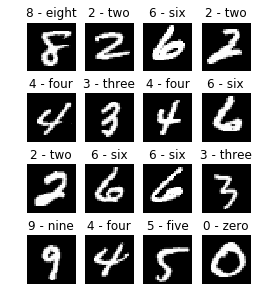

In [165]:
# visualize
mini_batch_img, mini_batch_lbl = next(iter(train_data_loader))

plt.figure(figsize=(4,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    tc_imshow(img=mini_batch_img[i] /2+0.5 ,
              lbl=train_data.classes[mini_batch_lbl[i].numpy()])
    plt.axis('off')
    
plt.savefig('../result/GAN/1-GAN/1-dataloader-example.png', dpi=300)

> 📌 **NOTE**  
>  
> - Downloaded MNIST images from server  
> - Created dataloader for MNIST images

## 3. Random sample $z$ from normal distribution

In [121]:
# hyper-parameter
dim_noise = 100

In [122]:
# Random sampling from normal distribution
def random_sample_z_space(batch_size=1, dim_noise=100):
    return torch.randn(batch_size, dim_noise, device=device)

In [124]:
# Random sampling
z = random_sample_z_space(batch_size)

print("z\t:{}".format(z.shape))

z	:torch.Size([64, 100])


> 📌 **NOTE**  
>  
> - Created a function to random sample $z$ noise

## 4. Generative model $G$

In [127]:
# hyper-paremeters
dim_hidden = 256
sz_output = 28
num_channels = 1

In [ ]:
dim_output = sz_output**2
img_shape = (num_channels, sz_output, sz_output)

In [128]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                    nn.Linear(dim_noise, dim_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(dim_hidden, dim_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(dim_hidden, dim_output),
                    nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [129]:
G = Generator().to(device)

print("z\t:{}".format(z.shape))
print("G(z)\t:{}".format(G(z).size()))

z	:torch.Size([64, 100])
G(z)	:torch.Size([64, 1, 28, 28])


In [ ]:
# visualize
utils.save_image(G(z)[:25].cpu().detach(), "../result/GAN/1-GAN/2-G(z).png", nrow=5, normalize=True)

> 📌 **NOTE**  
>  
> - Defined generative model $G$
> - Because generator $G$ is not trained yet, $G(z)$ produces meaningless noisy images

## 5. Disciminative model $D$

In [131]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(dim_output, dim_hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(dim_hidden, 1),
            nn.Sigmoid()    
        )
    
    def forward(self, img):
        flat_img = img.view(img.size(0), -1)
        check_validity = self.model(flat_img)
        
        return check_validity

In [132]:
D = Discriminator().to(device)

print("z\t:{}".format(z.shape))
print("G(z)\t:{}".format(G(z).size()))
print("D(G(z))\t:{}".format(D(G(z)).size()))

z	:torch.Size([64, 100])
G(z)	:torch.Size([64, 1, 28, 28])
D(G(z))	:torch.Size([64, 1])


> 📌 **NOTE**  
>  
> Defined discriminative model $D$ which architecture is like innverse of generative model $G$  
> The output of $D$ is a sigmoid function to discriminate fake and real image

## 6. Train model $G$ and $D$

### 6-1. Initialize models

In [143]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### 6-2. Loss function & optimizers

In [ ]:
# hyper-parameters
learning_rate = 0.0002
beta1 = 0.9

In [145]:
adversarial_loss = nn.BCELoss()

In [146]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### 6-3. Train models

In [147]:
# hyper-parameters
num_epochs = 200
interval_save_img = 1000

In [148]:
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor

In [149]:
losses = []

for idx_epoch in range(num_epochs):
    for idx_batch, (imgs, _) in enumerate(train_data_loader):
        # Ground truth variables indicating real/fake
        real_ground_truth = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_ground_truth = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) 
        
        # Real image
        real_imgs = Variable(imgs.type(Tensor))
                
        #####################
        # Train Generator
        
        optimizer_G.zero_grad()
        
        # Random sample noise
        z = random_sample_z_space(imgs.size(0))
                
        # Generate image
        gen_imgs = generator(z)
        
        # Generator's loss: loss between D(G(z)) and real ground truth
        loss_G = adversarial_loss(discriminator(gen_imgs), real_ground_truth)
        
        loss_G.backward()
        optimizer_G.step()
        
        
        #####################
        # Train Discriminator
        
        optimizer_D.zero_grad()
        
        loss_real = adversarial_loss(discriminator(real_imgs), real_ground_truth)
        loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake_ground_truth)
        loss_D = (loss_real+loss_fake)/2
        
        loss_D.backward()
        optimizer_D.step()
        
        
        #####################
        # archieve loss
        losses.append([loss_G.item(), loss_D.item()])
        
        # Print progress
        if idx_batch % 10 == 0:
            print("[Epoch {}/{}] [Batch {}/{}] loss_G: {:.6f}, loss_D: {:.6f}".format(idx_epoch, num_epochs,
                                                                                      idx_batch, len(train_data_loader),
                                                                                      loss_G, loss_D))
                    
        batches_done = idx_epoch * len(train_data_loader) + idx_batch
        if batches_done % interval_save_img == 0:
            utils.save_image(gen_imgs.data[:25], "../result/GAN/1-GAN/3-{}.png".format(batches_done), nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/938] loss_G: 0.670637, loss_D: 0.706708
[Epoch 0/200] [Batch 10/938] loss_G: 0.612740, loss_D: 0.422868
[Epoch 0/200] [Batch 20/938] loss_G: 0.515034, loss_D: 0.459941
[Epoch 0/200] [Batch 30/938] loss_G: 0.668941, loss_D: 0.380935
[Epoch 0/200] [Batch 40/938] loss_G: 0.915487, loss_D: 0.362769
[Epoch 0/200] [Batch 50/938] loss_G: 0.490631, loss_D: 0.657668
[Epoch 0/200] [Batch 60/938] loss_G: 0.777424, loss_D: 0.456490
[Epoch 0/200] [Batch 70/938] loss_G: 1.534331, loss_D: 0.180611
[Epoch 0/200] [Batch 80/938] loss_G: 1.537055, loss_D: 0.180810
[Epoch 0/200] [Batch 90/938] loss_G: 1.307803, loss_D: 0.219773
[Epoch 0/200] [Batch 100/938] loss_G: 1.754470, loss_D: 0.154797
[Epoch 0/200] [Batch 110/938] loss_G: 2.609396, loss_D: 0.061309
[Epoch 0/200] [Batch 120/938] loss_G: 2.671367, loss_D: 0.081833
[Epoch 0/200] [Batch 130/938] loss_G: 2.430444, loss_D: 0.072260
[Epoch 0/200] [Batch 140/938] loss_G: 3.002001, loss_D: 0.049765
[Epoch 0/200] [Batch 150/938] loss_G

[Epoch 1/200] [Batch 330/938] loss_G: 3.973284, loss_D: 0.047529
[Epoch 1/200] [Batch 340/938] loss_G: 2.065410, loss_D: 0.142467
[Epoch 1/200] [Batch 350/938] loss_G: 2.616732, loss_D: 0.172344
[Epoch 1/200] [Batch 360/938] loss_G: 4.128443, loss_D: 0.059562
[Epoch 1/200] [Batch 370/938] loss_G: 4.541253, loss_D: 0.059677
[Epoch 1/200] [Batch 380/938] loss_G: 3.187659, loss_D: 0.120872
[Epoch 1/200] [Batch 390/938] loss_G: 3.470205, loss_D: 0.135196
[Epoch 1/200] [Batch 400/938] loss_G: 2.528726, loss_D: 0.105152
[Epoch 1/200] [Batch 410/938] loss_G: 2.485164, loss_D: 0.163092
[Epoch 1/200] [Batch 420/938] loss_G: 2.254733, loss_D: 0.124548
[Epoch 1/200] [Batch 430/938] loss_G: 3.061815, loss_D: 0.055027
[Epoch 1/200] [Batch 440/938] loss_G: 4.336421, loss_D: 0.108118
[Epoch 1/200] [Batch 450/938] loss_G: 2.182111, loss_D: 0.149658
[Epoch 1/200] [Batch 460/938] loss_G: 2.284915, loss_D: 0.192696
[Epoch 1/200] [Batch 470/938] loss_G: 2.074579, loss_D: 0.258915
[Epoch 1/200] [Batch 480/

[Epoch 2/200] [Batch 660/938] loss_G: 2.488386, loss_D: 0.090974
[Epoch 2/200] [Batch 670/938] loss_G: 3.170043, loss_D: 0.064507
[Epoch 2/200] [Batch 680/938] loss_G: 3.141903, loss_D: 0.148666
[Epoch 2/200] [Batch 690/938] loss_G: 3.152137, loss_D: 0.093011
[Epoch 2/200] [Batch 700/938] loss_G: 3.167712, loss_D: 0.096949
[Epoch 2/200] [Batch 710/938] loss_G: 4.400396, loss_D: 0.088163
[Epoch 2/200] [Batch 720/938] loss_G: 5.043070, loss_D: 0.112757
[Epoch 2/200] [Batch 730/938] loss_G: 3.437419, loss_D: 0.058304
[Epoch 2/200] [Batch 740/938] loss_G: 2.599190, loss_D: 0.141939
[Epoch 2/200] [Batch 750/938] loss_G: 4.367873, loss_D: 0.052793
[Epoch 2/200] [Batch 760/938] loss_G: 4.229505, loss_D: 0.042231
[Epoch 2/200] [Batch 770/938] loss_G: 2.998640, loss_D: 0.052737
[Epoch 2/200] [Batch 780/938] loss_G: 4.878094, loss_D: 0.090468
[Epoch 2/200] [Batch 790/938] loss_G: 5.267711, loss_D: 0.036525
[Epoch 2/200] [Batch 800/938] loss_G: 4.003312, loss_D: 0.096130
[Epoch 2/200] [Batch 810/

[Epoch 4/200] [Batch 50/938] loss_G: 5.890211, loss_D: 0.040144
[Epoch 4/200] [Batch 60/938] loss_G: 4.706677, loss_D: 0.032608
[Epoch 4/200] [Batch 70/938] loss_G: 3.358935, loss_D: 0.088134
[Epoch 4/200] [Batch 80/938] loss_G: 4.579930, loss_D: 0.038062
[Epoch 4/200] [Batch 90/938] loss_G: 5.199337, loss_D: 0.016137
[Epoch 4/200] [Batch 100/938] loss_G: 5.999008, loss_D: 0.042397
[Epoch 4/200] [Batch 110/938] loss_G: 4.674767, loss_D: 0.057709
[Epoch 4/200] [Batch 120/938] loss_G: 3.297046, loss_D: 0.046981
[Epoch 4/200] [Batch 130/938] loss_G: 5.365041, loss_D: 0.077244
[Epoch 4/200] [Batch 140/938] loss_G: 3.809953, loss_D: 0.028760
[Epoch 4/200] [Batch 150/938] loss_G: 3.862600, loss_D: 0.022409
[Epoch 4/200] [Batch 160/938] loss_G: 5.010258, loss_D: 0.084212
[Epoch 4/200] [Batch 170/938] loss_G: 6.069232, loss_D: 0.062798
[Epoch 4/200] [Batch 180/938] loss_G: 3.566455, loss_D: 0.109593
[Epoch 4/200] [Batch 190/938] loss_G: 4.105233, loss_D: 0.147852
[Epoch 4/200] [Batch 200/938] 

[Epoch 5/200] [Batch 380/938] loss_G: 4.598617, loss_D: 0.090390
[Epoch 5/200] [Batch 390/938] loss_G: 4.134515, loss_D: 0.134142
[Epoch 5/200] [Batch 400/938] loss_G: 4.877599, loss_D: 0.079945
[Epoch 5/200] [Batch 410/938] loss_G: 3.523589, loss_D: 0.066247
[Epoch 5/200] [Batch 420/938] loss_G: 4.232970, loss_D: 0.063612
[Epoch 5/200] [Batch 430/938] loss_G: 3.643907, loss_D: 0.082943
[Epoch 5/200] [Batch 440/938] loss_G: 4.136440, loss_D: 0.039533
[Epoch 5/200] [Batch 450/938] loss_G: 5.869615, loss_D: 0.109220
[Epoch 5/200] [Batch 460/938] loss_G: 4.209057, loss_D: 0.072044
[Epoch 5/200] [Batch 470/938] loss_G: 4.278205, loss_D: 0.075779
[Epoch 5/200] [Batch 480/938] loss_G: 4.724548, loss_D: 0.119201
[Epoch 5/200] [Batch 490/938] loss_G: 3.140010, loss_D: 0.070644
[Epoch 5/200] [Batch 500/938] loss_G: 4.639814, loss_D: 0.090348
[Epoch 5/200] [Batch 510/938] loss_G: 4.933638, loss_D: 0.036611
[Epoch 5/200] [Batch 520/938] loss_G: 3.948660, loss_D: 0.056280
[Epoch 5/200] [Batch 530/

[Epoch 6/200] [Batch 710/938] loss_G: 4.671487, loss_D: 0.075862
[Epoch 6/200] [Batch 720/938] loss_G: 3.216656, loss_D: 0.090820
[Epoch 6/200] [Batch 730/938] loss_G: 6.237651, loss_D: 0.109386
[Epoch 6/200] [Batch 740/938] loss_G: 3.800006, loss_D: 0.098445
[Epoch 6/200] [Batch 750/938] loss_G: 4.511389, loss_D: 0.109679
[Epoch 6/200] [Batch 760/938] loss_G: 4.703548, loss_D: 0.112763
[Epoch 6/200] [Batch 770/938] loss_G: 6.108838, loss_D: 0.104181
[Epoch 6/200] [Batch 780/938] loss_G: 4.635613, loss_D: 0.199304
[Epoch 6/200] [Batch 790/938] loss_G: 5.745365, loss_D: 0.099765
[Epoch 6/200] [Batch 800/938] loss_G: 2.274288, loss_D: 0.170112
[Epoch 6/200] [Batch 810/938] loss_G: 6.182697, loss_D: 0.133644
[Epoch 6/200] [Batch 820/938] loss_G: 4.915285, loss_D: 0.027335
[Epoch 6/200] [Batch 830/938] loss_G: 4.149548, loss_D: 0.079509
[Epoch 6/200] [Batch 840/938] loss_G: 5.035101, loss_D: 0.073319
[Epoch 6/200] [Batch 850/938] loss_G: 4.530221, loss_D: 0.076911
[Epoch 6/200] [Batch 860/

[Epoch 8/200] [Batch 100/938] loss_G: 4.084428, loss_D: 0.097666
[Epoch 8/200] [Batch 110/938] loss_G: 3.570251, loss_D: 0.209408
[Epoch 8/200] [Batch 120/938] loss_G: 3.834175, loss_D: 0.112210
[Epoch 8/200] [Batch 130/938] loss_G: 4.385314, loss_D: 0.117543
[Epoch 8/200] [Batch 140/938] loss_G: 4.626172, loss_D: 0.050059
[Epoch 8/200] [Batch 150/938] loss_G: 4.364402, loss_D: 0.163078
[Epoch 8/200] [Batch 160/938] loss_G: 4.070649, loss_D: 0.134751
[Epoch 8/200] [Batch 170/938] loss_G: 4.219219, loss_D: 0.075957
[Epoch 8/200] [Batch 180/938] loss_G: 4.027001, loss_D: 0.084443
[Epoch 8/200] [Batch 190/938] loss_G: 4.683633, loss_D: 0.133640
[Epoch 8/200] [Batch 200/938] loss_G: 3.501239, loss_D: 0.125987
[Epoch 8/200] [Batch 210/938] loss_G: 4.810756, loss_D: 0.158247
[Epoch 8/200] [Batch 220/938] loss_G: 3.615493, loss_D: 0.107259
[Epoch 8/200] [Batch 230/938] loss_G: 4.814954, loss_D: 0.114042
[Epoch 8/200] [Batch 240/938] loss_G: 3.737823, loss_D: 0.149892
[Epoch 8/200] [Batch 250/

[Epoch 9/200] [Batch 430/938] loss_G: 2.814676, loss_D: 0.135635
[Epoch 9/200] [Batch 440/938] loss_G: 4.157687, loss_D: 0.055921
[Epoch 9/200] [Batch 450/938] loss_G: 2.878706, loss_D: 0.169542
[Epoch 9/200] [Batch 460/938] loss_G: 4.083382, loss_D: 0.124321
[Epoch 9/200] [Batch 470/938] loss_G: 3.639338, loss_D: 0.102361
[Epoch 9/200] [Batch 480/938] loss_G: 5.094286, loss_D: 0.160088
[Epoch 9/200] [Batch 490/938] loss_G: 4.518668, loss_D: 0.111474
[Epoch 9/200] [Batch 500/938] loss_G: 3.471159, loss_D: 0.133745
[Epoch 9/200] [Batch 510/938] loss_G: 4.833358, loss_D: 0.208889
[Epoch 9/200] [Batch 520/938] loss_G: 3.847677, loss_D: 0.092875
[Epoch 9/200] [Batch 530/938] loss_G: 5.633980, loss_D: 0.087481
[Epoch 9/200] [Batch 540/938] loss_G: 4.118041, loss_D: 0.099700
[Epoch 9/200] [Batch 550/938] loss_G: 4.495176, loss_D: 0.099131
[Epoch 9/200] [Batch 560/938] loss_G: 4.271194, loss_D: 0.121925
[Epoch 9/200] [Batch 570/938] loss_G: 3.545552, loss_D: 0.164676
[Epoch 9/200] [Batch 580/

[Epoch 10/200] [Batch 750/938] loss_G: 2.859156, loss_D: 0.299509
[Epoch 10/200] [Batch 760/938] loss_G: 1.258091, loss_D: 0.369697
[Epoch 10/200] [Batch 770/938] loss_G: 3.017873, loss_D: 0.236455
[Epoch 10/200] [Batch 780/938] loss_G: 2.805952, loss_D: 0.213543
[Epoch 10/200] [Batch 790/938] loss_G: 2.544048, loss_D: 0.215803
[Epoch 10/200] [Batch 800/938] loss_G: 3.982647, loss_D: 0.222808
[Epoch 10/200] [Batch 810/938] loss_G: 2.295215, loss_D: 0.216340
[Epoch 10/200] [Batch 820/938] loss_G: 4.008980, loss_D: 0.498242
[Epoch 10/200] [Batch 830/938] loss_G: 2.029590, loss_D: 0.200860
[Epoch 10/200] [Batch 840/938] loss_G: 3.655788, loss_D: 0.076972
[Epoch 10/200] [Batch 850/938] loss_G: 3.658956, loss_D: 0.130919
[Epoch 10/200] [Batch 860/938] loss_G: 3.508356, loss_D: 0.270995
[Epoch 10/200] [Batch 870/938] loss_G: 2.131477, loss_D: 0.261778
[Epoch 10/200] [Batch 880/938] loss_G: 3.922987, loss_D: 0.142912
[Epoch 10/200] [Batch 890/938] loss_G: 3.123984, loss_D: 0.159247
[Epoch 10/

[Epoch 12/200] [Batch 120/938] loss_G: 2.194187, loss_D: 0.273026
[Epoch 12/200] [Batch 130/938] loss_G: 3.833835, loss_D: 0.217421
[Epoch 12/200] [Batch 140/938] loss_G: 2.937415, loss_D: 0.148382
[Epoch 12/200] [Batch 150/938] loss_G: 3.006595, loss_D: 0.128924
[Epoch 12/200] [Batch 160/938] loss_G: 2.263420, loss_D: 0.323492
[Epoch 12/200] [Batch 170/938] loss_G: 2.288593, loss_D: 0.250750
[Epoch 12/200] [Batch 180/938] loss_G: 2.534887, loss_D: 0.229799
[Epoch 12/200] [Batch 190/938] loss_G: 2.486266, loss_D: 0.151213
[Epoch 12/200] [Batch 200/938] loss_G: 2.559333, loss_D: 0.190715
[Epoch 12/200] [Batch 210/938] loss_G: 3.247782, loss_D: 0.253572
[Epoch 12/200] [Batch 220/938] loss_G: 2.731283, loss_D: 0.170686
[Epoch 12/200] [Batch 230/938] loss_G: 2.557000, loss_D: 0.161260
[Epoch 12/200] [Batch 240/938] loss_G: 2.799334, loss_D: 0.168277
[Epoch 12/200] [Batch 250/938] loss_G: 3.469806, loss_D: 0.218660
[Epoch 12/200] [Batch 260/938] loss_G: 2.056691, loss_D: 0.191721
[Epoch 12/

[Epoch 13/200] [Batch 430/938] loss_G: 2.924024, loss_D: 0.237541
[Epoch 13/200] [Batch 440/938] loss_G: 2.556819, loss_D: 0.222555
[Epoch 13/200] [Batch 450/938] loss_G: 2.122958, loss_D: 0.250697
[Epoch 13/200] [Batch 460/938] loss_G: 2.347024, loss_D: 0.208102
[Epoch 13/200] [Batch 470/938] loss_G: 3.255381, loss_D: 0.162425
[Epoch 13/200] [Batch 480/938] loss_G: 2.013272, loss_D: 0.241846
[Epoch 13/200] [Batch 490/938] loss_G: 2.752122, loss_D: 0.247686
[Epoch 13/200] [Batch 500/938] loss_G: 2.265958, loss_D: 0.329492
[Epoch 13/200] [Batch 510/938] loss_G: 3.231785, loss_D: 0.178860
[Epoch 13/200] [Batch 520/938] loss_G: 2.138412, loss_D: 0.217876
[Epoch 13/200] [Batch 530/938] loss_G: 2.471073, loss_D: 0.194570
[Epoch 13/200] [Batch 540/938] loss_G: 2.509288, loss_D: 0.238350
[Epoch 13/200] [Batch 550/938] loss_G: 2.646675, loss_D: 0.322446
[Epoch 13/200] [Batch 560/938] loss_G: 2.286537, loss_D: 0.187845
[Epoch 13/200] [Batch 570/938] loss_G: 3.728257, loss_D: 0.119041
[Epoch 13/

[Epoch 14/200] [Batch 740/938] loss_G: 2.709137, loss_D: 0.174465
[Epoch 14/200] [Batch 750/938] loss_G: 2.771127, loss_D: 0.258317
[Epoch 14/200] [Batch 760/938] loss_G: 2.431558, loss_D: 0.246756
[Epoch 14/200] [Batch 770/938] loss_G: 2.964122, loss_D: 0.221175
[Epoch 14/200] [Batch 780/938] loss_G: 1.750606, loss_D: 0.304651
[Epoch 14/200] [Batch 790/938] loss_G: 3.077371, loss_D: 0.352106
[Epoch 14/200] [Batch 800/938] loss_G: 1.984612, loss_D: 0.362689
[Epoch 14/200] [Batch 810/938] loss_G: 2.562746, loss_D: 0.232918
[Epoch 14/200] [Batch 820/938] loss_G: 3.205185, loss_D: 0.202349
[Epoch 14/200] [Batch 830/938] loss_G: 2.132857, loss_D: 0.183794
[Epoch 14/200] [Batch 840/938] loss_G: 2.495078, loss_D: 0.341513
[Epoch 14/200] [Batch 850/938] loss_G: 1.450199, loss_D: 0.324047
[Epoch 14/200] [Batch 860/938] loss_G: 3.296185, loss_D: 0.275013
[Epoch 14/200] [Batch 870/938] loss_G: 2.547211, loss_D: 0.292618
[Epoch 14/200] [Batch 880/938] loss_G: 1.807274, loss_D: 0.349939
[Epoch 14/

[Epoch 16/200] [Batch 110/938] loss_G: 2.028972, loss_D: 0.322823
[Epoch 16/200] [Batch 120/938] loss_G: 2.106301, loss_D: 0.275626
[Epoch 16/200] [Batch 130/938] loss_G: 2.617190, loss_D: 0.173479
[Epoch 16/200] [Batch 140/938] loss_G: 2.600832, loss_D: 0.229690
[Epoch 16/200] [Batch 150/938] loss_G: 2.166124, loss_D: 0.220127
[Epoch 16/200] [Batch 160/938] loss_G: 2.391210, loss_D: 0.414661
[Epoch 16/200] [Batch 170/938] loss_G: 2.655027, loss_D: 0.196213
[Epoch 16/200] [Batch 180/938] loss_G: 2.014253, loss_D: 0.341008
[Epoch 16/200] [Batch 190/938] loss_G: 2.471940, loss_D: 0.273138
[Epoch 16/200] [Batch 200/938] loss_G: 2.182889, loss_D: 0.260960
[Epoch 16/200] [Batch 210/938] loss_G: 3.232495, loss_D: 0.282043
[Epoch 16/200] [Batch 220/938] loss_G: 2.313699, loss_D: 0.256509
[Epoch 16/200] [Batch 230/938] loss_G: 2.414805, loss_D: 0.362214
[Epoch 16/200] [Batch 240/938] loss_G: 2.286759, loss_D: 0.321987
[Epoch 16/200] [Batch 250/938] loss_G: 1.998092, loss_D: 0.235990
[Epoch 16/

[Epoch 17/200] [Batch 420/938] loss_G: 1.972349, loss_D: 0.331171
[Epoch 17/200] [Batch 430/938] loss_G: 2.245792, loss_D: 0.269110
[Epoch 17/200] [Batch 440/938] loss_G: 2.422158, loss_D: 0.252342
[Epoch 17/200] [Batch 450/938] loss_G: 2.244303, loss_D: 0.231362
[Epoch 17/200] [Batch 460/938] loss_G: 2.357619, loss_D: 0.200259
[Epoch 17/200] [Batch 470/938] loss_G: 2.559463, loss_D: 0.229709
[Epoch 17/200] [Batch 480/938] loss_G: 1.899027, loss_D: 0.283913
[Epoch 17/200] [Batch 490/938] loss_G: 2.399661, loss_D: 0.271198
[Epoch 17/200] [Batch 500/938] loss_G: 3.018346, loss_D: 0.397208
[Epoch 17/200] [Batch 510/938] loss_G: 2.118804, loss_D: 0.298369
[Epoch 17/200] [Batch 520/938] loss_G: 2.488949, loss_D: 0.363854
[Epoch 17/200] [Batch 530/938] loss_G: 1.492646, loss_D: 0.459099
[Epoch 17/200] [Batch 540/938] loss_G: 2.251797, loss_D: 0.256423
[Epoch 17/200] [Batch 550/938] loss_G: 2.953017, loss_D: 0.196049
[Epoch 17/200] [Batch 560/938] loss_G: 2.654843, loss_D: 0.356542
[Epoch 17/

[Epoch 18/200] [Batch 730/938] loss_G: 2.582060, loss_D: 0.320349
[Epoch 18/200] [Batch 740/938] loss_G: 2.027712, loss_D: 0.243827
[Epoch 18/200] [Batch 750/938] loss_G: 2.664412, loss_D: 0.300808
[Epoch 18/200] [Batch 760/938] loss_G: 1.306098, loss_D: 0.302521
[Epoch 18/200] [Batch 770/938] loss_G: 1.967978, loss_D: 0.269515
[Epoch 18/200] [Batch 780/938] loss_G: 2.878204, loss_D: 0.226516
[Epoch 18/200] [Batch 790/938] loss_G: 2.573258, loss_D: 0.238838
[Epoch 18/200] [Batch 800/938] loss_G: 2.006970, loss_D: 0.310594
[Epoch 18/200] [Batch 810/938] loss_G: 2.421191, loss_D: 0.264284
[Epoch 18/200] [Batch 820/938] loss_G: 2.642159, loss_D: 0.313246
[Epoch 18/200] [Batch 830/938] loss_G: 2.036860, loss_D: 0.317781
[Epoch 18/200] [Batch 840/938] loss_G: 2.090025, loss_D: 0.265134
[Epoch 18/200] [Batch 850/938] loss_G: 2.971417, loss_D: 0.329799
[Epoch 18/200] [Batch 860/938] loss_G: 1.711990, loss_D: 0.341713
[Epoch 18/200] [Batch 870/938] loss_G: 2.047838, loss_D: 0.380644
[Epoch 18/

[Epoch 20/200] [Batch 100/938] loss_G: 2.124695, loss_D: 0.352421
[Epoch 20/200] [Batch 110/938] loss_G: 2.114611, loss_D: 0.309985
[Epoch 20/200] [Batch 120/938] loss_G: 2.193376, loss_D: 0.270232
[Epoch 20/200] [Batch 130/938] loss_G: 1.664426, loss_D: 0.278476
[Epoch 20/200] [Batch 140/938] loss_G: 1.502000, loss_D: 0.392055
[Epoch 20/200] [Batch 150/938] loss_G: 1.812627, loss_D: 0.351498
[Epoch 20/200] [Batch 160/938] loss_G: 1.554731, loss_D: 0.264368
[Epoch 20/200] [Batch 170/938] loss_G: 2.262833, loss_D: 0.252752
[Epoch 20/200] [Batch 180/938] loss_G: 1.958194, loss_D: 0.269528
[Epoch 20/200] [Batch 190/938] loss_G: 1.916642, loss_D: 0.308061
[Epoch 20/200] [Batch 200/938] loss_G: 1.832544, loss_D: 0.340533
[Epoch 20/200] [Batch 210/938] loss_G: 2.027453, loss_D: 0.298038
[Epoch 20/200] [Batch 220/938] loss_G: 1.904236, loss_D: 0.308385
[Epoch 20/200] [Batch 230/938] loss_G: 1.917925, loss_D: 0.408108
[Epoch 20/200] [Batch 240/938] loss_G: 1.504020, loss_D: 0.372875
[Epoch 20/

[Epoch 21/200] [Batch 410/938] loss_G: 1.504692, loss_D: 0.456033
[Epoch 21/200] [Batch 420/938] loss_G: 1.717054, loss_D: 0.346469
[Epoch 21/200] [Batch 430/938] loss_G: 1.322453, loss_D: 0.443974
[Epoch 21/200] [Batch 440/938] loss_G: 1.691655, loss_D: 0.518072
[Epoch 21/200] [Batch 450/938] loss_G: 1.473969, loss_D: 0.434336
[Epoch 21/200] [Batch 460/938] loss_G: 1.818772, loss_D: 0.303296
[Epoch 21/200] [Batch 470/938] loss_G: 2.121499, loss_D: 0.277168
[Epoch 21/200] [Batch 480/938] loss_G: 2.309534, loss_D: 0.265053
[Epoch 21/200] [Batch 490/938] loss_G: 2.054711, loss_D: 0.421978
[Epoch 21/200] [Batch 500/938] loss_G: 1.406960, loss_D: 0.401257
[Epoch 21/200] [Batch 510/938] loss_G: 2.016181, loss_D: 0.266393
[Epoch 21/200] [Batch 520/938] loss_G: 2.175286, loss_D: 0.314727
[Epoch 21/200] [Batch 530/938] loss_G: 2.129838, loss_D: 0.270996
[Epoch 21/200] [Batch 540/938] loss_G: 1.966902, loss_D: 0.314848
[Epoch 21/200] [Batch 550/938] loss_G: 2.209726, loss_D: 0.305600
[Epoch 21/

[Epoch 22/200] [Batch 720/938] loss_G: 2.779814, loss_D: 0.276086
[Epoch 22/200] [Batch 730/938] loss_G: 2.318172, loss_D: 0.231501
[Epoch 22/200] [Batch 740/938] loss_G: 2.005898, loss_D: 0.379137
[Epoch 22/200] [Batch 750/938] loss_G: 1.545093, loss_D: 0.460219
[Epoch 22/200] [Batch 760/938] loss_G: 1.675777, loss_D: 0.387119
[Epoch 22/200] [Batch 770/938] loss_G: 2.421485, loss_D: 0.271034
[Epoch 22/200] [Batch 780/938] loss_G: 2.187902, loss_D: 0.247455
[Epoch 22/200] [Batch 790/938] loss_G: 2.406148, loss_D: 0.208279
[Epoch 22/200] [Batch 800/938] loss_G: 2.425638, loss_D: 0.422470
[Epoch 22/200] [Batch 810/938] loss_G: 1.407060, loss_D: 0.532262
[Epoch 22/200] [Batch 820/938] loss_G: 1.444831, loss_D: 0.440192
[Epoch 22/200] [Batch 830/938] loss_G: 1.551894, loss_D: 0.453547
[Epoch 22/200] [Batch 840/938] loss_G: 1.558074, loss_D: 0.467130
[Epoch 22/200] [Batch 850/938] loss_G: 1.804358, loss_D: 0.457845
[Epoch 22/200] [Batch 860/938] loss_G: 2.293766, loss_D: 0.327885
[Epoch 22/

[Epoch 24/200] [Batch 90/938] loss_G: 1.865633, loss_D: 0.465883
[Epoch 24/200] [Batch 100/938] loss_G: 1.903566, loss_D: 0.343597
[Epoch 24/200] [Batch 110/938] loss_G: 1.733390, loss_D: 0.348917
[Epoch 24/200] [Batch 120/938] loss_G: 2.122277, loss_D: 0.412184
[Epoch 24/200] [Batch 130/938] loss_G: 1.719375, loss_D: 0.392732
[Epoch 24/200] [Batch 140/938] loss_G: 1.890398, loss_D: 0.371401
[Epoch 24/200] [Batch 150/938] loss_G: 2.338817, loss_D: 0.289450
[Epoch 24/200] [Batch 160/938] loss_G: 1.966537, loss_D: 0.273778
[Epoch 24/200] [Batch 170/938] loss_G: 2.170945, loss_D: 0.347003
[Epoch 24/200] [Batch 180/938] loss_G: 1.924281, loss_D: 0.374933
[Epoch 24/200] [Batch 190/938] loss_G: 1.653058, loss_D: 0.344014
[Epoch 24/200] [Batch 200/938] loss_G: 1.834055, loss_D: 0.315863
[Epoch 24/200] [Batch 210/938] loss_G: 2.119863, loss_D: 0.300482
[Epoch 24/200] [Batch 220/938] loss_G: 1.759737, loss_D: 0.366746
[Epoch 24/200] [Batch 230/938] loss_G: 1.880610, loss_D: 0.384651
[Epoch 24/2

[Epoch 25/200] [Batch 400/938] loss_G: 1.865542, loss_D: 0.358506
[Epoch 25/200] [Batch 410/938] loss_G: 1.784912, loss_D: 0.354399
[Epoch 25/200] [Batch 420/938] loss_G: 1.539216, loss_D: 0.393340
[Epoch 25/200] [Batch 430/938] loss_G: 1.766331, loss_D: 0.382493
[Epoch 25/200] [Batch 440/938] loss_G: 1.906367, loss_D: 0.415837
[Epoch 25/200] [Batch 450/938] loss_G: 1.489902, loss_D: 0.358321
[Epoch 25/200] [Batch 460/938] loss_G: 1.950450, loss_D: 0.309823
[Epoch 25/200] [Batch 470/938] loss_G: 2.089151, loss_D: 0.312161
[Epoch 25/200] [Batch 480/938] loss_G: 2.038690, loss_D: 0.422845
[Epoch 25/200] [Batch 490/938] loss_G: 1.098634, loss_D: 0.440850
[Epoch 25/200] [Batch 500/938] loss_G: 1.826958, loss_D: 0.431624
[Epoch 25/200] [Batch 510/938] loss_G: 2.131094, loss_D: 0.423433
[Epoch 25/200] [Batch 520/938] loss_G: 1.462589, loss_D: 0.444566
[Epoch 25/200] [Batch 530/938] loss_G: 1.760682, loss_D: 0.412343
[Epoch 25/200] [Batch 540/938] loss_G: 1.709931, loss_D: 0.418736
[Epoch 25/

[Epoch 26/200] [Batch 710/938] loss_G: 1.530298, loss_D: 0.386456
[Epoch 26/200] [Batch 720/938] loss_G: 1.683325, loss_D: 0.371387
[Epoch 26/200] [Batch 730/938] loss_G: 2.248429, loss_D: 0.412038
[Epoch 26/200] [Batch 740/938] loss_G: 1.597960, loss_D: 0.395537
[Epoch 26/200] [Batch 750/938] loss_G: 1.452616, loss_D: 0.403638
[Epoch 26/200] [Batch 760/938] loss_G: 1.758123, loss_D: 0.400119
[Epoch 26/200] [Batch 770/938] loss_G: 1.712471, loss_D: 0.430160
[Epoch 26/200] [Batch 780/938] loss_G: 1.705701, loss_D: 0.368249
[Epoch 26/200] [Batch 790/938] loss_G: 1.728993, loss_D: 0.348558
[Epoch 26/200] [Batch 800/938] loss_G: 1.758905, loss_D: 0.421723
[Epoch 26/200] [Batch 810/938] loss_G: 1.846868, loss_D: 0.410042
[Epoch 26/200] [Batch 820/938] loss_G: 1.775642, loss_D: 0.418957
[Epoch 26/200] [Batch 830/938] loss_G: 1.553599, loss_D: 0.426851
[Epoch 26/200] [Batch 840/938] loss_G: 1.578487, loss_D: 0.413353
[Epoch 26/200] [Batch 850/938] loss_G: 1.617169, loss_D: 0.407751
[Epoch 26/

[Epoch 28/200] [Batch 80/938] loss_G: 1.792511, loss_D: 0.360740
[Epoch 28/200] [Batch 90/938] loss_G: 2.071438, loss_D: 0.341611
[Epoch 28/200] [Batch 100/938] loss_G: 1.857475, loss_D: 0.418872
[Epoch 28/200] [Batch 110/938] loss_G: 1.367368, loss_D: 0.483134
[Epoch 28/200] [Batch 120/938] loss_G: 1.332285, loss_D: 0.546138
[Epoch 28/200] [Batch 130/938] loss_G: 1.626395, loss_D: 0.454973
[Epoch 28/200] [Batch 140/938] loss_G: 1.759603, loss_D: 0.338189
[Epoch 28/200] [Batch 150/938] loss_G: 1.585497, loss_D: 0.280449
[Epoch 28/200] [Batch 160/938] loss_G: 1.738747, loss_D: 0.347665
[Epoch 28/200] [Batch 170/938] loss_G: 2.081924, loss_D: 0.394353
[Epoch 28/200] [Batch 180/938] loss_G: 1.762624, loss_D: 0.458305
[Epoch 28/200] [Batch 190/938] loss_G: 1.901396, loss_D: 0.386082
[Epoch 28/200] [Batch 200/938] loss_G: 1.627568, loss_D: 0.395729
[Epoch 28/200] [Batch 210/938] loss_G: 1.450141, loss_D: 0.414457
[Epoch 28/200] [Batch 220/938] loss_G: 1.705212, loss_D: 0.440593
[Epoch 28/20

[Epoch 29/200] [Batch 390/938] loss_G: 1.799352, loss_D: 0.402461
[Epoch 29/200] [Batch 400/938] loss_G: 1.661008, loss_D: 0.362823
[Epoch 29/200] [Batch 410/938] loss_G: 1.716137, loss_D: 0.364556
[Epoch 29/200] [Batch 420/938] loss_G: 1.273712, loss_D: 0.472392
[Epoch 29/200] [Batch 430/938] loss_G: 1.811598, loss_D: 0.473316
[Epoch 29/200] [Batch 440/938] loss_G: 1.379949, loss_D: 0.484888
[Epoch 29/200] [Batch 450/938] loss_G: 1.738383, loss_D: 0.336348
[Epoch 29/200] [Batch 460/938] loss_G: 1.736792, loss_D: 0.370779
[Epoch 29/200] [Batch 470/938] loss_G: 1.961325, loss_D: 0.398046
[Epoch 29/200] [Batch 480/938] loss_G: 1.467491, loss_D: 0.409876
[Epoch 29/200] [Batch 490/938] loss_G: 1.381695, loss_D: 0.425044
[Epoch 29/200] [Batch 500/938] loss_G: 2.030282, loss_D: 0.388588
[Epoch 29/200] [Batch 510/938] loss_G: 1.513196, loss_D: 0.448873
[Epoch 29/200] [Batch 520/938] loss_G: 1.239726, loss_D: 0.424712
[Epoch 29/200] [Batch 530/938] loss_G: 1.212658, loss_D: 0.465990
[Epoch 29/

[Epoch 30/200] [Batch 700/938] loss_G: 1.541268, loss_D: 0.489455
[Epoch 30/200] [Batch 710/938] loss_G: 1.417465, loss_D: 0.489894
[Epoch 30/200] [Batch 720/938] loss_G: 1.786660, loss_D: 0.365205
[Epoch 30/200] [Batch 730/938] loss_G: 1.843963, loss_D: 0.307197
[Epoch 30/200] [Batch 740/938] loss_G: 1.444153, loss_D: 0.537759
[Epoch 30/200] [Batch 750/938] loss_G: 1.529144, loss_D: 0.444770
[Epoch 30/200] [Batch 760/938] loss_G: 1.363034, loss_D: 0.404598
[Epoch 30/200] [Batch 770/938] loss_G: 2.229563, loss_D: 0.333796
[Epoch 30/200] [Batch 780/938] loss_G: 1.650248, loss_D: 0.522138
[Epoch 30/200] [Batch 790/938] loss_G: 1.411349, loss_D: 0.452612
[Epoch 30/200] [Batch 800/938] loss_G: 1.674102, loss_D: 0.514104
[Epoch 30/200] [Batch 810/938] loss_G: 1.329009, loss_D: 0.504390
[Epoch 30/200] [Batch 820/938] loss_G: 1.375707, loss_D: 0.493937
[Epoch 30/200] [Batch 830/938] loss_G: 1.738300, loss_D: 0.357949
[Epoch 30/200] [Batch 840/938] loss_G: 1.770911, loss_D: 0.362384
[Epoch 30/

[Epoch 32/200] [Batch 70/938] loss_G: 1.679826, loss_D: 0.383398
[Epoch 32/200] [Batch 80/938] loss_G: 1.864641, loss_D: 0.386791
[Epoch 32/200] [Batch 90/938] loss_G: 1.688933, loss_D: 0.437690
[Epoch 32/200] [Batch 100/938] loss_G: 1.283192, loss_D: 0.507446
[Epoch 32/200] [Batch 110/938] loss_G: 1.442080, loss_D: 0.537042
[Epoch 32/200] [Batch 120/938] loss_G: 1.548275, loss_D: 0.447202
[Epoch 32/200] [Batch 130/938] loss_G: 1.703611, loss_D: 0.437090
[Epoch 32/200] [Batch 140/938] loss_G: 1.291896, loss_D: 0.392038
[Epoch 32/200] [Batch 150/938] loss_G: 2.129059, loss_D: 0.398816
[Epoch 32/200] [Batch 160/938] loss_G: 1.980075, loss_D: 0.377049
[Epoch 32/200] [Batch 170/938] loss_G: 1.260080, loss_D: 0.521642
[Epoch 32/200] [Batch 180/938] loss_G: 1.315845, loss_D: 0.462673
[Epoch 32/200] [Batch 190/938] loss_G: 1.614354, loss_D: 0.386657
[Epoch 32/200] [Batch 200/938] loss_G: 2.125289, loss_D: 0.317193
[Epoch 32/200] [Batch 210/938] loss_G: 1.619405, loss_D: 0.418884
[Epoch 32/200

[Epoch 33/200] [Batch 380/938] loss_G: 1.355395, loss_D: 0.457036
[Epoch 33/200] [Batch 390/938] loss_G: 2.038455, loss_D: 0.486429
[Epoch 33/200] [Batch 400/938] loss_G: 1.579865, loss_D: 0.497278
[Epoch 33/200] [Batch 410/938] loss_G: 1.203413, loss_D: 0.486504
[Epoch 33/200] [Batch 420/938] loss_G: 1.868015, loss_D: 0.424015
[Epoch 33/200] [Batch 430/938] loss_G: 1.814182, loss_D: 0.441359
[Epoch 33/200] [Batch 440/938] loss_G: 1.604631, loss_D: 0.414740
[Epoch 33/200] [Batch 450/938] loss_G: 1.555023, loss_D: 0.481096
[Epoch 33/200] [Batch 460/938] loss_G: 1.891619, loss_D: 0.405771
[Epoch 33/200] [Batch 470/938] loss_G: 2.111637, loss_D: 0.417251
[Epoch 33/200] [Batch 480/938] loss_G: 1.318838, loss_D: 0.444359
[Epoch 33/200] [Batch 490/938] loss_G: 1.572788, loss_D: 0.480737
[Epoch 33/200] [Batch 500/938] loss_G: 1.525713, loss_D: 0.396907
[Epoch 33/200] [Batch 510/938] loss_G: 1.231238, loss_D: 0.450905
[Epoch 33/200] [Batch 520/938] loss_G: 1.212644, loss_D: 0.566189
[Epoch 33/

[Epoch 34/200] [Batch 690/938] loss_G: 1.906994, loss_D: 0.489675
[Epoch 34/200] [Batch 700/938] loss_G: 1.410996, loss_D: 0.642744
[Epoch 34/200] [Batch 710/938] loss_G: 1.525585, loss_D: 0.489205
[Epoch 34/200] [Batch 720/938] loss_G: 1.590484, loss_D: 0.437020
[Epoch 34/200] [Batch 730/938] loss_G: 1.696200, loss_D: 0.395774
[Epoch 34/200] [Batch 740/938] loss_G: 1.891854, loss_D: 0.400994
[Epoch 34/200] [Batch 750/938] loss_G: 1.455275, loss_D: 0.436622
[Epoch 34/200] [Batch 760/938] loss_G: 1.777791, loss_D: 0.576288
[Epoch 34/200] [Batch 770/938] loss_G: 1.541558, loss_D: 0.474684
[Epoch 34/200] [Batch 780/938] loss_G: 2.113041, loss_D: 0.477832
[Epoch 34/200] [Batch 790/938] loss_G: 1.563853, loss_D: 0.363878
[Epoch 34/200] [Batch 800/938] loss_G: 1.443062, loss_D: 0.434390
[Epoch 34/200] [Batch 810/938] loss_G: 1.598517, loss_D: 0.412185
[Epoch 34/200] [Batch 820/938] loss_G: 1.593004, loss_D: 0.376338
[Epoch 34/200] [Batch 830/938] loss_G: 1.699520, loss_D: 0.387264
[Epoch 34/

[Epoch 36/200] [Batch 60/938] loss_G: 1.632731, loss_D: 0.501452
[Epoch 36/200] [Batch 70/938] loss_G: 1.258582, loss_D: 0.406941
[Epoch 36/200] [Batch 80/938] loss_G: 1.390920, loss_D: 0.409713
[Epoch 36/200] [Batch 90/938] loss_G: 1.420932, loss_D: 0.523442
[Epoch 36/200] [Batch 100/938] loss_G: 1.636306, loss_D: 0.494316
[Epoch 36/200] [Batch 110/938] loss_G: 1.393849, loss_D: 0.393640
[Epoch 36/200] [Batch 120/938] loss_G: 1.538941, loss_D: 0.460001
[Epoch 36/200] [Batch 130/938] loss_G: 1.667374, loss_D: 0.549398
[Epoch 36/200] [Batch 140/938] loss_G: 1.219555, loss_D: 0.460130
[Epoch 36/200] [Batch 150/938] loss_G: 1.421227, loss_D: 0.423076
[Epoch 36/200] [Batch 160/938] loss_G: 1.338266, loss_D: 0.448267
[Epoch 36/200] [Batch 170/938] loss_G: 1.655881, loss_D: 0.398890
[Epoch 36/200] [Batch 180/938] loss_G: 1.703827, loss_D: 0.402312
[Epoch 36/200] [Batch 190/938] loss_G: 1.794956, loss_D: 0.385686
[Epoch 36/200] [Batch 200/938] loss_G: 1.500429, loss_D: 0.506209
[Epoch 36/200]

[Epoch 37/200] [Batch 370/938] loss_G: 1.370160, loss_D: 0.564755
[Epoch 37/200] [Batch 380/938] loss_G: 1.418005, loss_D: 0.465371
[Epoch 37/200] [Batch 390/938] loss_G: 1.524657, loss_D: 0.370796
[Epoch 37/200] [Batch 400/938] loss_G: 1.986697, loss_D: 0.393596
[Epoch 37/200] [Batch 410/938] loss_G: 1.102682, loss_D: 0.527509
[Epoch 37/200] [Batch 420/938] loss_G: 1.217556, loss_D: 0.571276
[Epoch 37/200] [Batch 430/938] loss_G: 1.435019, loss_D: 0.489503
[Epoch 37/200] [Batch 440/938] loss_G: 1.437562, loss_D: 0.404917
[Epoch 37/200] [Batch 450/938] loss_G: 1.467566, loss_D: 0.380168
[Epoch 37/200] [Batch 460/938] loss_G: 1.890564, loss_D: 0.434537
[Epoch 37/200] [Batch 470/938] loss_G: 1.484018, loss_D: 0.366775
[Epoch 37/200] [Batch 480/938] loss_G: 1.602402, loss_D: 0.447006
[Epoch 37/200] [Batch 490/938] loss_G: 1.604792, loss_D: 0.545593
[Epoch 37/200] [Batch 500/938] loss_G: 1.629680, loss_D: 0.455711
[Epoch 37/200] [Batch 510/938] loss_G: 2.081080, loss_D: 0.437819
[Epoch 37/

[Epoch 38/200] [Batch 680/938] loss_G: 1.123368, loss_D: 0.469957
[Epoch 38/200] [Batch 690/938] loss_G: 1.161424, loss_D: 0.459489
[Epoch 38/200] [Batch 700/938] loss_G: 1.563838, loss_D: 0.477780
[Epoch 38/200] [Batch 710/938] loss_G: 1.724585, loss_D: 0.419555
[Epoch 38/200] [Batch 720/938] loss_G: 1.804025, loss_D: 0.473621
[Epoch 38/200] [Batch 730/938] loss_G: 1.381002, loss_D: 0.521817
[Epoch 38/200] [Batch 740/938] loss_G: 1.013965, loss_D: 0.688551
[Epoch 38/200] [Batch 750/938] loss_G: 1.168770, loss_D: 0.508865
[Epoch 38/200] [Batch 760/938] loss_G: 1.223343, loss_D: 0.441930
[Epoch 38/200] [Batch 770/938] loss_G: 1.778616, loss_D: 0.406636
[Epoch 38/200] [Batch 780/938] loss_G: 1.322601, loss_D: 0.411334
[Epoch 38/200] [Batch 790/938] loss_G: 1.599807, loss_D: 0.421468
[Epoch 38/200] [Batch 800/938] loss_G: 1.691718, loss_D: 0.453781
[Epoch 38/200] [Batch 810/938] loss_G: 1.463956, loss_D: 0.458013
[Epoch 38/200] [Batch 820/938] loss_G: 1.571510, loss_D: 0.428360
[Epoch 38/

[Epoch 40/200] [Batch 50/938] loss_G: 1.552707, loss_D: 0.433766
[Epoch 40/200] [Batch 60/938] loss_G: 1.491075, loss_D: 0.456713
[Epoch 40/200] [Batch 70/938] loss_G: 1.503627, loss_D: 0.447500
[Epoch 40/200] [Batch 80/938] loss_G: 1.483309, loss_D: 0.527729
[Epoch 40/200] [Batch 90/938] loss_G: 1.435157, loss_D: 0.470163
[Epoch 40/200] [Batch 100/938] loss_G: 1.439946, loss_D: 0.455256
[Epoch 40/200] [Batch 110/938] loss_G: 1.460906, loss_D: 0.575858
[Epoch 40/200] [Batch 120/938] loss_G: 1.920861, loss_D: 0.525003
[Epoch 40/200] [Batch 130/938] loss_G: 1.544357, loss_D: 0.450065
[Epoch 40/200] [Batch 140/938] loss_G: 1.564057, loss_D: 0.445648
[Epoch 40/200] [Batch 150/938] loss_G: 1.480232, loss_D: 0.620946
[Epoch 40/200] [Batch 160/938] loss_G: 1.397674, loss_D: 0.554429
[Epoch 40/200] [Batch 170/938] loss_G: 1.502887, loss_D: 0.496278
[Epoch 40/200] [Batch 180/938] loss_G: 1.769795, loss_D: 0.544481
[Epoch 40/200] [Batch 190/938] loss_G: 1.587120, loss_D: 0.415141
[Epoch 40/200] 

[Epoch 41/200] [Batch 360/938] loss_G: 1.623717, loss_D: 0.421098
[Epoch 41/200] [Batch 370/938] loss_G: 1.896960, loss_D: 0.528507
[Epoch 41/200] [Batch 380/938] loss_G: 1.437711, loss_D: 0.457236
[Epoch 41/200] [Batch 390/938] loss_G: 1.403457, loss_D: 0.447562
[Epoch 41/200] [Batch 400/938] loss_G: 1.025320, loss_D: 0.572094
[Epoch 41/200] [Batch 410/938] loss_G: 1.214756, loss_D: 0.494828
[Epoch 41/200] [Batch 420/938] loss_G: 1.479833, loss_D: 0.446990
[Epoch 41/200] [Batch 430/938] loss_G: 1.552343, loss_D: 0.499082
[Epoch 41/200] [Batch 440/938] loss_G: 1.206393, loss_D: 0.509251
[Epoch 41/200] [Batch 450/938] loss_G: 1.047741, loss_D: 0.510996
[Epoch 41/200] [Batch 460/938] loss_G: 1.248281, loss_D: 0.490211
[Epoch 41/200] [Batch 470/938] loss_G: 1.298149, loss_D: 0.431698
[Epoch 41/200] [Batch 480/938] loss_G: 1.444447, loss_D: 0.395397
[Epoch 41/200] [Batch 490/938] loss_G: 1.209089, loss_D: 0.534185
[Epoch 41/200] [Batch 500/938] loss_G: 1.143909, loss_D: 0.485198
[Epoch 41/

[Epoch 42/200] [Batch 670/938] loss_G: 1.339155, loss_D: 0.543247
[Epoch 42/200] [Batch 680/938] loss_G: 1.439962, loss_D: 0.447394
[Epoch 42/200] [Batch 690/938] loss_G: 1.506253, loss_D: 0.467564
[Epoch 42/200] [Batch 700/938] loss_G: 1.823861, loss_D: 0.463098
[Epoch 42/200] [Batch 710/938] loss_G: 1.533966, loss_D: 0.518473
[Epoch 42/200] [Batch 720/938] loss_G: 1.744796, loss_D: 0.424874
[Epoch 42/200] [Batch 730/938] loss_G: 1.720402, loss_D: 0.384415
[Epoch 42/200] [Batch 740/938] loss_G: 1.522869, loss_D: 0.368405
[Epoch 42/200] [Batch 750/938] loss_G: 1.805224, loss_D: 0.536224
[Epoch 42/200] [Batch 760/938] loss_G: 1.417957, loss_D: 0.567499
[Epoch 42/200] [Batch 770/938] loss_G: 1.214079, loss_D: 0.570263
[Epoch 42/200] [Batch 780/938] loss_G: 1.213954, loss_D: 0.511650
[Epoch 42/200] [Batch 790/938] loss_G: 1.356438, loss_D: 0.496831
[Epoch 42/200] [Batch 800/938] loss_G: 1.460698, loss_D: 0.439878
[Epoch 42/200] [Batch 810/938] loss_G: 1.334365, loss_D: 0.466241
[Epoch 42/

[Epoch 44/200] [Batch 40/938] loss_G: 1.636476, loss_D: 0.417841
[Epoch 44/200] [Batch 50/938] loss_G: 1.694226, loss_D: 0.422462
[Epoch 44/200] [Batch 60/938] loss_G: 1.957894, loss_D: 0.485965
[Epoch 44/200] [Batch 70/938] loss_G: 1.498708, loss_D: 0.473069
[Epoch 44/200] [Batch 80/938] loss_G: 1.120089, loss_D: 0.489053
[Epoch 44/200] [Batch 90/938] loss_G: 1.275775, loss_D: 0.516983
[Epoch 44/200] [Batch 100/938] loss_G: 1.370131, loss_D: 0.426934
[Epoch 44/200] [Batch 110/938] loss_G: 1.584879, loss_D: 0.387699
[Epoch 44/200] [Batch 120/938] loss_G: 1.555054, loss_D: 0.399286
[Epoch 44/200] [Batch 130/938] loss_G: 1.375220, loss_D: 0.452226
[Epoch 44/200] [Batch 140/938] loss_G: 1.687453, loss_D: 0.439998
[Epoch 44/200] [Batch 150/938] loss_G: 2.044722, loss_D: 0.413935
[Epoch 44/200] [Batch 160/938] loss_G: 1.750319, loss_D: 0.598780
[Epoch 44/200] [Batch 170/938] loss_G: 1.382901, loss_D: 0.532213
[Epoch 44/200] [Batch 180/938] loss_G: 1.282743, loss_D: 0.495748
[Epoch 44/200] [

[Epoch 45/200] [Batch 350/938] loss_G: 1.381414, loss_D: 0.612535
[Epoch 45/200] [Batch 360/938] loss_G: 1.248787, loss_D: 0.475607
[Epoch 45/200] [Batch 370/938] loss_G: 1.370713, loss_D: 0.458986
[Epoch 45/200] [Batch 380/938] loss_G: 1.179469, loss_D: 0.422710
[Epoch 45/200] [Batch 390/938] loss_G: 1.163421, loss_D: 0.432364
[Epoch 45/200] [Batch 400/938] loss_G: 1.187061, loss_D: 0.518546
[Epoch 45/200] [Batch 410/938] loss_G: 1.102258, loss_D: 0.508496
[Epoch 45/200] [Batch 420/938] loss_G: 1.255160, loss_D: 0.461016
[Epoch 45/200] [Batch 430/938] loss_G: 1.115802, loss_D: 0.557313
[Epoch 45/200] [Batch 440/938] loss_G: 1.437142, loss_D: 0.503096
[Epoch 45/200] [Batch 450/938] loss_G: 1.202446, loss_D: 0.525189
[Epoch 45/200] [Batch 460/938] loss_G: 1.310647, loss_D: 0.423252
[Epoch 45/200] [Batch 470/938] loss_G: 1.484679, loss_D: 0.403439
[Epoch 45/200] [Batch 480/938] loss_G: 1.411616, loss_D: 0.455630
[Epoch 45/200] [Batch 490/938] loss_G: 1.190968, loss_D: 0.573572
[Epoch 45/

[Epoch 46/200] [Batch 660/938] loss_G: 0.962332, loss_D: 0.735916
[Epoch 46/200] [Batch 670/938] loss_G: 1.002257, loss_D: 0.528000
[Epoch 46/200] [Batch 680/938] loss_G: 1.151733, loss_D: 0.540594
[Epoch 46/200] [Batch 690/938] loss_G: 1.683748, loss_D: 0.445864
[Epoch 46/200] [Batch 700/938] loss_G: 1.525823, loss_D: 0.449848
[Epoch 46/200] [Batch 710/938] loss_G: 1.604426, loss_D: 0.459472
[Epoch 46/200] [Batch 720/938] loss_G: 1.590810, loss_D: 0.457526
[Epoch 46/200] [Batch 730/938] loss_G: 1.334374, loss_D: 0.528287
[Epoch 46/200] [Batch 740/938] loss_G: 1.232317, loss_D: 0.587218
[Epoch 46/200] [Batch 750/938] loss_G: 1.389962, loss_D: 0.569940
[Epoch 46/200] [Batch 760/938] loss_G: 1.206931, loss_D: 0.492828
[Epoch 46/200] [Batch 770/938] loss_G: 1.259898, loss_D: 0.470872
[Epoch 46/200] [Batch 780/938] loss_G: 1.532670, loss_D: 0.490841
[Epoch 46/200] [Batch 790/938] loss_G: 1.697696, loss_D: 0.401206
[Epoch 46/200] [Batch 800/938] loss_G: 1.684326, loss_D: 0.369026
[Epoch 46/

[Epoch 48/200] [Batch 30/938] loss_G: 1.565831, loss_D: 0.435544
[Epoch 48/200] [Batch 40/938] loss_G: 1.960219, loss_D: 0.435687
[Epoch 48/200] [Batch 50/938] loss_G: 1.533046, loss_D: 0.544105
[Epoch 48/200] [Batch 60/938] loss_G: 1.120991, loss_D: 0.519710
[Epoch 48/200] [Batch 70/938] loss_G: 1.137807, loss_D: 0.535085
[Epoch 48/200] [Batch 80/938] loss_G: 1.184985, loss_D: 0.473110
[Epoch 48/200] [Batch 90/938] loss_G: 1.140789, loss_D: 0.444409
[Epoch 48/200] [Batch 100/938] loss_G: 1.336690, loss_D: 0.450611
[Epoch 48/200] [Batch 110/938] loss_G: 1.142081, loss_D: 0.456808
[Epoch 48/200] [Batch 120/938] loss_G: 1.205122, loss_D: 0.474002
[Epoch 48/200] [Batch 130/938] loss_G: 1.473645, loss_D: 0.495784
[Epoch 48/200] [Batch 140/938] loss_G: 1.249893, loss_D: 0.637181
[Epoch 48/200] [Batch 150/938] loss_G: 1.356027, loss_D: 0.493688
[Epoch 48/200] [Batch 160/938] loss_G: 1.450952, loss_D: 0.460350
[Epoch 48/200] [Batch 170/938] loss_G: 1.596126, loss_D: 0.471179
[Epoch 48/200] [B

[Epoch 49/200] [Batch 340/938] loss_G: 1.259218, loss_D: 0.571602
[Epoch 49/200] [Batch 350/938] loss_G: 1.261910, loss_D: 0.563881
[Epoch 49/200] [Batch 360/938] loss_G: 1.323650, loss_D: 0.500628
[Epoch 49/200] [Batch 370/938] loss_G: 1.306465, loss_D: 0.467928
[Epoch 49/200] [Batch 380/938] loss_G: 1.298618, loss_D: 0.475490
[Epoch 49/200] [Batch 390/938] loss_G: 1.580433, loss_D: 0.422784
[Epoch 49/200] [Batch 400/938] loss_G: 1.878145, loss_D: 0.405118
[Epoch 49/200] [Batch 410/938] loss_G: 1.585959, loss_D: 0.470853
[Epoch 49/200] [Batch 420/938] loss_G: 0.981366, loss_D: 0.597421
[Epoch 49/200] [Batch 430/938] loss_G: 0.914393, loss_D: 0.601790
[Epoch 49/200] [Batch 440/938] loss_G: 1.244403, loss_D: 0.519335
[Epoch 49/200] [Batch 450/938] loss_G: 1.494670, loss_D: 0.503238
[Epoch 49/200] [Batch 460/938] loss_G: 1.914458, loss_D: 0.464260
[Epoch 49/200] [Batch 470/938] loss_G: 1.861946, loss_D: 0.448319
[Epoch 49/200] [Batch 480/938] loss_G: 1.671039, loss_D: 0.364315
[Epoch 49/

[Epoch 50/200] [Batch 650/938] loss_G: 1.507534, loss_D: 0.478775
[Epoch 50/200] [Batch 660/938] loss_G: 1.213304, loss_D: 0.525389
[Epoch 50/200] [Batch 670/938] loss_G: 1.290613, loss_D: 0.611456
[Epoch 50/200] [Batch 680/938] loss_G: 1.691592, loss_D: 0.571125
[Epoch 50/200] [Batch 690/938] loss_G: 1.333415, loss_D: 0.443353
[Epoch 50/200] [Batch 700/938] loss_G: 1.462505, loss_D: 0.485620
[Epoch 50/200] [Batch 710/938] loss_G: 1.525397, loss_D: 0.515589
[Epoch 50/200] [Batch 720/938] loss_G: 1.067252, loss_D: 0.552915
[Epoch 50/200] [Batch 730/938] loss_G: 1.127241, loss_D: 0.499013
[Epoch 50/200] [Batch 740/938] loss_G: 1.233732, loss_D: 0.480514
[Epoch 50/200] [Batch 750/938] loss_G: 1.062930, loss_D: 0.535534
[Epoch 50/200] [Batch 760/938] loss_G: 1.129883, loss_D: 0.419196
[Epoch 50/200] [Batch 770/938] loss_G: 1.044224, loss_D: 0.538613
[Epoch 50/200] [Batch 780/938] loss_G: 1.091741, loss_D: 0.451912
[Epoch 50/200] [Batch 790/938] loss_G: 1.395351, loss_D: 0.492241
[Epoch 50/

[Epoch 52/200] [Batch 20/938] loss_G: 1.398697, loss_D: 0.441304
[Epoch 52/200] [Batch 30/938] loss_G: 1.381022, loss_D: 0.436887
[Epoch 52/200] [Batch 40/938] loss_G: 1.264235, loss_D: 0.509167
[Epoch 52/200] [Batch 50/938] loss_G: 1.279339, loss_D: 0.566718
[Epoch 52/200] [Batch 60/938] loss_G: 1.090606, loss_D: 0.519784
[Epoch 52/200] [Batch 70/938] loss_G: 1.076037, loss_D: 0.454571
[Epoch 52/200] [Batch 80/938] loss_G: 1.238884, loss_D: 0.477085
[Epoch 52/200] [Batch 90/938] loss_G: 1.549689, loss_D: 0.441822
[Epoch 52/200] [Batch 100/938] loss_G: 1.284621, loss_D: 0.476477
[Epoch 52/200] [Batch 110/938] loss_G: 1.452105, loss_D: 0.464905
[Epoch 52/200] [Batch 120/938] loss_G: 1.429352, loss_D: 0.487432
[Epoch 52/200] [Batch 130/938] loss_G: 1.327846, loss_D: 0.577243
[Epoch 52/200] [Batch 140/938] loss_G: 1.200112, loss_D: 0.505549
[Epoch 52/200] [Batch 150/938] loss_G: 1.333240, loss_D: 0.486892
[Epoch 52/200] [Batch 160/938] loss_G: 1.296046, loss_D: 0.533229
[Epoch 52/200] [Ba

[Epoch 53/200] [Batch 330/938] loss_G: 1.080787, loss_D: 0.570479
[Epoch 53/200] [Batch 340/938] loss_G: 1.360366, loss_D: 0.532828
[Epoch 53/200] [Batch 350/938] loss_G: 1.492695, loss_D: 0.470075
[Epoch 53/200] [Batch 360/938] loss_G: 1.696748, loss_D: 0.492813
[Epoch 53/200] [Batch 370/938] loss_G: 1.391052, loss_D: 0.383814
[Epoch 53/200] [Batch 380/938] loss_G: 1.198624, loss_D: 0.568838
[Epoch 53/200] [Batch 390/938] loss_G: 1.405987, loss_D: 0.491624
[Epoch 53/200] [Batch 400/938] loss_G: 1.210405, loss_D: 0.492007
[Epoch 53/200] [Batch 410/938] loss_G: 1.042930, loss_D: 0.577412
[Epoch 53/200] [Batch 420/938] loss_G: 1.431391, loss_D: 0.513448
[Epoch 53/200] [Batch 430/938] loss_G: 1.335348, loss_D: 0.496911
[Epoch 53/200] [Batch 440/938] loss_G: 1.613861, loss_D: 0.514142
[Epoch 53/200] [Batch 450/938] loss_G: 1.594188, loss_D: 0.452503
[Epoch 53/200] [Batch 460/938] loss_G: 1.410849, loss_D: 0.537951
[Epoch 53/200] [Batch 470/938] loss_G: 0.998890, loss_D: 0.596684
[Epoch 53/

[Epoch 54/200] [Batch 640/938] loss_G: 1.187956, loss_D: 0.510457
[Epoch 54/200] [Batch 650/938] loss_G: 1.223504, loss_D: 0.546731
[Epoch 54/200] [Batch 660/938] loss_G: 1.058248, loss_D: 0.533071
[Epoch 54/200] [Batch 670/938] loss_G: 1.021898, loss_D: 0.560773
[Epoch 54/200] [Batch 680/938] loss_G: 1.297350, loss_D: 0.534016
[Epoch 54/200] [Batch 690/938] loss_G: 1.447058, loss_D: 0.415334
[Epoch 54/200] [Batch 700/938] loss_G: 1.458002, loss_D: 0.481122
[Epoch 54/200] [Batch 710/938] loss_G: 1.379189, loss_D: 0.465568
[Epoch 54/200] [Batch 720/938] loss_G: 1.574804, loss_D: 0.516113
[Epoch 54/200] [Batch 730/938] loss_G: 1.243256, loss_D: 0.492962
[Epoch 54/200] [Batch 740/938] loss_G: 1.067843, loss_D: 0.568257
[Epoch 54/200] [Batch 750/938] loss_G: 1.449159, loss_D: 0.509414
[Epoch 54/200] [Batch 760/938] loss_G: 1.329774, loss_D: 0.469580
[Epoch 54/200] [Batch 770/938] loss_G: 1.420551, loss_D: 0.411101
[Epoch 54/200] [Batch 780/938] loss_G: 1.045256, loss_D: 0.665555
[Epoch 54/

[Epoch 56/200] [Batch 10/938] loss_G: 1.450492, loss_D: 0.485116
[Epoch 56/200] [Batch 20/938] loss_G: 1.200564, loss_D: 0.488889
[Epoch 56/200] [Batch 30/938] loss_G: 1.404089, loss_D: 0.523099
[Epoch 56/200] [Batch 40/938] loss_G: 1.340521, loss_D: 0.451526
[Epoch 56/200] [Batch 50/938] loss_G: 1.465606, loss_D: 0.507530
[Epoch 56/200] [Batch 60/938] loss_G: 1.265653, loss_D: 0.501824
[Epoch 56/200] [Batch 70/938] loss_G: 1.372100, loss_D: 0.517930
[Epoch 56/200] [Batch 80/938] loss_G: 1.451826, loss_D: 0.476080
[Epoch 56/200] [Batch 90/938] loss_G: 1.564876, loss_D: 0.457245
[Epoch 56/200] [Batch 100/938] loss_G: 1.570358, loss_D: 0.552752
[Epoch 56/200] [Batch 110/938] loss_G: 1.429908, loss_D: 0.615754
[Epoch 56/200] [Batch 120/938] loss_G: 1.220092, loss_D: 0.537304
[Epoch 56/200] [Batch 130/938] loss_G: 1.489782, loss_D: 0.532300
[Epoch 56/200] [Batch 140/938] loss_G: 1.328621, loss_D: 0.491136
[Epoch 56/200] [Batch 150/938] loss_G: 1.173915, loss_D: 0.527553
[Epoch 56/200] [Bat

[Epoch 57/200] [Batch 320/938] loss_G: 1.176231, loss_D: 0.514218
[Epoch 57/200] [Batch 330/938] loss_G: 1.668431, loss_D: 0.513921
[Epoch 57/200] [Batch 340/938] loss_G: 1.562677, loss_D: 0.389327
[Epoch 57/200] [Batch 350/938] loss_G: 1.948300, loss_D: 0.431528
[Epoch 57/200] [Batch 360/938] loss_G: 1.342089, loss_D: 0.457815
[Epoch 57/200] [Batch 370/938] loss_G: 1.760810, loss_D: 0.553305
[Epoch 57/200] [Batch 380/938] loss_G: 1.369659, loss_D: 0.650146
[Epoch 57/200] [Batch 390/938] loss_G: 1.238508, loss_D: 0.523719
[Epoch 57/200] [Batch 400/938] loss_G: 1.131171, loss_D: 0.612498
[Epoch 57/200] [Batch 410/938] loss_G: 1.286827, loss_D: 0.603214
[Epoch 57/200] [Batch 420/938] loss_G: 1.620859, loss_D: 0.396621
[Epoch 57/200] [Batch 430/938] loss_G: 1.526719, loss_D: 0.531286
[Epoch 57/200] [Batch 440/938] loss_G: 1.386549, loss_D: 0.512393
[Epoch 57/200] [Batch 450/938] loss_G: 1.369796, loss_D: 0.517094
[Epoch 57/200] [Batch 460/938] loss_G: 1.363790, loss_D: 0.504874
[Epoch 57/

[Epoch 58/200] [Batch 630/938] loss_G: 1.318173, loss_D: 0.389321
[Epoch 58/200] [Batch 640/938] loss_G: 1.267747, loss_D: 0.495571
[Epoch 58/200] [Batch 650/938] loss_G: 1.405090, loss_D: 0.484942
[Epoch 58/200] [Batch 660/938] loss_G: 1.420403, loss_D: 0.496632
[Epoch 58/200] [Batch 670/938] loss_G: 1.386105, loss_D: 0.503242
[Epoch 58/200] [Batch 680/938] loss_G: 1.211329, loss_D: 0.505066
[Epoch 58/200] [Batch 690/938] loss_G: 1.421210, loss_D: 0.427588
[Epoch 58/200] [Batch 700/938] loss_G: 1.474272, loss_D: 0.432438
[Epoch 58/200] [Batch 710/938] loss_G: 1.451715, loss_D: 0.435349
[Epoch 58/200] [Batch 720/938] loss_G: 1.594995, loss_D: 0.502227
[Epoch 58/200] [Batch 730/938] loss_G: 1.079627, loss_D: 0.522375
[Epoch 58/200] [Batch 740/938] loss_G: 1.011748, loss_D: 0.566251
[Epoch 58/200] [Batch 750/938] loss_G: 1.287040, loss_D: 0.437091
[Epoch 58/200] [Batch 760/938] loss_G: 1.072407, loss_D: 0.486334
[Epoch 58/200] [Batch 770/938] loss_G: 1.395693, loss_D: 0.410255
[Epoch 58/

[Epoch 60/200] [Batch 0/938] loss_G: 1.447252, loss_D: 0.478080
[Epoch 60/200] [Batch 10/938] loss_G: 1.670021, loss_D: 0.556704
[Epoch 60/200] [Batch 20/938] loss_G: 1.048367, loss_D: 0.549676
[Epoch 60/200] [Batch 30/938] loss_G: 1.260115, loss_D: 0.519185
[Epoch 60/200] [Batch 40/938] loss_G: 1.599232, loss_D: 0.467939
[Epoch 60/200] [Batch 50/938] loss_G: 1.577498, loss_D: 0.453322
[Epoch 60/200] [Batch 60/938] loss_G: 1.252441, loss_D: 0.504366
[Epoch 60/200] [Batch 70/938] loss_G: 1.256209, loss_D: 0.521336
[Epoch 60/200] [Batch 80/938] loss_G: 1.339481, loss_D: 0.574118
[Epoch 60/200] [Batch 90/938] loss_G: 1.376282, loss_D: 0.551273
[Epoch 60/200] [Batch 100/938] loss_G: 1.298902, loss_D: 0.564745
[Epoch 60/200] [Batch 110/938] loss_G: 1.365328, loss_D: 0.462094
[Epoch 60/200] [Batch 120/938] loss_G: 1.606480, loss_D: 0.409837
[Epoch 60/200] [Batch 130/938] loss_G: 1.325921, loss_D: 0.463374
[Epoch 60/200] [Batch 140/938] loss_G: 1.152163, loss_D: 0.620223
[Epoch 60/200] [Batch

[Epoch 61/200] [Batch 310/938] loss_G: 1.307470, loss_D: 0.546606
[Epoch 61/200] [Batch 320/938] loss_G: 1.237101, loss_D: 0.525461
[Epoch 61/200] [Batch 330/938] loss_G: 1.430869, loss_D: 0.457814
[Epoch 61/200] [Batch 340/938] loss_G: 1.629938, loss_D: 0.468018
[Epoch 61/200] [Batch 350/938] loss_G: 1.458396, loss_D: 0.441478
[Epoch 61/200] [Batch 360/938] loss_G: 1.347521, loss_D: 0.511150
[Epoch 61/200] [Batch 370/938] loss_G: 1.257469, loss_D: 0.558665
[Epoch 61/200] [Batch 380/938] loss_G: 1.008196, loss_D: 0.532959
[Epoch 61/200] [Batch 390/938] loss_G: 1.080726, loss_D: 0.579027
[Epoch 61/200] [Batch 400/938] loss_G: 1.335528, loss_D: 0.540594
[Epoch 61/200] [Batch 410/938] loss_G: 1.386959, loss_D: 0.472001
[Epoch 61/200] [Batch 420/938] loss_G: 1.158422, loss_D: 0.553894
[Epoch 61/200] [Batch 430/938] loss_G: 1.460944, loss_D: 0.515534
[Epoch 61/200] [Batch 440/938] loss_G: 1.239002, loss_D: 0.659476
[Epoch 61/200] [Batch 450/938] loss_G: 1.236571, loss_D: 0.541187
[Epoch 61/

[Epoch 62/200] [Batch 620/938] loss_G: 1.163105, loss_D: 0.520792
[Epoch 62/200] [Batch 630/938] loss_G: 1.010283, loss_D: 0.492473
[Epoch 62/200] [Batch 640/938] loss_G: 1.268132, loss_D: 0.504519
[Epoch 62/200] [Batch 650/938] loss_G: 1.217831, loss_D: 0.544006
[Epoch 62/200] [Batch 660/938] loss_G: 1.231068, loss_D: 0.460654
[Epoch 62/200] [Batch 670/938] loss_G: 1.308795, loss_D: 0.458645
[Epoch 62/200] [Batch 680/938] loss_G: 1.307677, loss_D: 0.481113
[Epoch 62/200] [Batch 690/938] loss_G: 1.354558, loss_D: 0.551875
[Epoch 62/200] [Batch 700/938] loss_G: 1.304719, loss_D: 0.451651
[Epoch 62/200] [Batch 710/938] loss_G: 1.234960, loss_D: 0.578657
[Epoch 62/200] [Batch 720/938] loss_G: 1.324290, loss_D: 0.504655
[Epoch 62/200] [Batch 730/938] loss_G: 1.306646, loss_D: 0.496232
[Epoch 62/200] [Batch 740/938] loss_G: 1.429690, loss_D: 0.480988
[Epoch 62/200] [Batch 750/938] loss_G: 1.497187, loss_D: 0.481059
[Epoch 62/200] [Batch 760/938] loss_G: 1.226027, loss_D: 0.500717
[Epoch 62/

[Epoch 63/200] [Batch 930/938] loss_G: 1.162994, loss_D: 0.475467
[Epoch 64/200] [Batch 0/938] loss_G: 1.011283, loss_D: 0.523332
[Epoch 64/200] [Batch 10/938] loss_G: 1.069402, loss_D: 0.502880
[Epoch 64/200] [Batch 20/938] loss_G: 1.201020, loss_D: 0.575655
[Epoch 64/200] [Batch 30/938] loss_G: 1.218102, loss_D: 0.601733
[Epoch 64/200] [Batch 40/938] loss_G: 1.344698, loss_D: 0.515227
[Epoch 64/200] [Batch 50/938] loss_G: 1.135415, loss_D: 0.550708
[Epoch 64/200] [Batch 60/938] loss_G: 1.207327, loss_D: 0.496451
[Epoch 64/200] [Batch 70/938] loss_G: 1.357248, loss_D: 0.435397
[Epoch 64/200] [Batch 80/938] loss_G: 1.214589, loss_D: 0.591528
[Epoch 64/200] [Batch 90/938] loss_G: 1.478452, loss_D: 0.409245
[Epoch 64/200] [Batch 100/938] loss_G: 1.299639, loss_D: 0.523720
[Epoch 64/200] [Batch 110/938] loss_G: 1.095285, loss_D: 0.549384
[Epoch 64/200] [Batch 120/938] loss_G: 1.239900, loss_D: 0.458421
[Epoch 64/200] [Batch 130/938] loss_G: 1.177796, loss_D: 0.613936
[Epoch 64/200] [Batch

[Epoch 65/200] [Batch 300/938] loss_G: 1.365492, loss_D: 0.460421
[Epoch 65/200] [Batch 310/938] loss_G: 1.425273, loss_D: 0.485540
[Epoch 65/200] [Batch 320/938] loss_G: 1.701617, loss_D: 0.505539
[Epoch 65/200] [Batch 330/938] loss_G: 1.595578, loss_D: 0.508955
[Epoch 65/200] [Batch 340/938] loss_G: 1.424438, loss_D: 0.527415
[Epoch 65/200] [Batch 350/938] loss_G: 1.244013, loss_D: 0.573496
[Epoch 65/200] [Batch 360/938] loss_G: 1.377311, loss_D: 0.556339
[Epoch 65/200] [Batch 370/938] loss_G: 1.207968, loss_D: 0.556717
[Epoch 65/200] [Batch 380/938] loss_G: 1.270702, loss_D: 0.469786
[Epoch 65/200] [Batch 390/938] loss_G: 1.235759, loss_D: 0.506074
[Epoch 65/200] [Batch 400/938] loss_G: 1.210253, loss_D: 0.429809
[Epoch 65/200] [Batch 410/938] loss_G: 1.694649, loss_D: 0.430895
[Epoch 65/200] [Batch 420/938] loss_G: 1.438422, loss_D: 0.498783
[Epoch 65/200] [Batch 430/938] loss_G: 1.596505, loss_D: 0.471442
[Epoch 65/200] [Batch 440/938] loss_G: 1.487509, loss_D: 0.514784
[Epoch 65/

[Epoch 66/200] [Batch 610/938] loss_G: 1.344036, loss_D: 0.421299
[Epoch 66/200] [Batch 620/938] loss_G: 1.307422, loss_D: 0.499478
[Epoch 66/200] [Batch 630/938] loss_G: 1.058481, loss_D: 0.497012
[Epoch 66/200] [Batch 640/938] loss_G: 1.322760, loss_D: 0.447079
[Epoch 66/200] [Batch 650/938] loss_G: 1.245392, loss_D: 0.565036
[Epoch 66/200] [Batch 660/938] loss_G: 1.177281, loss_D: 0.535893
[Epoch 66/200] [Batch 670/938] loss_G: 1.361399, loss_D: 0.503453
[Epoch 66/200] [Batch 680/938] loss_G: 1.601833, loss_D: 0.523128
[Epoch 66/200] [Batch 690/938] loss_G: 1.261834, loss_D: 0.540150
[Epoch 66/200] [Batch 700/938] loss_G: 1.329501, loss_D: 0.571808
[Epoch 66/200] [Batch 710/938] loss_G: 1.177315, loss_D: 0.507673
[Epoch 66/200] [Batch 720/938] loss_G: 1.150350, loss_D: 0.467879
[Epoch 66/200] [Batch 730/938] loss_G: 1.181792, loss_D: 0.491905
[Epoch 66/200] [Batch 740/938] loss_G: 1.667072, loss_D: 0.500953
[Epoch 66/200] [Batch 750/938] loss_G: 1.267601, loss_D: 0.549462
[Epoch 66/

[Epoch 67/200] [Batch 930/938] loss_G: 1.136984, loss_D: 0.504874
[Epoch 68/200] [Batch 0/938] loss_G: 1.277919, loss_D: 0.502046
[Epoch 68/200] [Batch 10/938] loss_G: 1.237234, loss_D: 0.484968
[Epoch 68/200] [Batch 20/938] loss_G: 1.301138, loss_D: 0.433972
[Epoch 68/200] [Batch 30/938] loss_G: 1.325194, loss_D: 0.523724
[Epoch 68/200] [Batch 40/938] loss_G: 1.348993, loss_D: 0.541571
[Epoch 68/200] [Batch 50/938] loss_G: 1.174888, loss_D: 0.633119
[Epoch 68/200] [Batch 60/938] loss_G: 1.179447, loss_D: 0.612086
[Epoch 68/200] [Batch 70/938] loss_G: 1.221551, loss_D: 0.549946
[Epoch 68/200] [Batch 80/938] loss_G: 1.646832, loss_D: 0.438505
[Epoch 68/200] [Batch 90/938] loss_G: 1.499009, loss_D: 0.423768
[Epoch 68/200] [Batch 100/938] loss_G: 1.558808, loss_D: 0.473218
[Epoch 68/200] [Batch 110/938] loss_G: 1.470227, loss_D: 0.496331
[Epoch 68/200] [Batch 120/938] loss_G: 1.275786, loss_D: 0.567550
[Epoch 68/200] [Batch 130/938] loss_G: 1.321397, loss_D: 0.557053
[Epoch 68/200] [Batch

[Epoch 69/200] [Batch 310/938] loss_G: 1.218414, loss_D: 0.482719
[Epoch 69/200] [Batch 320/938] loss_G: 1.573328, loss_D: 0.474068
[Epoch 69/200] [Batch 330/938] loss_G: 1.477653, loss_D: 0.437214
[Epoch 69/200] [Batch 340/938] loss_G: 1.526229, loss_D: 0.408021
[Epoch 69/200] [Batch 350/938] loss_G: 1.287987, loss_D: 0.536120
[Epoch 69/200] [Batch 360/938] loss_G: 1.375618, loss_D: 0.542722
[Epoch 69/200] [Batch 370/938] loss_G: 1.403599, loss_D: 0.541334
[Epoch 69/200] [Batch 380/938] loss_G: 1.615875, loss_D: 0.501688
[Epoch 69/200] [Batch 390/938] loss_G: 1.612299, loss_D: 0.428773
[Epoch 69/200] [Batch 400/938] loss_G: 1.364128, loss_D: 0.503587
[Epoch 69/200] [Batch 410/938] loss_G: 1.458462, loss_D: 0.483597
[Epoch 69/200] [Batch 420/938] loss_G: 1.169576, loss_D: 0.472917
[Epoch 69/200] [Batch 430/938] loss_G: 1.276779, loss_D: 0.533893
[Epoch 69/200] [Batch 440/938] loss_G: 1.387524, loss_D: 0.490658
[Epoch 69/200] [Batch 450/938] loss_G: 1.436386, loss_D: 0.466080
[Epoch 69/

[Epoch 70/200] [Batch 620/938] loss_G: 1.168275, loss_D: 0.527181
[Epoch 70/200] [Batch 630/938] loss_G: 1.359266, loss_D: 0.451489
[Epoch 70/200] [Batch 640/938] loss_G: 1.384993, loss_D: 0.474803
[Epoch 70/200] [Batch 650/938] loss_G: 1.239174, loss_D: 0.555943
[Epoch 70/200] [Batch 660/938] loss_G: 1.391588, loss_D: 0.497992
[Epoch 70/200] [Batch 670/938] loss_G: 1.209222, loss_D: 0.479972
[Epoch 70/200] [Batch 680/938] loss_G: 1.540202, loss_D: 0.529073
[Epoch 70/200] [Batch 690/938] loss_G: 1.171815, loss_D: 0.532694
[Epoch 70/200] [Batch 700/938] loss_G: 0.977755, loss_D: 0.535219
[Epoch 70/200] [Batch 710/938] loss_G: 1.320819, loss_D: 0.537421
[Epoch 70/200] [Batch 720/938] loss_G: 1.315575, loss_D: 0.491572
[Epoch 70/200] [Batch 730/938] loss_G: 1.529083, loss_D: 0.556542
[Epoch 70/200] [Batch 740/938] loss_G: 1.186808, loss_D: 0.499888
[Epoch 70/200] [Batch 750/938] loss_G: 0.946809, loss_D: 0.562661
[Epoch 70/200] [Batch 760/938] loss_G: 0.993643, loss_D: 0.545928
[Epoch 70/

[Epoch 72/200] [Batch 0/938] loss_G: 1.397116, loss_D: 0.494780
[Epoch 72/200] [Batch 10/938] loss_G: 1.407200, loss_D: 0.475209
[Epoch 72/200] [Batch 20/938] loss_G: 1.737180, loss_D: 0.456045
[Epoch 72/200] [Batch 30/938] loss_G: 1.084961, loss_D: 0.650162
[Epoch 72/200] [Batch 40/938] loss_G: 1.016384, loss_D: 0.650703
[Epoch 72/200] [Batch 50/938] loss_G: 1.057480, loss_D: 0.520573
[Epoch 72/200] [Batch 60/938] loss_G: 1.369534, loss_D: 0.497511
[Epoch 72/200] [Batch 70/938] loss_G: 1.534571, loss_D: 0.426636
[Epoch 72/200] [Batch 80/938] loss_G: 1.485212, loss_D: 0.449245
[Epoch 72/200] [Batch 90/938] loss_G: 1.335473, loss_D: 0.480792
[Epoch 72/200] [Batch 100/938] loss_G: 0.928937, loss_D: 0.538744
[Epoch 72/200] [Batch 110/938] loss_G: 1.101986, loss_D: 0.549341
[Epoch 72/200] [Batch 120/938] loss_G: 0.991128, loss_D: 0.589088
[Epoch 72/200] [Batch 130/938] loss_G: 1.131467, loss_D: 0.636097
[Epoch 72/200] [Batch 140/938] loss_G: 1.340929, loss_D: 0.446317
[Epoch 72/200] [Batch

[Epoch 73/200] [Batch 310/938] loss_G: 1.095169, loss_D: 0.586287
[Epoch 73/200] [Batch 320/938] loss_G: 1.204714, loss_D: 0.565950
[Epoch 73/200] [Batch 330/938] loss_G: 1.319671, loss_D: 0.461020
[Epoch 73/200] [Batch 340/938] loss_G: 1.428604, loss_D: 0.451574
[Epoch 73/200] [Batch 350/938] loss_G: 1.716933, loss_D: 0.471798
[Epoch 73/200] [Batch 360/938] loss_G: 1.552683, loss_D: 0.487599
[Epoch 73/200] [Batch 370/938] loss_G: 1.423662, loss_D: 0.516906
[Epoch 73/200] [Batch 380/938] loss_G: 1.149654, loss_D: 0.551799
[Epoch 73/200] [Batch 390/938] loss_G: 1.176704, loss_D: 0.542496
[Epoch 73/200] [Batch 400/938] loss_G: 1.026721, loss_D: 0.547288
[Epoch 73/200] [Batch 410/938] loss_G: 1.247503, loss_D: 0.574128
[Epoch 73/200] [Batch 420/938] loss_G: 1.429162, loss_D: 0.563795
[Epoch 73/200] [Batch 430/938] loss_G: 1.550025, loss_D: 0.427982
[Epoch 73/200] [Batch 440/938] loss_G: 1.190848, loss_D: 0.516560
[Epoch 73/200] [Batch 450/938] loss_G: 1.489111, loss_D: 0.469050
[Epoch 73/

[Epoch 74/200] [Batch 630/938] loss_G: 1.265555, loss_D: 0.559618
[Epoch 74/200] [Batch 640/938] loss_G: 1.014088, loss_D: 0.569134
[Epoch 74/200] [Batch 650/938] loss_G: 1.320251, loss_D: 0.587044
[Epoch 74/200] [Batch 660/938] loss_G: 1.101063, loss_D: 0.568100
[Epoch 74/200] [Batch 670/938] loss_G: 1.230875, loss_D: 0.538952
[Epoch 74/200] [Batch 680/938] loss_G: 1.541479, loss_D: 0.511124
[Epoch 74/200] [Batch 690/938] loss_G: 1.382080, loss_D: 0.534058
[Epoch 74/200] [Batch 700/938] loss_G: 1.328781, loss_D: 0.533348
[Epoch 74/200] [Batch 710/938] loss_G: 1.210251, loss_D: 0.485887
[Epoch 74/200] [Batch 720/938] loss_G: 1.478334, loss_D: 0.541245
[Epoch 74/200] [Batch 730/938] loss_G: 1.210378, loss_D: 0.523296
[Epoch 74/200] [Batch 740/938] loss_G: 1.354900, loss_D: 0.520035
[Epoch 74/200] [Batch 750/938] loss_G: 1.163622, loss_D: 0.581401
[Epoch 74/200] [Batch 760/938] loss_G: 1.313890, loss_D: 0.518753
[Epoch 74/200] [Batch 770/938] loss_G: 1.331595, loss_D: 0.469421
[Epoch 74/

[Epoch 76/200] [Batch 0/938] loss_G: 1.327623, loss_D: 0.587953
[Epoch 76/200] [Batch 10/938] loss_G: 1.663561, loss_D: 0.507326
[Epoch 76/200] [Batch 20/938] loss_G: 1.702835, loss_D: 0.476866
[Epoch 76/200] [Batch 30/938] loss_G: 1.295222, loss_D: 0.484175
[Epoch 76/200] [Batch 40/938] loss_G: 1.243610, loss_D: 0.493234
[Epoch 76/200] [Batch 50/938] loss_G: 1.433976, loss_D: 0.502834
[Epoch 76/200] [Batch 60/938] loss_G: 1.374623, loss_D: 0.513301
[Epoch 76/200] [Batch 70/938] loss_G: 1.663177, loss_D: 0.455172
[Epoch 76/200] [Batch 80/938] loss_G: 1.297018, loss_D: 0.525650
[Epoch 76/200] [Batch 90/938] loss_G: 1.291595, loss_D: 0.558083
[Epoch 76/200] [Batch 100/938] loss_G: 1.201589, loss_D: 0.597180
[Epoch 76/200] [Batch 110/938] loss_G: 0.967525, loss_D: 0.568985
[Epoch 76/200] [Batch 120/938] loss_G: 1.302788, loss_D: 0.430233
[Epoch 76/200] [Batch 130/938] loss_G: 1.313708, loss_D: 0.482007
[Epoch 76/200] [Batch 140/938] loss_G: 1.309895, loss_D: 0.507894
[Epoch 76/200] [Batch

[Epoch 77/200] [Batch 300/938] loss_G: 1.165275, loss_D: 0.439973
[Epoch 77/200] [Batch 310/938] loss_G: 1.319701, loss_D: 0.451569
[Epoch 77/200] [Batch 320/938] loss_G: 1.712194, loss_D: 0.456831
[Epoch 77/200] [Batch 330/938] loss_G: 1.381169, loss_D: 0.527969
[Epoch 77/200] [Batch 340/938] loss_G: 1.067853, loss_D: 0.511259
[Epoch 77/200] [Batch 350/938] loss_G: 1.220783, loss_D: 0.560907
[Epoch 77/200] [Batch 360/938] loss_G: 1.509437, loss_D: 0.497584
[Epoch 77/200] [Batch 370/938] loss_G: 1.171588, loss_D: 0.556695
[Epoch 77/200] [Batch 380/938] loss_G: 1.136173, loss_D: 0.506167
[Epoch 77/200] [Batch 390/938] loss_G: 1.597928, loss_D: 0.492851
[Epoch 77/200] [Batch 400/938] loss_G: 1.414748, loss_D: 0.483610
[Epoch 77/200] [Batch 410/938] loss_G: 1.229028, loss_D: 0.564798
[Epoch 77/200] [Batch 420/938] loss_G: 1.122540, loss_D: 0.520305
[Epoch 77/200] [Batch 430/938] loss_G: 0.982206, loss_D: 0.588015
[Epoch 77/200] [Batch 440/938] loss_G: 1.287187, loss_D: 0.553467
[Epoch 77/

[Epoch 78/200] [Batch 620/938] loss_G: 1.399144, loss_D: 0.522885
[Epoch 78/200] [Batch 630/938] loss_G: 1.727594, loss_D: 0.517384
[Epoch 78/200] [Batch 640/938] loss_G: 1.666933, loss_D: 0.607882
[Epoch 78/200] [Batch 650/938] loss_G: 1.372076, loss_D: 0.606698
[Epoch 78/200] [Batch 660/938] loss_G: 1.427232, loss_D: 0.594633
[Epoch 78/200] [Batch 670/938] loss_G: 1.501242, loss_D: 0.431899
[Epoch 78/200] [Batch 680/938] loss_G: 1.389684, loss_D: 0.449672
[Epoch 78/200] [Batch 690/938] loss_G: 1.270755, loss_D: 0.520441
[Epoch 78/200] [Batch 700/938] loss_G: 1.154982, loss_D: 0.671214
[Epoch 78/200] [Batch 710/938] loss_G: 1.131139, loss_D: 0.605574
[Epoch 78/200] [Batch 720/938] loss_G: 1.409533, loss_D: 0.551813
[Epoch 78/200] [Batch 730/938] loss_G: 1.472315, loss_D: 0.416637
[Epoch 78/200] [Batch 740/938] loss_G: 1.451853, loss_D: 0.420400
[Epoch 78/200] [Batch 750/938] loss_G: 1.267202, loss_D: 0.530269
[Epoch 78/200] [Batch 760/938] loss_G: 1.172852, loss_D: 0.631599
[Epoch 78/

[Epoch 80/200] [Batch 0/938] loss_G: 1.178198, loss_D: 0.554026
[Epoch 80/200] [Batch 10/938] loss_G: 1.140244, loss_D: 0.453136
[Epoch 80/200] [Batch 20/938] loss_G: 1.250214, loss_D: 0.467822
[Epoch 80/200] [Batch 30/938] loss_G: 1.149699, loss_D: 0.477287
[Epoch 80/200] [Batch 40/938] loss_G: 1.323616, loss_D: 0.566126
[Epoch 80/200] [Batch 50/938] loss_G: 1.469702, loss_D: 0.475521
[Epoch 80/200] [Batch 60/938] loss_G: 1.070678, loss_D: 0.500803
[Epoch 80/200] [Batch 70/938] loss_G: 0.918378, loss_D: 0.584949
[Epoch 80/200] [Batch 80/938] loss_G: 1.034335, loss_D: 0.560973
[Epoch 80/200] [Batch 90/938] loss_G: 1.186963, loss_D: 0.499026
[Epoch 80/200] [Batch 100/938] loss_G: 1.515526, loss_D: 0.439173
[Epoch 80/200] [Batch 110/938] loss_G: 1.382765, loss_D: 0.523607
[Epoch 80/200] [Batch 120/938] loss_G: 1.199146, loss_D: 0.565876
[Epoch 80/200] [Batch 130/938] loss_G: 1.258458, loss_D: 0.594690
[Epoch 80/200] [Batch 140/938] loss_G: 1.268051, loss_D: 0.582556
[Epoch 80/200] [Batch

[Epoch 81/200] [Batch 310/938] loss_G: 1.584702, loss_D: 0.417032
[Epoch 81/200] [Batch 320/938] loss_G: 1.405553, loss_D: 0.507031
[Epoch 81/200] [Batch 330/938] loss_G: 1.227132, loss_D: 0.597224
[Epoch 81/200] [Batch 340/938] loss_G: 1.021180, loss_D: 0.560698
[Epoch 81/200] [Batch 350/938] loss_G: 1.166556, loss_D: 0.572158
[Epoch 81/200] [Batch 360/938] loss_G: 1.302031, loss_D: 0.441232
[Epoch 81/200] [Batch 370/938] loss_G: 1.294100, loss_D: 0.508354
[Epoch 81/200] [Batch 380/938] loss_G: 1.327095, loss_D: 0.536154
[Epoch 81/200] [Batch 390/938] loss_G: 0.949008, loss_D: 0.559479
[Epoch 81/200] [Batch 400/938] loss_G: 1.242479, loss_D: 0.576665
[Epoch 81/200] [Batch 410/938] loss_G: 1.236317, loss_D: 0.567649
[Epoch 81/200] [Batch 420/938] loss_G: 1.326606, loss_D: 0.546283
[Epoch 81/200] [Batch 430/938] loss_G: 1.375549, loss_D: 0.455773
[Epoch 81/200] [Batch 440/938] loss_G: 1.181228, loss_D: 0.480986
[Epoch 81/200] [Batch 450/938] loss_G: 1.407016, loss_D: 0.505889
[Epoch 81/

[Epoch 82/200] [Batch 630/938] loss_G: 1.423936, loss_D: 0.547553
[Epoch 82/200] [Batch 640/938] loss_G: 1.328326, loss_D: 0.544601
[Epoch 82/200] [Batch 650/938] loss_G: 1.330575, loss_D: 0.463323
[Epoch 82/200] [Batch 660/938] loss_G: 1.343310, loss_D: 0.508342
[Epoch 82/200] [Batch 670/938] loss_G: 1.388503, loss_D: 0.514209
[Epoch 82/200] [Batch 680/938] loss_G: 1.220438, loss_D: 0.627061
[Epoch 82/200] [Batch 690/938] loss_G: 1.273946, loss_D: 0.526341
[Epoch 82/200] [Batch 700/938] loss_G: 1.371572, loss_D: 0.422446
[Epoch 82/200] [Batch 710/938] loss_G: 1.365540, loss_D: 0.470747
[Epoch 82/200] [Batch 720/938] loss_G: 1.012438, loss_D: 0.613354
[Epoch 82/200] [Batch 730/938] loss_G: 1.246242, loss_D: 0.533707
[Epoch 82/200] [Batch 740/938] loss_G: 1.053690, loss_D: 0.551553
[Epoch 82/200] [Batch 750/938] loss_G: 1.084440, loss_D: 0.595002
[Epoch 82/200] [Batch 760/938] loss_G: 1.217098, loss_D: 0.561859
[Epoch 82/200] [Batch 770/938] loss_G: 1.292961, loss_D: 0.501929
[Epoch 82/

[Epoch 84/200] [Batch 0/938] loss_G: 1.671205, loss_D: 0.427043
[Epoch 84/200] [Batch 10/938] loss_G: 1.513173, loss_D: 0.476059
[Epoch 84/200] [Batch 20/938] loss_G: 1.151246, loss_D: 0.547445
[Epoch 84/200] [Batch 30/938] loss_G: 1.394891, loss_D: 0.541840
[Epoch 84/200] [Batch 40/938] loss_G: 1.180128, loss_D: 0.524681
[Epoch 84/200] [Batch 50/938] loss_G: 1.035641, loss_D: 0.570273
[Epoch 84/200] [Batch 60/938] loss_G: 1.334671, loss_D: 0.571333
[Epoch 84/200] [Batch 70/938] loss_G: 1.266998, loss_D: 0.507611
[Epoch 84/200] [Batch 80/938] loss_G: 1.120216, loss_D: 0.623618
[Epoch 84/200] [Batch 90/938] loss_G: 1.517658, loss_D: 0.470849
[Epoch 84/200] [Batch 100/938] loss_G: 1.424634, loss_D: 0.528568
[Epoch 84/200] [Batch 110/938] loss_G: 1.544303, loss_D: 0.531409
[Epoch 84/200] [Batch 120/938] loss_G: 1.504126, loss_D: 0.532048
[Epoch 84/200] [Batch 130/938] loss_G: 1.236498, loss_D: 0.512260
[Epoch 84/200] [Batch 140/938] loss_G: 1.017956, loss_D: 0.538095
[Epoch 84/200] [Batch

[Epoch 85/200] [Batch 320/938] loss_G: 1.102247, loss_D: 0.563240
[Epoch 85/200] [Batch 330/938] loss_G: 1.193589, loss_D: 0.519753
[Epoch 85/200] [Batch 340/938] loss_G: 1.363386, loss_D: 0.518317
[Epoch 85/200] [Batch 350/938] loss_G: 1.898985, loss_D: 0.505427
[Epoch 85/200] [Batch 360/938] loss_G: 1.475454, loss_D: 0.551316
[Epoch 85/200] [Batch 370/938] loss_G: 0.988046, loss_D: 0.650991
[Epoch 85/200] [Batch 380/938] loss_G: 1.316121, loss_D: 0.507183
[Epoch 85/200] [Batch 390/938] loss_G: 1.482118, loss_D: 0.535635
[Epoch 85/200] [Batch 400/938] loss_G: 1.301787, loss_D: 0.461896
[Epoch 85/200] [Batch 410/938] loss_G: 1.133785, loss_D: 0.510133
[Epoch 85/200] [Batch 420/938] loss_G: 1.326876, loss_D: 0.465666
[Epoch 85/200] [Batch 430/938] loss_G: 1.670506, loss_D: 0.454584
[Epoch 85/200] [Batch 440/938] loss_G: 1.267041, loss_D: 0.593696
[Epoch 85/200] [Batch 450/938] loss_G: 1.108312, loss_D: 0.592761
[Epoch 85/200] [Batch 460/938] loss_G: 1.317322, loss_D: 0.513616
[Epoch 85/

[Epoch 86/200] [Batch 640/938] loss_G: 1.192951, loss_D: 0.511387
[Epoch 86/200] [Batch 650/938] loss_G: 1.161131, loss_D: 0.503372
[Epoch 86/200] [Batch 660/938] loss_G: 1.185708, loss_D: 0.626853
[Epoch 86/200] [Batch 670/938] loss_G: 1.330167, loss_D: 0.525169
[Epoch 86/200] [Batch 680/938] loss_G: 1.222382, loss_D: 0.522413
[Epoch 86/200] [Batch 690/938] loss_G: 1.183738, loss_D: 0.516110
[Epoch 86/200] [Batch 700/938] loss_G: 1.449143, loss_D: 0.496917
[Epoch 86/200] [Batch 710/938] loss_G: 1.411261, loss_D: 0.567217
[Epoch 86/200] [Batch 720/938] loss_G: 1.232717, loss_D: 0.520995
[Epoch 86/200] [Batch 730/938] loss_G: 1.115728, loss_D: 0.617762
[Epoch 86/200] [Batch 740/938] loss_G: 1.096564, loss_D: 0.518704
[Epoch 86/200] [Batch 750/938] loss_G: 1.250293, loss_D: 0.485727
[Epoch 86/200] [Batch 760/938] loss_G: 1.409313, loss_D: 0.473550
[Epoch 86/200] [Batch 770/938] loss_G: 1.124898, loss_D: 0.548142
[Epoch 86/200] [Batch 780/938] loss_G: 1.130486, loss_D: 0.500262
[Epoch 86/

[Epoch 88/200] [Batch 10/938] loss_G: 1.184188, loss_D: 0.550460
[Epoch 88/200] [Batch 20/938] loss_G: 1.388661, loss_D: 0.516909
[Epoch 88/200] [Batch 30/938] loss_G: 1.303325, loss_D: 0.542910
[Epoch 88/200] [Batch 40/938] loss_G: 1.041450, loss_D: 0.532870
[Epoch 88/200] [Batch 50/938] loss_G: 1.299594, loss_D: 0.563077
[Epoch 88/200] [Batch 60/938] loss_G: 1.402401, loss_D: 0.517947
[Epoch 88/200] [Batch 70/938] loss_G: 1.391096, loss_D: 0.508836
[Epoch 88/200] [Batch 80/938] loss_G: 1.271910, loss_D: 0.507020
[Epoch 88/200] [Batch 90/938] loss_G: 1.384321, loss_D: 0.537085
[Epoch 88/200] [Batch 100/938] loss_G: 1.262208, loss_D: 0.596577
[Epoch 88/200] [Batch 110/938] loss_G: 1.221230, loss_D: 0.516758
[Epoch 88/200] [Batch 120/938] loss_G: 1.200762, loss_D: 0.568349
[Epoch 88/200] [Batch 130/938] loss_G: 1.198067, loss_D: 0.494793
[Epoch 88/200] [Batch 140/938] loss_G: 1.205885, loss_D: 0.431301
[Epoch 88/200] [Batch 150/938] loss_G: 1.369712, loss_D: 0.614306
[Epoch 88/200] [Bat

[Epoch 89/200] [Batch 330/938] loss_G: 1.212050, loss_D: 0.507124
[Epoch 89/200] [Batch 340/938] loss_G: 1.113536, loss_D: 0.494000
[Epoch 89/200] [Batch 350/938] loss_G: 1.196956, loss_D: 0.526560
[Epoch 89/200] [Batch 360/938] loss_G: 1.100847, loss_D: 0.526923
[Epoch 89/200] [Batch 370/938] loss_G: 1.214186, loss_D: 0.591580
[Epoch 89/200] [Batch 380/938] loss_G: 1.222817, loss_D: 0.545951
[Epoch 89/200] [Batch 390/938] loss_G: 1.535755, loss_D: 0.485545
[Epoch 89/200] [Batch 400/938] loss_G: 1.676114, loss_D: 0.549510
[Epoch 89/200] [Batch 410/938] loss_G: 1.436539, loss_D: 0.531382
[Epoch 89/200] [Batch 420/938] loss_G: 1.497786, loss_D: 0.493858
[Epoch 89/200] [Batch 430/938] loss_G: 1.280319, loss_D: 0.614159
[Epoch 89/200] [Batch 440/938] loss_G: 1.074506, loss_D: 0.478123
[Epoch 89/200] [Batch 450/938] loss_G: 1.463989, loss_D: 0.508700
[Epoch 89/200] [Batch 460/938] loss_G: 1.299194, loss_D: 0.461635
[Epoch 89/200] [Batch 470/938] loss_G: 1.031987, loss_D: 0.534470
[Epoch 89/

[Epoch 90/200] [Batch 650/938] loss_G: 1.498294, loss_D: 0.499734
[Epoch 90/200] [Batch 660/938] loss_G: 1.517739, loss_D: 0.534587
[Epoch 90/200] [Batch 670/938] loss_G: 1.685958, loss_D: 0.581797
[Epoch 90/200] [Batch 680/938] loss_G: 1.570446, loss_D: 0.548272
[Epoch 90/200] [Batch 690/938] loss_G: 1.422075, loss_D: 0.503600
[Epoch 90/200] [Batch 700/938] loss_G: 1.302815, loss_D: 0.505069
[Epoch 90/200] [Batch 710/938] loss_G: 1.327332, loss_D: 0.468536
[Epoch 90/200] [Batch 720/938] loss_G: 1.330413, loss_D: 0.588529
[Epoch 90/200] [Batch 730/938] loss_G: 1.393053, loss_D: 0.431933
[Epoch 90/200] [Batch 740/938] loss_G: 1.380276, loss_D: 0.525804
[Epoch 90/200] [Batch 750/938] loss_G: 1.369129, loss_D: 0.506377
[Epoch 90/200] [Batch 760/938] loss_G: 1.491033, loss_D: 0.565054
[Epoch 90/200] [Batch 770/938] loss_G: 1.166777, loss_D: 0.538694
[Epoch 90/200] [Batch 780/938] loss_G: 1.212009, loss_D: 0.510727
[Epoch 90/200] [Batch 790/938] loss_G: 1.194935, loss_D: 0.494581
[Epoch 90/

[Epoch 92/200] [Batch 30/938] loss_G: 1.246190, loss_D: 0.495079
[Epoch 92/200] [Batch 40/938] loss_G: 1.325702, loss_D: 0.442215
[Epoch 92/200] [Batch 50/938] loss_G: 1.442165, loss_D: 0.484212
[Epoch 92/200] [Batch 60/938] loss_G: 1.462082, loss_D: 0.493074
[Epoch 92/200] [Batch 70/938] loss_G: 1.298701, loss_D: 0.567561
[Epoch 92/200] [Batch 80/938] loss_G: 1.315077, loss_D: 0.557912
[Epoch 92/200] [Batch 90/938] loss_G: 1.415728, loss_D: 0.507285
[Epoch 92/200] [Batch 100/938] loss_G: 1.176576, loss_D: 0.573142
[Epoch 92/200] [Batch 110/938] loss_G: 1.290858, loss_D: 0.589306
[Epoch 92/200] [Batch 120/938] loss_G: 1.643795, loss_D: 0.500509
[Epoch 92/200] [Batch 130/938] loss_G: 1.347460, loss_D: 0.454126
[Epoch 92/200] [Batch 140/938] loss_G: 1.142415, loss_D: 0.533210
[Epoch 92/200] [Batch 150/938] loss_G: 1.038427, loss_D: 0.582832
[Epoch 92/200] [Batch 160/938] loss_G: 1.157923, loss_D: 0.490849
[Epoch 92/200] [Batch 170/938] loss_G: 1.095197, loss_D: 0.536235
[Epoch 92/200] [B

[Epoch 93/200] [Batch 350/938] loss_G: 1.341163, loss_D: 0.466535
[Epoch 93/200] [Batch 360/938] loss_G: 1.281896, loss_D: 0.466930
[Epoch 93/200] [Batch 370/938] loss_G: 1.055034, loss_D: 0.546474
[Epoch 93/200] [Batch 380/938] loss_G: 1.230541, loss_D: 0.586692
[Epoch 93/200] [Batch 390/938] loss_G: 1.384433, loss_D: 0.523095
[Epoch 93/200] [Batch 400/938] loss_G: 1.282467, loss_D: 0.537189
[Epoch 93/200] [Batch 410/938] loss_G: 1.314043, loss_D: 0.488554
[Epoch 93/200] [Batch 420/938] loss_G: 1.437075, loss_D: 0.472072
[Epoch 93/200] [Batch 430/938] loss_G: 1.174655, loss_D: 0.529690
[Epoch 93/200] [Batch 440/938] loss_G: 0.940857, loss_D: 0.520712
[Epoch 93/200] [Batch 450/938] loss_G: 1.137618, loss_D: 0.570451
[Epoch 93/200] [Batch 460/938] loss_G: 1.201148, loss_D: 0.541589
[Epoch 93/200] [Batch 470/938] loss_G: 1.379544, loss_D: 0.467505
[Epoch 93/200] [Batch 480/938] loss_G: 1.348423, loss_D: 0.465016
[Epoch 93/200] [Batch 490/938] loss_G: 1.028291, loss_D: 0.555722
[Epoch 93/

[Epoch 94/200] [Batch 660/938] loss_G: 1.211720, loss_D: 0.568193
[Epoch 94/200] [Batch 670/938] loss_G: 1.143321, loss_D: 0.587813
[Epoch 94/200] [Batch 680/938] loss_G: 1.357504, loss_D: 0.497440
[Epoch 94/200] [Batch 690/938] loss_G: 1.087387, loss_D: 0.505499
[Epoch 94/200] [Batch 700/938] loss_G: 1.562322, loss_D: 0.523183
[Epoch 94/200] [Batch 710/938] loss_G: 1.291381, loss_D: 0.511850
[Epoch 94/200] [Batch 720/938] loss_G: 1.420088, loss_D: 0.468975
[Epoch 94/200] [Batch 730/938] loss_G: 1.189024, loss_D: 0.581610
[Epoch 94/200] [Batch 740/938] loss_G: 1.022352, loss_D: 0.589186
[Epoch 94/200] [Batch 750/938] loss_G: 1.499405, loss_D: 0.572574
[Epoch 94/200] [Batch 760/938] loss_G: 1.447294, loss_D: 0.484625
[Epoch 94/200] [Batch 770/938] loss_G: 1.290233, loss_D: 0.490291
[Epoch 94/200] [Batch 780/938] loss_G: 1.226146, loss_D: 0.555192
[Epoch 94/200] [Batch 790/938] loss_G: 1.408324, loss_D: 0.513027
[Epoch 94/200] [Batch 800/938] loss_G: 1.184880, loss_D: 0.531503
[Epoch 94/

[Epoch 96/200] [Batch 40/938] loss_G: 1.479723, loss_D: 0.471456
[Epoch 96/200] [Batch 50/938] loss_G: 1.648053, loss_D: 0.458413
[Epoch 96/200] [Batch 60/938] loss_G: 1.273581, loss_D: 0.620967
[Epoch 96/200] [Batch 70/938] loss_G: 1.018634, loss_D: 0.607758
[Epoch 96/200] [Batch 80/938] loss_G: 0.958484, loss_D: 0.570678
[Epoch 96/200] [Batch 90/938] loss_G: 1.028896, loss_D: 0.539282
[Epoch 96/200] [Batch 100/938] loss_G: 1.161300, loss_D: 0.577622
[Epoch 96/200] [Batch 110/938] loss_G: 1.461589, loss_D: 0.531875
[Epoch 96/200] [Batch 120/938] loss_G: 1.656436, loss_D: 0.444942
[Epoch 96/200] [Batch 130/938] loss_G: 1.167493, loss_D: 0.563934
[Epoch 96/200] [Batch 140/938] loss_G: 1.373390, loss_D: 0.586370
[Epoch 96/200] [Batch 150/938] loss_G: 1.398407, loss_D: 0.582796
[Epoch 96/200] [Batch 160/938] loss_G: 1.252788, loss_D: 0.653080
[Epoch 96/200] [Batch 170/938] loss_G: 1.084027, loss_D: 0.575964
[Epoch 96/200] [Batch 180/938] loss_G: 1.109541, loss_D: 0.568050
[Epoch 96/200] [

[Epoch 97/200] [Batch 360/938] loss_G: 0.911055, loss_D: 0.652424
[Epoch 97/200] [Batch 370/938] loss_G: 1.145146, loss_D: 0.587007
[Epoch 97/200] [Batch 380/938] loss_G: 1.164391, loss_D: 0.506818
[Epoch 97/200] [Batch 390/938] loss_G: 1.422834, loss_D: 0.457924
[Epoch 97/200] [Batch 400/938] loss_G: 1.578611, loss_D: 0.543450
[Epoch 97/200] [Batch 410/938] loss_G: 1.499974, loss_D: 0.480243
[Epoch 97/200] [Batch 420/938] loss_G: 1.425329, loss_D: 0.516958
[Epoch 97/200] [Batch 430/938] loss_G: 1.185556, loss_D: 0.499121
[Epoch 97/200] [Batch 440/938] loss_G: 1.155989, loss_D: 0.565297
[Epoch 97/200] [Batch 450/938] loss_G: 1.080778, loss_D: 0.569335
[Epoch 97/200] [Batch 460/938] loss_G: 1.197727, loss_D: 0.552531
[Epoch 97/200] [Batch 470/938] loss_G: 1.262824, loss_D: 0.537688
[Epoch 97/200] [Batch 480/938] loss_G: 1.288141, loss_D: 0.512674
[Epoch 97/200] [Batch 490/938] loss_G: 1.203315, loss_D: 0.515578
[Epoch 97/200] [Batch 500/938] loss_G: 1.587756, loss_D: 0.508562
[Epoch 97/

[Epoch 98/200] [Batch 680/938] loss_G: 1.076129, loss_D: 0.572286
[Epoch 98/200] [Batch 690/938] loss_G: 1.104035, loss_D: 0.606867
[Epoch 98/200] [Batch 700/938] loss_G: 1.188397, loss_D: 0.560943
[Epoch 98/200] [Batch 710/938] loss_G: 1.183726, loss_D: 0.463771
[Epoch 98/200] [Batch 720/938] loss_G: 1.246634, loss_D: 0.530966
[Epoch 98/200] [Batch 730/938] loss_G: 1.379339, loss_D: 0.451143
[Epoch 98/200] [Batch 740/938] loss_G: 1.532710, loss_D: 0.432898
[Epoch 98/200] [Batch 750/938] loss_G: 1.315641, loss_D: 0.565044
[Epoch 98/200] [Batch 760/938] loss_G: 1.195028, loss_D: 0.530225
[Epoch 98/200] [Batch 770/938] loss_G: 1.347749, loss_D: 0.518436
[Epoch 98/200] [Batch 780/938] loss_G: 1.140720, loss_D: 0.513815
[Epoch 98/200] [Batch 790/938] loss_G: 1.446080, loss_D: 0.488349
[Epoch 98/200] [Batch 800/938] loss_G: 1.312207, loss_D: 0.504065
[Epoch 98/200] [Batch 810/938] loss_G: 1.128898, loss_D: 0.519639
[Epoch 98/200] [Batch 820/938] loss_G: 1.102162, loss_D: 0.566528
[Epoch 98/

[Epoch 100/200] [Batch 50/938] loss_G: 1.051911, loss_D: 0.614420
[Epoch 100/200] [Batch 60/938] loss_G: 1.073160, loss_D: 0.589289
[Epoch 100/200] [Batch 70/938] loss_G: 1.313654, loss_D: 0.496680
[Epoch 100/200] [Batch 80/938] loss_G: 1.066034, loss_D: 0.578427
[Epoch 100/200] [Batch 90/938] loss_G: 1.296414, loss_D: 0.594141
[Epoch 100/200] [Batch 100/938] loss_G: 1.540877, loss_D: 0.479885
[Epoch 100/200] [Batch 110/938] loss_G: 1.099801, loss_D: 0.546841
[Epoch 100/200] [Batch 120/938] loss_G: 1.418762, loss_D: 0.487613
[Epoch 100/200] [Batch 130/938] loss_G: 1.005542, loss_D: 0.598715
[Epoch 100/200] [Batch 140/938] loss_G: 1.156162, loss_D: 0.515749
[Epoch 100/200] [Batch 150/938] loss_G: 1.337432, loss_D: 0.565209
[Epoch 100/200] [Batch 160/938] loss_G: 1.287985, loss_D: 0.515937
[Epoch 100/200] [Batch 170/938] loss_G: 1.041396, loss_D: 0.556358
[Epoch 100/200] [Batch 180/938] loss_G: 1.307953, loss_D: 0.581539
[Epoch 100/200] [Batch 190/938] loss_G: 1.545423, loss_D: 0.521664


[Epoch 101/200] [Batch 340/938] loss_G: 1.404159, loss_D: 0.525871
[Epoch 101/200] [Batch 350/938] loss_G: 1.306564, loss_D: 0.505347
[Epoch 101/200] [Batch 360/938] loss_G: 1.253560, loss_D: 0.438182
[Epoch 101/200] [Batch 370/938] loss_G: 1.125010, loss_D: 0.547312
[Epoch 101/200] [Batch 380/938] loss_G: 1.262524, loss_D: 0.477572
[Epoch 101/200] [Batch 390/938] loss_G: 1.262746, loss_D: 0.499101
[Epoch 101/200] [Batch 400/938] loss_G: 1.072586, loss_D: 0.514554
[Epoch 101/200] [Batch 410/938] loss_G: 0.980248, loss_D: 0.487861
[Epoch 101/200] [Batch 420/938] loss_G: 1.121429, loss_D: 0.496303
[Epoch 101/200] [Batch 430/938] loss_G: 1.416404, loss_D: 0.426216
[Epoch 101/200] [Batch 440/938] loss_G: 1.173187, loss_D: 0.523826
[Epoch 101/200] [Batch 450/938] loss_G: 1.359536, loss_D: 0.463675
[Epoch 101/200] [Batch 460/938] loss_G: 1.090193, loss_D: 0.552782
[Epoch 101/200] [Batch 470/938] loss_G: 1.264157, loss_D: 0.547378
[Epoch 101/200] [Batch 480/938] loss_G: 1.115613, loss_D: 0.58

[Epoch 102/200] [Batch 630/938] loss_G: 1.227944, loss_D: 0.501417
[Epoch 102/200] [Batch 640/938] loss_G: 1.445771, loss_D: 0.534733
[Epoch 102/200] [Batch 650/938] loss_G: 1.399714, loss_D: 0.630559
[Epoch 102/200] [Batch 660/938] loss_G: 1.410678, loss_D: 0.634328
[Epoch 102/200] [Batch 670/938] loss_G: 1.151822, loss_D: 0.598413
[Epoch 102/200] [Batch 680/938] loss_G: 1.182414, loss_D: 0.589588
[Epoch 102/200] [Batch 690/938] loss_G: 1.241470, loss_D: 0.466576
[Epoch 102/200] [Batch 700/938] loss_G: 1.349838, loss_D: 0.477020
[Epoch 102/200] [Batch 710/938] loss_G: 1.461684, loss_D: 0.509539
[Epoch 102/200] [Batch 720/938] loss_G: 1.256070, loss_D: 0.593684
[Epoch 102/200] [Batch 730/938] loss_G: 1.239537, loss_D: 0.573003
[Epoch 102/200] [Batch 740/938] loss_G: 0.967014, loss_D: 0.565607
[Epoch 102/200] [Batch 750/938] loss_G: 0.893403, loss_D: 0.615813
[Epoch 102/200] [Batch 760/938] loss_G: 0.970554, loss_D: 0.567426
[Epoch 102/200] [Batch 770/938] loss_G: 1.298391, loss_D: 0.52

[Epoch 103/200] [Batch 920/938] loss_G: 1.078068, loss_D: 0.568517
[Epoch 103/200] [Batch 930/938] loss_G: 1.293743, loss_D: 0.571893
[Epoch 104/200] [Batch 0/938] loss_G: 1.223975, loss_D: 0.487939
[Epoch 104/200] [Batch 10/938] loss_G: 1.068065, loss_D: 0.553334
[Epoch 104/200] [Batch 20/938] loss_G: 1.420715, loss_D: 0.423318
[Epoch 104/200] [Batch 30/938] loss_G: 1.410375, loss_D: 0.486220
[Epoch 104/200] [Batch 40/938] loss_G: 1.244720, loss_D: 0.479959
[Epoch 104/200] [Batch 50/938] loss_G: 0.983160, loss_D: 0.559133
[Epoch 104/200] [Batch 60/938] loss_G: 1.164095, loss_D: 0.537089
[Epoch 104/200] [Batch 70/938] loss_G: 1.256512, loss_D: 0.590629
[Epoch 104/200] [Batch 80/938] loss_G: 1.379552, loss_D: 0.472636
[Epoch 104/200] [Batch 90/938] loss_G: 1.407691, loss_D: 0.445698
[Epoch 104/200] [Batch 100/938] loss_G: 1.540707, loss_D: 0.465443
[Epoch 104/200] [Batch 110/938] loss_G: 1.169525, loss_D: 0.595252
[Epoch 104/200] [Batch 120/938] loss_G: 1.067671, loss_D: 0.565475
[Epoch

[Epoch 105/200] [Batch 270/938] loss_G: 1.208737, loss_D: 0.549180
[Epoch 105/200] [Batch 280/938] loss_G: 1.034079, loss_D: 0.507826
[Epoch 105/200] [Batch 290/938] loss_G: 1.139777, loss_D: 0.673579
[Epoch 105/200] [Batch 300/938] loss_G: 1.086459, loss_D: 0.587651
[Epoch 105/200] [Batch 310/938] loss_G: 1.248725, loss_D: 0.501771
[Epoch 105/200] [Batch 320/938] loss_G: 1.303588, loss_D: 0.524482
[Epoch 105/200] [Batch 330/938] loss_G: 1.298923, loss_D: 0.442986
[Epoch 105/200] [Batch 340/938] loss_G: 1.135606, loss_D: 0.628299
[Epoch 105/200] [Batch 350/938] loss_G: 1.049933, loss_D: 0.550598
[Epoch 105/200] [Batch 360/938] loss_G: 1.112731, loss_D: 0.560448
[Epoch 105/200] [Batch 370/938] loss_G: 1.151005, loss_D: 0.573572
[Epoch 105/200] [Batch 380/938] loss_G: 1.064288, loss_D: 0.623093
[Epoch 105/200] [Batch 390/938] loss_G: 1.354103, loss_D: 0.540018
[Epoch 105/200] [Batch 400/938] loss_G: 1.495172, loss_D: 0.494617
[Epoch 105/200] [Batch 410/938] loss_G: 1.481835, loss_D: 0.44

[Epoch 106/200] [Batch 560/938] loss_G: 1.296093, loss_D: 0.521371
[Epoch 106/200] [Batch 570/938] loss_G: 1.167307, loss_D: 0.609719
[Epoch 106/200] [Batch 580/938] loss_G: 1.221342, loss_D: 0.561007
[Epoch 106/200] [Batch 590/938] loss_G: 1.016748, loss_D: 0.549063
[Epoch 106/200] [Batch 600/938] loss_G: 1.255252, loss_D: 0.547354
[Epoch 106/200] [Batch 610/938] loss_G: 1.353106, loss_D: 0.508361
[Epoch 106/200] [Batch 620/938] loss_G: 1.176079, loss_D: 0.558131
[Epoch 106/200] [Batch 630/938] loss_G: 1.285949, loss_D: 0.485201
[Epoch 106/200] [Batch 640/938] loss_G: 1.285909, loss_D: 0.573704
[Epoch 106/200] [Batch 650/938] loss_G: 1.133572, loss_D: 0.507438
[Epoch 106/200] [Batch 660/938] loss_G: 1.167213, loss_D: 0.566769
[Epoch 106/200] [Batch 670/938] loss_G: 1.399527, loss_D: 0.522791
[Epoch 106/200] [Batch 680/938] loss_G: 1.136941, loss_D: 0.504815
[Epoch 106/200] [Batch 690/938] loss_G: 1.026938, loss_D: 0.601389
[Epoch 106/200] [Batch 700/938] loss_G: 1.334271, loss_D: 0.49

[Epoch 107/200] [Batch 860/938] loss_G: 1.103310, loss_D: 0.538513
[Epoch 107/200] [Batch 870/938] loss_G: 1.027044, loss_D: 0.568041
[Epoch 107/200] [Batch 880/938] loss_G: 0.903557, loss_D: 0.592102
[Epoch 107/200] [Batch 890/938] loss_G: 1.296145, loss_D: 0.506193
[Epoch 107/200] [Batch 900/938] loss_G: 1.341051, loss_D: 0.530107
[Epoch 107/200] [Batch 910/938] loss_G: 1.248348, loss_D: 0.515735
[Epoch 107/200] [Batch 920/938] loss_G: 1.452971, loss_D: 0.482979
[Epoch 107/200] [Batch 930/938] loss_G: 1.191802, loss_D: 0.560330
[Epoch 108/200] [Batch 0/938] loss_G: 1.147130, loss_D: 0.550037
[Epoch 108/200] [Batch 10/938] loss_G: 1.027791, loss_D: 0.546593
[Epoch 108/200] [Batch 20/938] loss_G: 1.350620, loss_D: 0.576326
[Epoch 108/200] [Batch 30/938] loss_G: 1.383394, loss_D: 0.568749
[Epoch 108/200] [Batch 40/938] loss_G: 1.503682, loss_D: 0.495743
[Epoch 108/200] [Batch 50/938] loss_G: 1.210427, loss_D: 0.528461
[Epoch 108/200] [Batch 60/938] loss_G: 1.012917, loss_D: 0.508902
[Ep

[Epoch 109/200] [Batch 220/938] loss_G: 1.353974, loss_D: 0.495294
[Epoch 109/200] [Batch 230/938] loss_G: 1.412061, loss_D: 0.568063
[Epoch 109/200] [Batch 240/938] loss_G: 1.248122, loss_D: 0.520702
[Epoch 109/200] [Batch 250/938] loss_G: 1.121098, loss_D: 0.483438
[Epoch 109/200] [Batch 260/938] loss_G: 1.072827, loss_D: 0.558558
[Epoch 109/200] [Batch 270/938] loss_G: 0.994198, loss_D: 0.582623
[Epoch 109/200] [Batch 280/938] loss_G: 1.289506, loss_D: 0.550446
[Epoch 109/200] [Batch 290/938] loss_G: 1.164610, loss_D: 0.485173
[Epoch 109/200] [Batch 300/938] loss_G: 1.204875, loss_D: 0.514574
[Epoch 109/200] [Batch 310/938] loss_G: 1.362991, loss_D: 0.452469
[Epoch 109/200] [Batch 320/938] loss_G: 1.204915, loss_D: 0.536412
[Epoch 109/200] [Batch 330/938] loss_G: 1.193412, loss_D: 0.635359
[Epoch 109/200] [Batch 340/938] loss_G: 1.360426, loss_D: 0.521068
[Epoch 109/200] [Batch 350/938] loss_G: 1.345860, loss_D: 0.618402
[Epoch 109/200] [Batch 360/938] loss_G: 1.246796, loss_D: 0.55

[Epoch 110/200] [Batch 510/938] loss_G: 1.540255, loss_D: 0.549834
[Epoch 110/200] [Batch 520/938] loss_G: 1.371118, loss_D: 0.587025
[Epoch 110/200] [Batch 530/938] loss_G: 1.164819, loss_D: 0.563800
[Epoch 110/200] [Batch 540/938] loss_G: 0.911199, loss_D: 0.701081
[Epoch 110/200] [Batch 550/938] loss_G: 1.127742, loss_D: 0.512888
[Epoch 110/200] [Batch 560/938] loss_G: 1.207606, loss_D: 0.512613
[Epoch 110/200] [Batch 570/938] loss_G: 1.178162, loss_D: 0.524903
[Epoch 110/200] [Batch 580/938] loss_G: 1.377598, loss_D: 0.476595
[Epoch 110/200] [Batch 590/938] loss_G: 1.208901, loss_D: 0.636548
[Epoch 110/200] [Batch 600/938] loss_G: 1.082021, loss_D: 0.556329
[Epoch 110/200] [Batch 610/938] loss_G: 0.956767, loss_D: 0.641783
[Epoch 110/200] [Batch 620/938] loss_G: 1.053645, loss_D: 0.535605
[Epoch 110/200] [Batch 630/938] loss_G: 1.144880, loss_D: 0.470707
[Epoch 110/200] [Batch 640/938] loss_G: 1.039429, loss_D: 0.538280
[Epoch 110/200] [Batch 650/938] loss_G: 1.192616, loss_D: 0.51

[Epoch 111/200] [Batch 810/938] loss_G: 1.208458, loss_D: 0.562612
[Epoch 111/200] [Batch 820/938] loss_G: 1.268384, loss_D: 0.587731
[Epoch 111/200] [Batch 830/938] loss_G: 1.233230, loss_D: 0.495467
[Epoch 111/200] [Batch 840/938] loss_G: 1.128360, loss_D: 0.516157
[Epoch 111/200] [Batch 850/938] loss_G: 1.121498, loss_D: 0.518941
[Epoch 111/200] [Batch 860/938] loss_G: 1.224621, loss_D: 0.447591
[Epoch 111/200] [Batch 870/938] loss_G: 1.011282, loss_D: 0.698864
[Epoch 111/200] [Batch 880/938] loss_G: 1.198904, loss_D: 0.592203
[Epoch 111/200] [Batch 890/938] loss_G: 1.119405, loss_D: 0.616136
[Epoch 111/200] [Batch 900/938] loss_G: 1.326046, loss_D: 0.569499
[Epoch 111/200] [Batch 910/938] loss_G: 1.321402, loss_D: 0.498538
[Epoch 111/200] [Batch 920/938] loss_G: 1.390586, loss_D: 0.589847
[Epoch 111/200] [Batch 930/938] loss_G: 1.409663, loss_D: 0.472202
[Epoch 112/200] [Batch 0/938] loss_G: 1.158783, loss_D: 0.488276
[Epoch 112/200] [Batch 10/938] loss_G: 1.167009, loss_D: 0.53503

[Epoch 113/200] [Batch 170/938] loss_G: 1.094178, loss_D: 0.553619
[Epoch 113/200] [Batch 180/938] loss_G: 1.337706, loss_D: 0.469095
[Epoch 113/200] [Batch 190/938] loss_G: 1.558887, loss_D: 0.487154
[Epoch 113/200] [Batch 200/938] loss_G: 1.506419, loss_D: 0.504401
[Epoch 113/200] [Batch 210/938] loss_G: 1.196118, loss_D: 0.518184
[Epoch 113/200] [Batch 220/938] loss_G: 1.071566, loss_D: 0.562151
[Epoch 113/200] [Batch 230/938] loss_G: 1.271351, loss_D: 0.498269
[Epoch 113/200] [Batch 240/938] loss_G: 1.596791, loss_D: 0.490188
[Epoch 113/200] [Batch 250/938] loss_G: 1.288748, loss_D: 0.504445
[Epoch 113/200] [Batch 260/938] loss_G: 1.293533, loss_D: 0.516916
[Epoch 113/200] [Batch 270/938] loss_G: 1.140858, loss_D: 0.591944
[Epoch 113/200] [Batch 280/938] loss_G: 1.063530, loss_D: 0.579167
[Epoch 113/200] [Batch 290/938] loss_G: 1.095298, loss_D: 0.575785
[Epoch 113/200] [Batch 300/938] loss_G: 1.108390, loss_D: 0.638023
[Epoch 113/200] [Batch 310/938] loss_G: 1.128229, loss_D: 0.61

[Epoch 114/200] [Batch 450/938] loss_G: 1.067503, loss_D: 0.699507
[Epoch 114/200] [Batch 460/938] loss_G: 1.065391, loss_D: 0.629308
[Epoch 114/200] [Batch 470/938] loss_G: 1.159247, loss_D: 0.557962
[Epoch 114/200] [Batch 480/938] loss_G: 1.695774, loss_D: 0.473853
[Epoch 114/200] [Batch 490/938] loss_G: 1.734233, loss_D: 0.489032
[Epoch 114/200] [Batch 500/938] loss_G: 1.182535, loss_D: 0.640563
[Epoch 114/200] [Batch 510/938] loss_G: 1.125032, loss_D: 0.663361
[Epoch 114/200] [Batch 520/938] loss_G: 0.992500, loss_D: 0.590146
[Epoch 114/200] [Batch 530/938] loss_G: 1.040635, loss_D: 0.606091
[Epoch 114/200] [Batch 540/938] loss_G: 1.234739, loss_D: 0.540922
[Epoch 114/200] [Batch 550/938] loss_G: 1.595539, loss_D: 0.408797
[Epoch 114/200] [Batch 560/938] loss_G: 1.467488, loss_D: 0.430085
[Epoch 114/200] [Batch 570/938] loss_G: 1.199963, loss_D: 0.633298
[Epoch 114/200] [Batch 580/938] loss_G: 0.939818, loss_D: 0.586146
[Epoch 114/200] [Batch 590/938] loss_G: 1.246991, loss_D: 0.52

[Epoch 115/200] [Batch 740/938] loss_G: 1.169468, loss_D: 0.550348
[Epoch 115/200] [Batch 750/938] loss_G: 1.521294, loss_D: 0.495466
[Epoch 115/200] [Batch 760/938] loss_G: 1.358900, loss_D: 0.531537
[Epoch 115/200] [Batch 770/938] loss_G: 1.159420, loss_D: 0.647485
[Epoch 115/200] [Batch 780/938] loss_G: 1.027129, loss_D: 0.584125
[Epoch 115/200] [Batch 790/938] loss_G: 1.095806, loss_D: 0.596312
[Epoch 115/200] [Batch 800/938] loss_G: 1.179081, loss_D: 0.588696
[Epoch 115/200] [Batch 810/938] loss_G: 1.270039, loss_D: 0.536663
[Epoch 115/200] [Batch 820/938] loss_G: 1.369058, loss_D: 0.482470
[Epoch 115/200] [Batch 830/938] loss_G: 1.498715, loss_D: 0.464399
[Epoch 115/200] [Batch 840/938] loss_G: 1.424641, loss_D: 0.564921
[Epoch 115/200] [Batch 850/938] loss_G: 1.311873, loss_D: 0.583708
[Epoch 115/200] [Batch 860/938] loss_G: 0.972109, loss_D: 0.519069
[Epoch 115/200] [Batch 870/938] loss_G: 1.065518, loss_D: 0.487464
[Epoch 115/200] [Batch 880/938] loss_G: 1.193885, loss_D: 0.60

[Epoch 117/200] [Batch 90/938] loss_G: 1.200546, loss_D: 0.529258
[Epoch 117/200] [Batch 100/938] loss_G: 1.302735, loss_D: 0.507662
[Epoch 117/200] [Batch 110/938] loss_G: 1.476485, loss_D: 0.452044
[Epoch 117/200] [Batch 120/938] loss_G: 1.321786, loss_D: 0.448048
[Epoch 117/200] [Batch 130/938] loss_G: 1.126825, loss_D: 0.558932
[Epoch 117/200] [Batch 140/938] loss_G: 1.203427, loss_D: 0.583522
[Epoch 117/200] [Batch 150/938] loss_G: 1.140893, loss_D: 0.510294
[Epoch 117/200] [Batch 160/938] loss_G: 1.052910, loss_D: 0.562343
[Epoch 117/200] [Batch 170/938] loss_G: 1.056709, loss_D: 0.551104
[Epoch 117/200] [Batch 180/938] loss_G: 1.167567, loss_D: 0.580644
[Epoch 117/200] [Batch 190/938] loss_G: 1.295174, loss_D: 0.490067
[Epoch 117/200] [Batch 200/938] loss_G: 1.235497, loss_D: 0.521320
[Epoch 117/200] [Batch 210/938] loss_G: 1.119465, loss_D: 0.566586
[Epoch 117/200] [Batch 220/938] loss_G: 1.201041, loss_D: 0.504239
[Epoch 117/200] [Batch 230/938] loss_G: 1.054498, loss_D: 0.610

[Epoch 118/200] [Batch 380/938] loss_G: 1.227454, loss_D: 0.498621
[Epoch 118/200] [Batch 390/938] loss_G: 1.309284, loss_D: 0.568617
[Epoch 118/200] [Batch 400/938] loss_G: 1.143600, loss_D: 0.547892
[Epoch 118/200] [Batch 410/938] loss_G: 1.227238, loss_D: 0.467575
[Epoch 118/200] [Batch 420/938] loss_G: 1.438036, loss_D: 0.538836
[Epoch 118/200] [Batch 430/938] loss_G: 1.621167, loss_D: 0.496316
[Epoch 118/200] [Batch 440/938] loss_G: 1.498814, loss_D: 0.525590
[Epoch 118/200] [Batch 450/938] loss_G: 1.368764, loss_D: 0.620096
[Epoch 118/200] [Batch 460/938] loss_G: 1.243751, loss_D: 0.496484
[Epoch 118/200] [Batch 470/938] loss_G: 1.028298, loss_D: 0.575418
[Epoch 118/200] [Batch 480/938] loss_G: 1.118627, loss_D: 0.503116
[Epoch 118/200] [Batch 490/938] loss_G: 1.243169, loss_D: 0.580152
[Epoch 118/200] [Batch 500/938] loss_G: 1.566129, loss_D: 0.533125
[Epoch 118/200] [Batch 510/938] loss_G: 1.458090, loss_D: 0.486472
[Epoch 118/200] [Batch 520/938] loss_G: 1.391785, loss_D: 0.52

[Epoch 119/200] [Batch 680/938] loss_G: 0.951132, loss_D: 0.601858
[Epoch 119/200] [Batch 690/938] loss_G: 1.011819, loss_D: 0.616700
[Epoch 119/200] [Batch 700/938] loss_G: 1.125162, loss_D: 0.576969
[Epoch 119/200] [Batch 710/938] loss_G: 1.310805, loss_D: 0.561765
[Epoch 119/200] [Batch 720/938] loss_G: 1.125482, loss_D: 0.642977
[Epoch 119/200] [Batch 730/938] loss_G: 1.291467, loss_D: 0.540080
[Epoch 119/200] [Batch 740/938] loss_G: 1.086543, loss_D: 0.542099
[Epoch 119/200] [Batch 750/938] loss_G: 1.334173, loss_D: 0.491406
[Epoch 119/200] [Batch 760/938] loss_G: 1.218328, loss_D: 0.524773
[Epoch 119/200] [Batch 770/938] loss_G: 1.232332, loss_D: 0.543067
[Epoch 119/200] [Batch 780/938] loss_G: 1.096948, loss_D: 0.549582
[Epoch 119/200] [Batch 790/938] loss_G: 1.207611, loss_D: 0.527625
[Epoch 119/200] [Batch 800/938] loss_G: 1.014722, loss_D: 0.519230
[Epoch 119/200] [Batch 810/938] loss_G: 1.116875, loss_D: 0.494549
[Epoch 119/200] [Batch 820/938] loss_G: 1.321082, loss_D: 0.47

[Epoch 121/200] [Batch 30/938] loss_G: 1.180407, loss_D: 0.577223
[Epoch 121/200] [Batch 40/938] loss_G: 1.142199, loss_D: 0.579437
[Epoch 121/200] [Batch 50/938] loss_G: 1.178977, loss_D: 0.553379
[Epoch 121/200] [Batch 60/938] loss_G: 1.458628, loss_D: 0.507461
[Epoch 121/200] [Batch 70/938] loss_G: 1.292583, loss_D: 0.474813
[Epoch 121/200] [Batch 80/938] loss_G: 1.432108, loss_D: 0.512428
[Epoch 121/200] [Batch 90/938] loss_G: 0.923441, loss_D: 0.584413
[Epoch 121/200] [Batch 100/938] loss_G: 1.033760, loss_D: 0.654279
[Epoch 121/200] [Batch 110/938] loss_G: 1.054979, loss_D: 0.518050
[Epoch 121/200] [Batch 120/938] loss_G: 1.172529, loss_D: 0.559562
[Epoch 121/200] [Batch 130/938] loss_G: 1.400723, loss_D: 0.553051
[Epoch 121/200] [Batch 140/938] loss_G: 1.335802, loss_D: 0.501743
[Epoch 121/200] [Batch 150/938] loss_G: 1.319182, loss_D: 0.610887
[Epoch 121/200] [Batch 160/938] loss_G: 1.209181, loss_D: 0.535722
[Epoch 121/200] [Batch 170/938] loss_G: 1.273329, loss_D: 0.585590
[E

[Epoch 122/200] [Batch 310/938] loss_G: 1.157999, loss_D: 0.616582
[Epoch 122/200] [Batch 320/938] loss_G: 1.185201, loss_D: 0.580776
[Epoch 122/200] [Batch 330/938] loss_G: 1.003115, loss_D: 0.582931
[Epoch 122/200] [Batch 340/938] loss_G: 1.252114, loss_D: 0.510312
[Epoch 122/200] [Batch 350/938] loss_G: 1.294211, loss_D: 0.618130
[Epoch 122/200] [Batch 360/938] loss_G: 1.436286, loss_D: 0.577715
[Epoch 122/200] [Batch 370/938] loss_G: 1.274333, loss_D: 0.507898
[Epoch 122/200] [Batch 380/938] loss_G: 1.095528, loss_D: 0.554019
[Epoch 122/200] [Batch 390/938] loss_G: 1.120759, loss_D: 0.590899
[Epoch 122/200] [Batch 400/938] loss_G: 1.335790, loss_D: 0.551587
[Epoch 122/200] [Batch 410/938] loss_G: 1.203025, loss_D: 0.577111
[Epoch 122/200] [Batch 420/938] loss_G: 1.060776, loss_D: 0.544534
[Epoch 122/200] [Batch 430/938] loss_G: 1.273035, loss_D: 0.531395
[Epoch 122/200] [Batch 440/938] loss_G: 1.511769, loss_D: 0.565922
[Epoch 122/200] [Batch 450/938] loss_G: 1.281100, loss_D: 0.53

[Epoch 123/200] [Batch 610/938] loss_G: 1.211181, loss_D: 0.559475
[Epoch 123/200] [Batch 620/938] loss_G: 1.192106, loss_D: 0.492780
[Epoch 123/200] [Batch 630/938] loss_G: 1.100232, loss_D: 0.572140
[Epoch 123/200] [Batch 640/938] loss_G: 1.143872, loss_D: 0.628970
[Epoch 123/200] [Batch 650/938] loss_G: 1.103999, loss_D: 0.510738
[Epoch 123/200] [Batch 660/938] loss_G: 1.112132, loss_D: 0.610911
[Epoch 123/200] [Batch 670/938] loss_G: 1.050179, loss_D: 0.564207
[Epoch 123/200] [Batch 680/938] loss_G: 1.328517, loss_D: 0.522708
[Epoch 123/200] [Batch 690/938] loss_G: 1.175992, loss_D: 0.447302
[Epoch 123/200] [Batch 700/938] loss_G: 1.330410, loss_D: 0.498005
[Epoch 123/200] [Batch 710/938] loss_G: 1.090574, loss_D: 0.556798
[Epoch 123/200] [Batch 720/938] loss_G: 1.200125, loss_D: 0.582119
[Epoch 123/200] [Batch 730/938] loss_G: 1.079109, loss_D: 0.587265
[Epoch 123/200] [Batch 740/938] loss_G: 1.091924, loss_D: 0.580835
[Epoch 123/200] [Batch 750/938] loss_G: 1.228259, loss_D: 0.52

[Epoch 124/200] [Batch 900/938] loss_G: 1.197705, loss_D: 0.499702
[Epoch 124/200] [Batch 910/938] loss_G: 1.099828, loss_D: 0.621361
[Epoch 124/200] [Batch 920/938] loss_G: 1.147172, loss_D: 0.572264
[Epoch 124/200] [Batch 930/938] loss_G: 1.405329, loss_D: 0.548250
[Epoch 125/200] [Batch 0/938] loss_G: 1.415111, loss_D: 0.502458
[Epoch 125/200] [Batch 10/938] loss_G: 1.128931, loss_D: 0.497486
[Epoch 125/200] [Batch 20/938] loss_G: 1.358189, loss_D: 0.570239
[Epoch 125/200] [Batch 30/938] loss_G: 1.123132, loss_D: 0.646680
[Epoch 125/200] [Batch 40/938] loss_G: 1.123606, loss_D: 0.604039
[Epoch 125/200] [Batch 50/938] loss_G: 1.165303, loss_D: 0.561503
[Epoch 125/200] [Batch 60/938] loss_G: 1.333490, loss_D: 0.484133
[Epoch 125/200] [Batch 70/938] loss_G: 1.231332, loss_D: 0.517586
[Epoch 125/200] [Batch 80/938] loss_G: 1.310370, loss_D: 0.506629
[Epoch 125/200] [Batch 90/938] loss_G: 1.094011, loss_D: 0.612939
[Epoch 125/200] [Batch 100/938] loss_G: 1.010959, loss_D: 0.544014
[Epoch

[Epoch 126/200] [Batch 250/938] loss_G: 1.297876, loss_D: 0.462872
[Epoch 126/200] [Batch 260/938] loss_G: 0.911857, loss_D: 0.569593
[Epoch 126/200] [Batch 270/938] loss_G: 1.079562, loss_D: 0.601332
[Epoch 126/200] [Batch 280/938] loss_G: 1.010655, loss_D: 0.667240
[Epoch 126/200] [Batch 290/938] loss_G: 1.175234, loss_D: 0.517842
[Epoch 126/200] [Batch 300/938] loss_G: 1.319528, loss_D: 0.517823
[Epoch 126/200] [Batch 310/938] loss_G: 1.347192, loss_D: 0.506303
[Epoch 126/200] [Batch 320/938] loss_G: 1.241306, loss_D: 0.516119
[Epoch 126/200] [Batch 330/938] loss_G: 1.263008, loss_D: 0.513676
[Epoch 126/200] [Batch 340/938] loss_G: 1.209435, loss_D: 0.588331
[Epoch 126/200] [Batch 350/938] loss_G: 1.197136, loss_D: 0.532219
[Epoch 126/200] [Batch 360/938] loss_G: 1.033824, loss_D: 0.562668
[Epoch 126/200] [Batch 370/938] loss_G: 1.300278, loss_D: 0.599436
[Epoch 126/200] [Batch 380/938] loss_G: 1.328162, loss_D: 0.637505
[Epoch 126/200] [Batch 390/938] loss_G: 1.144057, loss_D: 0.54

[Epoch 127/200] [Batch 530/938] loss_G: 1.418905, loss_D: 0.506526
[Epoch 127/200] [Batch 540/938] loss_G: 1.423613, loss_D: 0.473387
[Epoch 127/200] [Batch 550/938] loss_G: 1.114092, loss_D: 0.529855
[Epoch 127/200] [Batch 560/938] loss_G: 1.170566, loss_D: 0.513212
[Epoch 127/200] [Batch 570/938] loss_G: 1.308185, loss_D: 0.563642
[Epoch 127/200] [Batch 580/938] loss_G: 1.375605, loss_D: 0.534546
[Epoch 127/200] [Batch 590/938] loss_G: 1.130494, loss_D: 0.500140
[Epoch 127/200] [Batch 600/938] loss_G: 1.099409, loss_D: 0.552212
[Epoch 127/200] [Batch 610/938] loss_G: 1.238067, loss_D: 0.527879
[Epoch 127/200] [Batch 620/938] loss_G: 1.281062, loss_D: 0.513135
[Epoch 127/200] [Batch 630/938] loss_G: 1.269575, loss_D: 0.528795
[Epoch 127/200] [Batch 640/938] loss_G: 1.115937, loss_D: 0.557785
[Epoch 127/200] [Batch 650/938] loss_G: 1.160621, loss_D: 0.548037
[Epoch 127/200] [Batch 660/938] loss_G: 1.178076, loss_D: 0.545105
[Epoch 127/200] [Batch 670/938] loss_G: 1.121506, loss_D: 0.67

[Epoch 128/200] [Batch 820/938] loss_G: 1.105955, loss_D: 0.603543
[Epoch 128/200] [Batch 830/938] loss_G: 1.297397, loss_D: 0.571717
[Epoch 128/200] [Batch 840/938] loss_G: 1.125194, loss_D: 0.512342
[Epoch 128/200] [Batch 850/938] loss_G: 1.238409, loss_D: 0.462145
[Epoch 128/200] [Batch 860/938] loss_G: 1.183930, loss_D: 0.530501
[Epoch 128/200] [Batch 870/938] loss_G: 1.130655, loss_D: 0.526431
[Epoch 128/200] [Batch 880/938] loss_G: 1.203217, loss_D: 0.515832
[Epoch 128/200] [Batch 890/938] loss_G: 1.095949, loss_D: 0.548619
[Epoch 128/200] [Batch 900/938] loss_G: 1.188231, loss_D: 0.536775
[Epoch 128/200] [Batch 910/938] loss_G: 1.324390, loss_D: 0.503410
[Epoch 128/200] [Batch 920/938] loss_G: 1.363712, loss_D: 0.491861
[Epoch 128/200] [Batch 930/938] loss_G: 1.169412, loss_D: 0.547134
[Epoch 129/200] [Batch 0/938] loss_G: 1.272707, loss_D: 0.567521
[Epoch 129/200] [Batch 10/938] loss_G: 1.236161, loss_D: 0.472568
[Epoch 129/200] [Batch 20/938] loss_G: 1.295647, loss_D: 0.492507

[Epoch 130/200] [Batch 170/938] loss_G: 1.187684, loss_D: 0.493112
[Epoch 130/200] [Batch 180/938] loss_G: 1.231924, loss_D: 0.501635
[Epoch 130/200] [Batch 190/938] loss_G: 1.376572, loss_D: 0.540527
[Epoch 130/200] [Batch 200/938] loss_G: 1.069228, loss_D: 0.615248
[Epoch 130/200] [Batch 210/938] loss_G: 1.116777, loss_D: 0.536602
[Epoch 130/200] [Batch 220/938] loss_G: 1.022229, loss_D: 0.552501
[Epoch 130/200] [Batch 230/938] loss_G: 1.232396, loss_D: 0.564606
[Epoch 130/200] [Batch 240/938] loss_G: 1.120585, loss_D: 0.571814
[Epoch 130/200] [Batch 250/938] loss_G: 1.256731, loss_D: 0.576889
[Epoch 130/200] [Batch 260/938] loss_G: 1.369361, loss_D: 0.532307
[Epoch 130/200] [Batch 270/938] loss_G: 1.312015, loss_D: 0.513533
[Epoch 130/200] [Batch 280/938] loss_G: 1.100693, loss_D: 0.619180
[Epoch 130/200] [Batch 290/938] loss_G: 1.275313, loss_D: 0.582832
[Epoch 130/200] [Batch 300/938] loss_G: 1.065621, loss_D: 0.499634
[Epoch 130/200] [Batch 310/938] loss_G: 1.072598, loss_D: 0.56

[Epoch 131/200] [Batch 470/938] loss_G: 1.249586, loss_D: 0.458537
[Epoch 131/200] [Batch 480/938] loss_G: 1.111519, loss_D: 0.493899
[Epoch 131/200] [Batch 490/938] loss_G: 1.180276, loss_D: 0.445936
[Epoch 131/200] [Batch 500/938] loss_G: 0.940919, loss_D: 0.521296
[Epoch 131/200] [Batch 510/938] loss_G: 1.095738, loss_D: 0.535313
[Epoch 131/200] [Batch 520/938] loss_G: 1.338886, loss_D: 0.580508
[Epoch 131/200] [Batch 530/938] loss_G: 1.091763, loss_D: 0.531006
[Epoch 131/200] [Batch 540/938] loss_G: 1.136122, loss_D: 0.609117
[Epoch 131/200] [Batch 550/938] loss_G: 1.350987, loss_D: 0.486976
[Epoch 131/200] [Batch 560/938] loss_G: 1.495414, loss_D: 0.540752
[Epoch 131/200] [Batch 570/938] loss_G: 1.423374, loss_D: 0.489761
[Epoch 131/200] [Batch 580/938] loss_G: 1.455645, loss_D: 0.550732
[Epoch 131/200] [Batch 590/938] loss_G: 0.917374, loss_D: 0.604279
[Epoch 131/200] [Batch 600/938] loss_G: 1.325737, loss_D: 0.461243
[Epoch 131/200] [Batch 610/938] loss_G: 1.551219, loss_D: 0.48

[Epoch 132/200] [Batch 750/938] loss_G: 1.038696, loss_D: 0.621048
[Epoch 132/200] [Batch 760/938] loss_G: 1.374198, loss_D: 0.508789
[Epoch 132/200] [Batch 770/938] loss_G: 1.180858, loss_D: 0.473367
[Epoch 132/200] [Batch 780/938] loss_G: 1.169280, loss_D: 0.574057
[Epoch 132/200] [Batch 790/938] loss_G: 1.209004, loss_D: 0.562068
[Epoch 132/200] [Batch 800/938] loss_G: 1.106333, loss_D: 0.553834
[Epoch 132/200] [Batch 810/938] loss_G: 1.096734, loss_D: 0.661290
[Epoch 132/200] [Batch 820/938] loss_G: 1.370089, loss_D: 0.535588
[Epoch 132/200] [Batch 830/938] loss_G: 1.196562, loss_D: 0.446231
[Epoch 132/200] [Batch 840/938] loss_G: 1.305650, loss_D: 0.538922
[Epoch 132/200] [Batch 850/938] loss_G: 1.353098, loss_D: 0.474700
[Epoch 132/200] [Batch 860/938] loss_G: 1.222392, loss_D: 0.485077
[Epoch 132/200] [Batch 870/938] loss_G: 1.194894, loss_D: 0.605095
[Epoch 132/200] [Batch 880/938] loss_G: 1.143922, loss_D: 0.544397
[Epoch 132/200] [Batch 890/938] loss_G: 1.143579, loss_D: 0.57

[Epoch 134/200] [Batch 110/938] loss_G: 1.297479, loss_D: 0.486939
[Epoch 134/200] [Batch 120/938] loss_G: 1.284732, loss_D: 0.502566
[Epoch 134/200] [Batch 130/938] loss_G: 1.101197, loss_D: 0.501773
[Epoch 134/200] [Batch 140/938] loss_G: 1.346021, loss_D: 0.520910
[Epoch 134/200] [Batch 150/938] loss_G: 1.057247, loss_D: 0.541505
[Epoch 134/200] [Batch 160/938] loss_G: 1.403030, loss_D: 0.582442
[Epoch 134/200] [Batch 170/938] loss_G: 1.469090, loss_D: 0.583295
[Epoch 134/200] [Batch 180/938] loss_G: 1.066434, loss_D: 0.552959
[Epoch 134/200] [Batch 190/938] loss_G: 1.062589, loss_D: 0.531660
[Epoch 134/200] [Batch 200/938] loss_G: 1.082410, loss_D: 0.565738
[Epoch 134/200] [Batch 210/938] loss_G: 1.163934, loss_D: 0.560257
[Epoch 134/200] [Batch 220/938] loss_G: 0.901550, loss_D: 0.603813
[Epoch 134/200] [Batch 230/938] loss_G: 0.874751, loss_D: 0.551969
[Epoch 134/200] [Batch 240/938] loss_G: 1.159135, loss_D: 0.531836
[Epoch 134/200] [Batch 250/938] loss_G: 1.417785, loss_D: 0.45

[Epoch 135/200] [Batch 400/938] loss_G: 1.367575, loss_D: 0.479337
[Epoch 135/200] [Batch 410/938] loss_G: 1.321773, loss_D: 0.589429
[Epoch 135/200] [Batch 420/938] loss_G: 1.130225, loss_D: 0.684089
[Epoch 135/200] [Batch 430/938] loss_G: 1.016943, loss_D: 0.500329
[Epoch 135/200] [Batch 440/938] loss_G: 1.062042, loss_D: 0.529594
[Epoch 135/200] [Batch 450/938] loss_G: 1.291639, loss_D: 0.506543
[Epoch 135/200] [Batch 460/938] loss_G: 1.270919, loss_D: 0.461041
[Epoch 135/200] [Batch 470/938] loss_G: 1.065354, loss_D: 0.597097
[Epoch 135/200] [Batch 480/938] loss_G: 0.997171, loss_D: 0.564378
[Epoch 135/200] [Batch 490/938] loss_G: 1.000807, loss_D: 0.543087
[Epoch 135/200] [Batch 500/938] loss_G: 1.049437, loss_D: 0.517335
[Epoch 135/200] [Batch 510/938] loss_G: 1.227468, loss_D: 0.468863
[Epoch 135/200] [Batch 520/938] loss_G: 1.481773, loss_D: 0.469245
[Epoch 135/200] [Batch 530/938] loss_G: 1.149103, loss_D: 0.502576
[Epoch 135/200] [Batch 540/938] loss_G: 1.121354, loss_D: 0.58

[Epoch 136/200] [Batch 690/938] loss_G: 1.158358, loss_D: 0.634330
[Epoch 136/200] [Batch 700/938] loss_G: 1.404880, loss_D: 0.512567
[Epoch 136/200] [Batch 710/938] loss_G: 1.327895, loss_D: 0.498280
[Epoch 136/200] [Batch 720/938] loss_G: 1.278061, loss_D: 0.522688
[Epoch 136/200] [Batch 730/938] loss_G: 0.868588, loss_D: 0.666153
[Epoch 136/200] [Batch 740/938] loss_G: 1.002497, loss_D: 0.577553
[Epoch 136/200] [Batch 750/938] loss_G: 1.209665, loss_D: 0.567685
[Epoch 136/200] [Batch 760/938] loss_G: 1.584014, loss_D: 0.522690
[Epoch 136/200] [Batch 770/938] loss_G: 1.336169, loss_D: 0.545491
[Epoch 136/200] [Batch 780/938] loss_G: 1.439682, loss_D: 0.564386
[Epoch 136/200] [Batch 790/938] loss_G: 1.501239, loss_D: 0.529529
[Epoch 136/200] [Batch 800/938] loss_G: 1.050306, loss_D: 0.601523
[Epoch 136/200] [Batch 810/938] loss_G: 1.187342, loss_D: 0.521352
[Epoch 136/200] [Batch 820/938] loss_G: 0.958255, loss_D: 0.546309
[Epoch 136/200] [Batch 830/938] loss_G: 1.070408, loss_D: 0.52

[Epoch 138/200] [Batch 50/938] loss_G: 1.306917, loss_D: 0.498732
[Epoch 138/200] [Batch 60/938] loss_G: 1.045890, loss_D: 0.507697
[Epoch 138/200] [Batch 70/938] loss_G: 1.181421, loss_D: 0.533222
[Epoch 138/200] [Batch 80/938] loss_G: 1.049071, loss_D: 0.566741
[Epoch 138/200] [Batch 90/938] loss_G: 1.110724, loss_D: 0.577775
[Epoch 138/200] [Batch 100/938] loss_G: 1.197133, loss_D: 0.561832
[Epoch 138/200] [Batch 110/938] loss_G: 1.351303, loss_D: 0.600495
[Epoch 138/200] [Batch 120/938] loss_G: 1.114965, loss_D: 0.564423
[Epoch 138/200] [Batch 130/938] loss_G: 1.125444, loss_D: 0.551589
[Epoch 138/200] [Batch 140/938] loss_G: 1.259104, loss_D: 0.525128
[Epoch 138/200] [Batch 150/938] loss_G: 1.363898, loss_D: 0.496717
[Epoch 138/200] [Batch 160/938] loss_G: 1.182366, loss_D: 0.569181
[Epoch 138/200] [Batch 170/938] loss_G: 1.142676, loss_D: 0.634445
[Epoch 138/200] [Batch 180/938] loss_G: 1.166438, loss_D: 0.534797
[Epoch 138/200] [Batch 190/938] loss_G: 1.108346, loss_D: 0.556699


[Epoch 139/200] [Batch 340/938] loss_G: 1.201413, loss_D: 0.551715
[Epoch 139/200] [Batch 350/938] loss_G: 1.266306, loss_D: 0.492206
[Epoch 139/200] [Batch 360/938] loss_G: 1.587079, loss_D: 0.558612
[Epoch 139/200] [Batch 370/938] loss_G: 1.075088, loss_D: 0.513143
[Epoch 139/200] [Batch 380/938] loss_G: 1.137757, loss_D: 0.499887
[Epoch 139/200] [Batch 390/938] loss_G: 1.320303, loss_D: 0.464179
[Epoch 139/200] [Batch 400/938] loss_G: 1.447770, loss_D: 0.486033
[Epoch 139/200] [Batch 410/938] loss_G: 1.184506, loss_D: 0.520859
[Epoch 139/200] [Batch 420/938] loss_G: 1.060574, loss_D: 0.486760
[Epoch 139/200] [Batch 430/938] loss_G: 1.238357, loss_D: 0.541327
[Epoch 139/200] [Batch 440/938] loss_G: 1.178063, loss_D: 0.581508
[Epoch 139/200] [Batch 450/938] loss_G: 1.348286, loss_D: 0.502801
[Epoch 139/200] [Batch 460/938] loss_G: 1.239336, loss_D: 0.545611
[Epoch 139/200] [Batch 470/938] loss_G: 1.223077, loss_D: 0.468844
[Epoch 139/200] [Batch 480/938] loss_G: 1.356406, loss_D: 0.49

[Epoch 140/200] [Batch 640/938] loss_G: 0.977013, loss_D: 0.531708
[Epoch 140/200] [Batch 650/938] loss_G: 1.400140, loss_D: 0.615418
[Epoch 140/200] [Batch 660/938] loss_G: 1.300251, loss_D: 0.650584
[Epoch 140/200] [Batch 670/938] loss_G: 1.232621, loss_D: 0.527045
[Epoch 140/200] [Batch 680/938] loss_G: 1.350646, loss_D: 0.526205
[Epoch 140/200] [Batch 690/938] loss_G: 1.124144, loss_D: 0.546925
[Epoch 140/200] [Batch 700/938] loss_G: 1.340526, loss_D: 0.644524
[Epoch 140/200] [Batch 710/938] loss_G: 1.256300, loss_D: 0.493014
[Epoch 140/200] [Batch 720/938] loss_G: 1.088945, loss_D: 0.600286
[Epoch 140/200] [Batch 730/938] loss_G: 1.222850, loss_D: 0.541845
[Epoch 140/200] [Batch 740/938] loss_G: 1.181755, loss_D: 0.531357
[Epoch 140/200] [Batch 750/938] loss_G: 1.219167, loss_D: 0.470719
[Epoch 140/200] [Batch 760/938] loss_G: 1.295423, loss_D: 0.418452
[Epoch 140/200] [Batch 770/938] loss_G: 1.157493, loss_D: 0.588137
[Epoch 140/200] [Batch 780/938] loss_G: 1.118804, loss_D: 0.61

[Epoch 141/200] [Batch 930/938] loss_G: 1.424711, loss_D: 0.619154
[Epoch 142/200] [Batch 0/938] loss_G: 1.021850, loss_D: 0.626851
[Epoch 142/200] [Batch 10/938] loss_G: 1.014170, loss_D: 0.605054
[Epoch 142/200] [Batch 20/938] loss_G: 1.173417, loss_D: 0.611988
[Epoch 142/200] [Batch 30/938] loss_G: 1.338974, loss_D: 0.486614
[Epoch 142/200] [Batch 40/938] loss_G: 1.398838, loss_D: 0.465459
[Epoch 142/200] [Batch 50/938] loss_G: 1.404266, loss_D: 0.521574
[Epoch 142/200] [Batch 60/938] loss_G: 1.351739, loss_D: 0.664158
[Epoch 142/200] [Batch 70/938] loss_G: 1.117591, loss_D: 0.552018
[Epoch 142/200] [Batch 80/938] loss_G: 1.088085, loss_D: 0.535213
[Epoch 142/200] [Batch 90/938] loss_G: 1.133683, loss_D: 0.567104
[Epoch 142/200] [Batch 100/938] loss_G: 1.143978, loss_D: 0.525851
[Epoch 142/200] [Batch 110/938] loss_G: 1.235118, loss_D: 0.481401
[Epoch 142/200] [Batch 120/938] loss_G: 1.388148, loss_D: 0.484016
[Epoch 142/200] [Batch 130/938] loss_G: 1.393926, loss_D: 0.490496
[Epoch

[Epoch 143/200] [Batch 290/938] loss_G: 1.021462, loss_D: 0.599946
[Epoch 143/200] [Batch 300/938] loss_G: 1.255603, loss_D: 0.631150
[Epoch 143/200] [Batch 310/938] loss_G: 1.397111, loss_D: 0.471633
[Epoch 143/200] [Batch 320/938] loss_G: 1.362121, loss_D: 0.525164
[Epoch 143/200] [Batch 330/938] loss_G: 1.021719, loss_D: 0.584138
[Epoch 143/200] [Batch 340/938] loss_G: 1.115921, loss_D: 0.603954
[Epoch 143/200] [Batch 350/938] loss_G: 1.174797, loss_D: 0.484512
[Epoch 143/200] [Batch 360/938] loss_G: 1.023329, loss_D: 0.593310
[Epoch 143/200] [Batch 370/938] loss_G: 1.109565, loss_D: 0.594356
[Epoch 143/200] [Batch 380/938] loss_G: 1.289792, loss_D: 0.569252
[Epoch 143/200] [Batch 390/938] loss_G: 1.061596, loss_D: 0.521016
[Epoch 143/200] [Batch 400/938] loss_G: 1.082889, loss_D: 0.532754
[Epoch 143/200] [Batch 410/938] loss_G: 1.259338, loss_D: 0.545430
[Epoch 143/200] [Batch 420/938] loss_G: 1.089925, loss_D: 0.560280
[Epoch 143/200] [Batch 430/938] loss_G: 1.184091, loss_D: 0.54

[Epoch 144/200] [Batch 580/938] loss_G: 1.321625, loss_D: 0.484916
[Epoch 144/200] [Batch 590/938] loss_G: 1.185015, loss_D: 0.562870
[Epoch 144/200] [Batch 600/938] loss_G: 1.309678, loss_D: 0.557027
[Epoch 144/200] [Batch 610/938] loss_G: 1.303859, loss_D: 0.550637
[Epoch 144/200] [Batch 620/938] loss_G: 1.039902, loss_D: 0.537584
[Epoch 144/200] [Batch 630/938] loss_G: 1.056423, loss_D: 0.515206
[Epoch 144/200] [Batch 640/938] loss_G: 1.121953, loss_D: 0.574530
[Epoch 144/200] [Batch 650/938] loss_G: 1.216557, loss_D: 0.573093
[Epoch 144/200] [Batch 660/938] loss_G: 1.064292, loss_D: 0.556730
[Epoch 144/200] [Batch 670/938] loss_G: 0.918275, loss_D: 0.594360
[Epoch 144/200] [Batch 680/938] loss_G: 1.316018, loss_D: 0.585829
[Epoch 144/200] [Batch 690/938] loss_G: 1.184206, loss_D: 0.522920
[Epoch 144/200] [Batch 700/938] loss_G: 1.333273, loss_D: 0.496471
[Epoch 144/200] [Batch 710/938] loss_G: 1.256312, loss_D: 0.478316
[Epoch 144/200] [Batch 720/938] loss_G: 1.209544, loss_D: 0.52

[Epoch 145/200] [Batch 870/938] loss_G: 1.258235, loss_D: 0.661224
[Epoch 145/200] [Batch 880/938] loss_G: 1.039231, loss_D: 0.616794
[Epoch 145/200] [Batch 890/938] loss_G: 1.188135, loss_D: 0.676986
[Epoch 145/200] [Batch 900/938] loss_G: 1.180891, loss_D: 0.570735
[Epoch 145/200] [Batch 910/938] loss_G: 1.296225, loss_D: 0.579615
[Epoch 145/200] [Batch 920/938] loss_G: 1.194238, loss_D: 0.631926
[Epoch 145/200] [Batch 930/938] loss_G: 1.085568, loss_D: 0.505684
[Epoch 146/200] [Batch 0/938] loss_G: 1.296493, loss_D: 0.625012
[Epoch 146/200] [Batch 10/938] loss_G: 1.443965, loss_D: 0.467473
[Epoch 146/200] [Batch 20/938] loss_G: 1.355867, loss_D: 0.507989
[Epoch 146/200] [Batch 30/938] loss_G: 1.150006, loss_D: 0.495575
[Epoch 146/200] [Batch 40/938] loss_G: 1.147463, loss_D: 0.500676
[Epoch 146/200] [Batch 50/938] loss_G: 1.437652, loss_D: 0.558254
[Epoch 146/200] [Batch 60/938] loss_G: 1.443575, loss_D: 0.504639
[Epoch 146/200] [Batch 70/938] loss_G: 1.310845, loss_D: 0.438503
[Epo

[Epoch 147/200] [Batch 220/938] loss_G: 1.196792, loss_D: 0.549186
[Epoch 147/200] [Batch 230/938] loss_G: 1.550913, loss_D: 0.475473
[Epoch 147/200] [Batch 240/938] loss_G: 1.350935, loss_D: 0.445424
[Epoch 147/200] [Batch 250/938] loss_G: 1.016162, loss_D: 0.533249
[Epoch 147/200] [Batch 260/938] loss_G: 1.058241, loss_D: 0.517220
[Epoch 147/200] [Batch 270/938] loss_G: 1.014257, loss_D: 0.520621
[Epoch 147/200] [Batch 280/938] loss_G: 1.103930, loss_D: 0.513771
[Epoch 147/200] [Batch 290/938] loss_G: 1.334430, loss_D: 0.480133
[Epoch 147/200] [Batch 300/938] loss_G: 1.282068, loss_D: 0.496993
[Epoch 147/200] [Batch 310/938] loss_G: 1.203757, loss_D: 0.592192
[Epoch 147/200] [Batch 320/938] loss_G: 0.944460, loss_D: 0.569070
[Epoch 147/200] [Batch 330/938] loss_G: 1.093362, loss_D: 0.531839
[Epoch 147/200] [Batch 340/938] loss_G: 1.204377, loss_D: 0.509875
[Epoch 147/200] [Batch 350/938] loss_G: 1.154805, loss_D: 0.591978
[Epoch 147/200] [Batch 360/938] loss_G: 1.154396, loss_D: 0.51

[Epoch 148/200] [Batch 510/938] loss_G: 0.984699, loss_D: 0.618271
[Epoch 148/200] [Batch 520/938] loss_G: 1.316211, loss_D: 0.510551
[Epoch 148/200] [Batch 530/938] loss_G: 1.242234, loss_D: 0.690837
[Epoch 148/200] [Batch 540/938] loss_G: 1.321856, loss_D: 0.602779
[Epoch 148/200] [Batch 550/938] loss_G: 1.523771, loss_D: 0.511300
[Epoch 148/200] [Batch 560/938] loss_G: 1.065956, loss_D: 0.708251
[Epoch 148/200] [Batch 570/938] loss_G: 0.944613, loss_D: 0.510921
[Epoch 148/200] [Batch 580/938] loss_G: 1.002422, loss_D: 0.608265
[Epoch 148/200] [Batch 590/938] loss_G: 1.122429, loss_D: 0.581783
[Epoch 148/200] [Batch 600/938] loss_G: 1.199073, loss_D: 0.530376
[Epoch 148/200] [Batch 610/938] loss_G: 1.181531, loss_D: 0.545545
[Epoch 148/200] [Batch 620/938] loss_G: 1.242314, loss_D: 0.627856
[Epoch 148/200] [Batch 630/938] loss_G: 1.190529, loss_D: 0.478071
[Epoch 148/200] [Batch 640/938] loss_G: 1.186470, loss_D: 0.551126
[Epoch 148/200] [Batch 650/938] loss_G: 1.119946, loss_D: 0.57

[Epoch 149/200] [Batch 810/938] loss_G: 1.076241, loss_D: 0.525116
[Epoch 149/200] [Batch 820/938] loss_G: 1.317466, loss_D: 0.487514
[Epoch 149/200] [Batch 830/938] loss_G: 1.563905, loss_D: 0.485451
[Epoch 149/200] [Batch 840/938] loss_G: 1.295829, loss_D: 0.513487
[Epoch 149/200] [Batch 850/938] loss_G: 1.021034, loss_D: 0.624514
[Epoch 149/200] [Batch 860/938] loss_G: 1.265236, loss_D: 0.589631
[Epoch 149/200] [Batch 870/938] loss_G: 1.020106, loss_D: 0.618210
[Epoch 149/200] [Batch 880/938] loss_G: 1.056594, loss_D: 0.555002
[Epoch 149/200] [Batch 890/938] loss_G: 1.325946, loss_D: 0.486247
[Epoch 149/200] [Batch 900/938] loss_G: 1.594432, loss_D: 0.495037
[Epoch 149/200] [Batch 910/938] loss_G: 1.206485, loss_D: 0.536819
[Epoch 149/200] [Batch 920/938] loss_G: 1.066259, loss_D: 0.539192
[Epoch 149/200] [Batch 930/938] loss_G: 0.953519, loss_D: 0.591498
[Epoch 150/200] [Batch 0/938] loss_G: 1.144600, loss_D: 0.588433
[Epoch 150/200] [Batch 10/938] loss_G: 1.312857, loss_D: 0.51918

[Epoch 151/200] [Batch 170/938] loss_G: 1.654661, loss_D: 0.560710
[Epoch 151/200] [Batch 180/938] loss_G: 1.220464, loss_D: 0.530771
[Epoch 151/200] [Batch 190/938] loss_G: 1.002835, loss_D: 0.559600
[Epoch 151/200] [Batch 200/938] loss_G: 1.244953, loss_D: 0.589110
[Epoch 151/200] [Batch 210/938] loss_G: 1.399144, loss_D: 0.499309
[Epoch 151/200] [Batch 220/938] loss_G: 1.333748, loss_D: 0.495234
[Epoch 151/200] [Batch 230/938] loss_G: 1.093478, loss_D: 0.482745
[Epoch 151/200] [Batch 240/938] loss_G: 1.285097, loss_D: 0.561414
[Epoch 151/200] [Batch 250/938] loss_G: 1.170986, loss_D: 0.560963
[Epoch 151/200] [Batch 260/938] loss_G: 1.339339, loss_D: 0.530804
[Epoch 151/200] [Batch 270/938] loss_G: 1.292323, loss_D: 0.417149
[Epoch 151/200] [Batch 280/938] loss_G: 1.209496, loss_D: 0.583026
[Epoch 151/200] [Batch 290/938] loss_G: 1.231328, loss_D: 0.518136
[Epoch 151/200] [Batch 300/938] loss_G: 1.115792, loss_D: 0.563650
[Epoch 151/200] [Batch 310/938] loss_G: 1.245775, loss_D: 0.56

[Epoch 152/200] [Batch 460/938] loss_G: 1.202178, loss_D: 0.452200
[Epoch 152/200] [Batch 470/938] loss_G: 1.237471, loss_D: 0.579223
[Epoch 152/200] [Batch 480/938] loss_G: 0.960509, loss_D: 0.611714
[Epoch 152/200] [Batch 490/938] loss_G: 1.040655, loss_D: 0.590044
[Epoch 152/200] [Batch 500/938] loss_G: 1.090441, loss_D: 0.631920
[Epoch 152/200] [Batch 510/938] loss_G: 1.099679, loss_D: 0.579487
[Epoch 152/200] [Batch 520/938] loss_G: 1.383970, loss_D: 0.529530
[Epoch 152/200] [Batch 530/938] loss_G: 1.314482, loss_D: 0.529957
[Epoch 152/200] [Batch 540/938] loss_G: 1.048003, loss_D: 0.616749
[Epoch 152/200] [Batch 550/938] loss_G: 1.226776, loss_D: 0.559573
[Epoch 152/200] [Batch 560/938] loss_G: 1.026605, loss_D: 0.641767
[Epoch 152/200] [Batch 570/938] loss_G: 1.031014, loss_D: 0.646355
[Epoch 152/200] [Batch 580/938] loss_G: 1.141344, loss_D: 0.537773
[Epoch 152/200] [Batch 590/938] loss_G: 1.285954, loss_D: 0.508860
[Epoch 152/200] [Batch 600/938] loss_G: 1.436417, loss_D: 0.52

[Epoch 153/200] [Batch 760/938] loss_G: 1.237085, loss_D: 0.597732
[Epoch 153/200] [Batch 770/938] loss_G: 1.272972, loss_D: 0.526178
[Epoch 153/200] [Batch 780/938] loss_G: 1.021178, loss_D: 0.574847
[Epoch 153/200] [Batch 790/938] loss_G: 1.025356, loss_D: 0.631768
[Epoch 153/200] [Batch 800/938] loss_G: 1.394380, loss_D: 0.524282
[Epoch 153/200] [Batch 810/938] loss_G: 1.413841, loss_D: 0.499324
[Epoch 153/200] [Batch 820/938] loss_G: 1.256698, loss_D: 0.497618
[Epoch 153/200] [Batch 830/938] loss_G: 1.155073, loss_D: 0.560575
[Epoch 153/200] [Batch 840/938] loss_G: 1.095871, loss_D: 0.438120
[Epoch 153/200] [Batch 850/938] loss_G: 1.415801, loss_D: 0.540617
[Epoch 153/200] [Batch 860/938] loss_G: 1.245684, loss_D: 0.547301
[Epoch 153/200] [Batch 870/938] loss_G: 1.138597, loss_D: 0.537684
[Epoch 153/200] [Batch 880/938] loss_G: 1.006946, loss_D: 0.565186
[Epoch 153/200] [Batch 890/938] loss_G: 1.266316, loss_D: 0.576595
[Epoch 153/200] [Batch 900/938] loss_G: 1.130189, loss_D: 0.52

[Epoch 155/200] [Batch 110/938] loss_G: 1.191897, loss_D: 0.561114
[Epoch 155/200] [Batch 120/938] loss_G: 1.194553, loss_D: 0.505146
[Epoch 155/200] [Batch 130/938] loss_G: 1.060381, loss_D: 0.550533
[Epoch 155/200] [Batch 140/938] loss_G: 1.310364, loss_D: 0.486429
[Epoch 155/200] [Batch 150/938] loss_G: 1.355733, loss_D: 0.448937
[Epoch 155/200] [Batch 160/938] loss_G: 1.311030, loss_D: 0.546251
[Epoch 155/200] [Batch 170/938] loss_G: 1.047385, loss_D: 0.549255
[Epoch 155/200] [Batch 180/938] loss_G: 1.168591, loss_D: 0.525492
[Epoch 155/200] [Batch 190/938] loss_G: 1.236580, loss_D: 0.495598
[Epoch 155/200] [Batch 200/938] loss_G: 1.080607, loss_D: 0.522933
[Epoch 155/200] [Batch 210/938] loss_G: 1.357869, loss_D: 0.546302
[Epoch 155/200] [Batch 220/938] loss_G: 1.048390, loss_D: 0.486429
[Epoch 155/200] [Batch 230/938] loss_G: 1.122970, loss_D: 0.542390
[Epoch 155/200] [Batch 240/938] loss_G: 1.090527, loss_D: 0.603807
[Epoch 155/200] [Batch 250/938] loss_G: 1.217382, loss_D: 0.55

[Epoch 156/200] [Batch 400/938] loss_G: 1.224672, loss_D: 0.473793
[Epoch 156/200] [Batch 410/938] loss_G: 1.192428, loss_D: 0.562178
[Epoch 156/200] [Batch 420/938] loss_G: 1.361117, loss_D: 0.503214
[Epoch 156/200] [Batch 430/938] loss_G: 1.202697, loss_D: 0.494864
[Epoch 156/200] [Batch 440/938] loss_G: 1.150234, loss_D: 0.584733
[Epoch 156/200] [Batch 450/938] loss_G: 1.287009, loss_D: 0.515998
[Epoch 156/200] [Batch 460/938] loss_G: 1.390287, loss_D: 0.541363
[Epoch 156/200] [Batch 470/938] loss_G: 1.336061, loss_D: 0.563020
[Epoch 156/200] [Batch 480/938] loss_G: 1.439032, loss_D: 0.474524
[Epoch 156/200] [Batch 490/938] loss_G: 1.401329, loss_D: 0.533931
[Epoch 156/200] [Batch 500/938] loss_G: 1.265051, loss_D: 0.533048
[Epoch 156/200] [Batch 510/938] loss_G: 1.126002, loss_D: 0.514367
[Epoch 156/200] [Batch 520/938] loss_G: 1.116277, loss_D: 0.526166
[Epoch 156/200] [Batch 530/938] loss_G: 1.546273, loss_D: 0.508658
[Epoch 156/200] [Batch 540/938] loss_G: 1.444855, loss_D: 0.44

[Epoch 157/200] [Batch 690/938] loss_G: 1.364201, loss_D: 0.503787
[Epoch 157/200] [Batch 700/938] loss_G: 1.173074, loss_D: 0.501793
[Epoch 157/200] [Batch 710/938] loss_G: 1.044674, loss_D: 0.577594
[Epoch 157/200] [Batch 720/938] loss_G: 0.968213, loss_D: 0.612380
[Epoch 157/200] [Batch 730/938] loss_G: 1.311206, loss_D: 0.536443
[Epoch 157/200] [Batch 740/938] loss_G: 1.332276, loss_D: 0.531998
[Epoch 157/200] [Batch 750/938] loss_G: 1.288726, loss_D: 0.465493
[Epoch 157/200] [Batch 760/938] loss_G: 1.045808, loss_D: 0.512566
[Epoch 157/200] [Batch 770/938] loss_G: 1.060211, loss_D: 0.587697
[Epoch 157/200] [Batch 780/938] loss_G: 1.289320, loss_D: 0.535215
[Epoch 157/200] [Batch 790/938] loss_G: 1.164240, loss_D: 0.556479
[Epoch 157/200] [Batch 800/938] loss_G: 1.175234, loss_D: 0.532372
[Epoch 157/200] [Batch 810/938] loss_G: 1.282853, loss_D: 0.527431
[Epoch 157/200] [Batch 820/938] loss_G: 1.407988, loss_D: 0.521277
[Epoch 157/200] [Batch 830/938] loss_G: 1.317520, loss_D: 0.54

[Epoch 159/200] [Batch 50/938] loss_G: 1.080212, loss_D: 0.475825
[Epoch 159/200] [Batch 60/938] loss_G: 1.169494, loss_D: 0.548485
[Epoch 159/200] [Batch 70/938] loss_G: 1.379590, loss_D: 0.502979
[Epoch 159/200] [Batch 80/938] loss_G: 1.385863, loss_D: 0.540218
[Epoch 159/200] [Batch 90/938] loss_G: 1.094405, loss_D: 0.551572
[Epoch 159/200] [Batch 100/938] loss_G: 1.221561, loss_D: 0.563529
[Epoch 159/200] [Batch 110/938] loss_G: 1.297254, loss_D: 0.496337
[Epoch 159/200] [Batch 120/938] loss_G: 1.051239, loss_D: 0.530774
[Epoch 159/200] [Batch 130/938] loss_G: 1.027776, loss_D: 0.568040
[Epoch 159/200] [Batch 140/938] loss_G: 1.345833, loss_D: 0.542781
[Epoch 159/200] [Batch 150/938] loss_G: 1.097790, loss_D: 0.489969
[Epoch 159/200] [Batch 160/938] loss_G: 1.191930, loss_D: 0.436989
[Epoch 159/200] [Batch 170/938] loss_G: 1.082992, loss_D: 0.482609
[Epoch 159/200] [Batch 180/938] loss_G: 1.632745, loss_D: 0.546390
[Epoch 159/200] [Batch 190/938] loss_G: 1.265994, loss_D: 0.595105


[Epoch 160/200] [Batch 340/938] loss_G: 1.190300, loss_D: 0.521926
[Epoch 160/200] [Batch 350/938] loss_G: 1.270336, loss_D: 0.599674
[Epoch 160/200] [Batch 360/938] loss_G: 1.318141, loss_D: 0.565660
[Epoch 160/200] [Batch 370/938] loss_G: 1.236919, loss_D: 0.556300
[Epoch 160/200] [Batch 380/938] loss_G: 1.303447, loss_D: 0.598128
[Epoch 160/200] [Batch 390/938] loss_G: 1.118450, loss_D: 0.482231
[Epoch 160/200] [Batch 400/938] loss_G: 1.211354, loss_D: 0.520360
[Epoch 160/200] [Batch 410/938] loss_G: 1.081758, loss_D: 0.541427
[Epoch 160/200] [Batch 420/938] loss_G: 1.333025, loss_D: 0.555653
[Epoch 160/200] [Batch 430/938] loss_G: 1.150886, loss_D: 0.571835
[Epoch 160/200] [Batch 440/938] loss_G: 1.243000, loss_D: 0.594787
[Epoch 160/200] [Batch 450/938] loss_G: 1.372007, loss_D: 0.547420
[Epoch 160/200] [Batch 460/938] loss_G: 1.100518, loss_D: 0.574159
[Epoch 160/200] [Batch 470/938] loss_G: 1.155112, loss_D: 0.545458
[Epoch 160/200] [Batch 480/938] loss_G: 1.303011, loss_D: 0.54

[Epoch 161/200] [Batch 630/938] loss_G: 1.290014, loss_D: 0.515246
[Epoch 161/200] [Batch 640/938] loss_G: 1.363710, loss_D: 0.655529
[Epoch 161/200] [Batch 650/938] loss_G: 1.198835, loss_D: 0.534510
[Epoch 161/200] [Batch 660/938] loss_G: 1.026861, loss_D: 0.624401
[Epoch 161/200] [Batch 670/938] loss_G: 1.242415, loss_D: 0.520549
[Epoch 161/200] [Batch 680/938] loss_G: 1.573037, loss_D: 0.490219
[Epoch 161/200] [Batch 690/938] loss_G: 1.618089, loss_D: 0.521281
[Epoch 161/200] [Batch 700/938] loss_G: 1.203904, loss_D: 0.497618
[Epoch 161/200] [Batch 710/938] loss_G: 1.153302, loss_D: 0.523519
[Epoch 161/200] [Batch 720/938] loss_G: 1.072299, loss_D: 0.587081
[Epoch 161/200] [Batch 730/938] loss_G: 1.296840, loss_D: 0.534147
[Epoch 161/200] [Batch 740/938] loss_G: 1.166187, loss_D: 0.507787
[Epoch 161/200] [Batch 750/938] loss_G: 1.225970, loss_D: 0.568262
[Epoch 161/200] [Batch 760/938] loss_G: 1.230104, loss_D: 0.506869
[Epoch 161/200] [Batch 770/938] loss_G: 1.301941, loss_D: 0.48

[Epoch 162/200] [Batch 920/938] loss_G: 1.225190, loss_D: 0.534567
[Epoch 162/200] [Batch 930/938] loss_G: 1.049495, loss_D: 0.607327
[Epoch 163/200] [Batch 0/938] loss_G: 1.099980, loss_D: 0.550544
[Epoch 163/200] [Batch 10/938] loss_G: 1.246691, loss_D: 0.648210
[Epoch 163/200] [Batch 20/938] loss_G: 1.002510, loss_D: 0.545345
[Epoch 163/200] [Batch 30/938] loss_G: 1.326029, loss_D: 0.546042
[Epoch 163/200] [Batch 40/938] loss_G: 1.738976, loss_D: 0.528760
[Epoch 163/200] [Batch 50/938] loss_G: 1.267045, loss_D: 0.550765
[Epoch 163/200] [Batch 60/938] loss_G: 1.187014, loss_D: 0.554511
[Epoch 163/200] [Batch 70/938] loss_G: 1.273331, loss_D: 0.526051
[Epoch 163/200] [Batch 80/938] loss_G: 1.198901, loss_D: 0.593200
[Epoch 163/200] [Batch 90/938] loss_G: 1.138837, loss_D: 0.532307
[Epoch 163/200] [Batch 100/938] loss_G: 1.060409, loss_D: 0.535896
[Epoch 163/200] [Batch 110/938] loss_G: 1.268102, loss_D: 0.543668
[Epoch 163/200] [Batch 120/938] loss_G: 1.235048, loss_D: 0.517128
[Epoch

[Epoch 164/200] [Batch 280/938] loss_G: 1.159867, loss_D: 0.583505
[Epoch 164/200] [Batch 290/938] loss_G: 0.888834, loss_D: 0.545962
[Epoch 164/200] [Batch 300/938] loss_G: 1.204993, loss_D: 0.509654
[Epoch 164/200] [Batch 310/938] loss_G: 1.282121, loss_D: 0.512827
[Epoch 164/200] [Batch 320/938] loss_G: 1.256924, loss_D: 0.518229
[Epoch 164/200] [Batch 330/938] loss_G: 1.104772, loss_D: 0.532951
[Epoch 164/200] [Batch 340/938] loss_G: 1.234929, loss_D: 0.536540
[Epoch 164/200] [Batch 350/938] loss_G: 1.011858, loss_D: 0.525674
[Epoch 164/200] [Batch 360/938] loss_G: 1.145156, loss_D: 0.595173
[Epoch 164/200] [Batch 370/938] loss_G: 1.077822, loss_D: 0.602323
[Epoch 164/200] [Batch 380/938] loss_G: 0.994969, loss_D: 0.523132
[Epoch 164/200] [Batch 390/938] loss_G: 1.228529, loss_D: 0.471336
[Epoch 164/200] [Batch 400/938] loss_G: 1.182773, loss_D: 0.491015
[Epoch 164/200] [Batch 410/938] loss_G: 1.186167, loss_D: 0.538369
[Epoch 164/200] [Batch 420/938] loss_G: 1.217753, loss_D: 0.63

[Epoch 165/200] [Batch 570/938] loss_G: 1.165587, loss_D: 0.587315
[Epoch 165/200] [Batch 580/938] loss_G: 1.050097, loss_D: 0.616664
[Epoch 165/200] [Batch 590/938] loss_G: 1.198465, loss_D: 0.553539
[Epoch 165/200] [Batch 600/938] loss_G: 1.218766, loss_D: 0.522201
[Epoch 165/200] [Batch 610/938] loss_G: 1.286035, loss_D: 0.502739
[Epoch 165/200] [Batch 620/938] loss_G: 1.178572, loss_D: 0.563060
[Epoch 165/200] [Batch 630/938] loss_G: 0.857677, loss_D: 0.660850
[Epoch 165/200] [Batch 640/938] loss_G: 1.068537, loss_D: 0.565930
[Epoch 165/200] [Batch 650/938] loss_G: 1.436572, loss_D: 0.556759
[Epoch 165/200] [Batch 660/938] loss_G: 1.212884, loss_D: 0.559996
[Epoch 165/200] [Batch 670/938] loss_G: 1.492866, loss_D: 0.544141
[Epoch 165/200] [Batch 680/938] loss_G: 1.333643, loss_D: 0.555704
[Epoch 165/200] [Batch 690/938] loss_G: 1.234900, loss_D: 0.608191
[Epoch 165/200] [Batch 700/938] loss_G: 1.062916, loss_D: 0.481954
[Epoch 165/200] [Batch 710/938] loss_G: 1.140880, loss_D: 0.53

[Epoch 166/200] [Batch 870/938] loss_G: 1.249211, loss_D: 0.454434
[Epoch 166/200] [Batch 880/938] loss_G: 1.278232, loss_D: 0.495117
[Epoch 166/200] [Batch 890/938] loss_G: 1.319557, loss_D: 0.506800
[Epoch 166/200] [Batch 900/938] loss_G: 1.000933, loss_D: 0.632412
[Epoch 166/200] [Batch 910/938] loss_G: 1.224553, loss_D: 0.594222
[Epoch 166/200] [Batch 920/938] loss_G: 1.347873, loss_D: 0.552212
[Epoch 166/200] [Batch 930/938] loss_G: 1.172402, loss_D: 0.547061
[Epoch 167/200] [Batch 0/938] loss_G: 1.380700, loss_D: 0.515568
[Epoch 167/200] [Batch 10/938] loss_G: 1.546032, loss_D: 0.394652
[Epoch 167/200] [Batch 20/938] loss_G: 1.158427, loss_D: 0.554406
[Epoch 167/200] [Batch 30/938] loss_G: 1.110953, loss_D: 0.612140
[Epoch 167/200] [Batch 40/938] loss_G: 1.204283, loss_D: 0.572448
[Epoch 167/200] [Batch 50/938] loss_G: 1.250400, loss_D: 0.497733
[Epoch 167/200] [Batch 60/938] loss_G: 1.485005, loss_D: 0.476732
[Epoch 167/200] [Batch 70/938] loss_G: 1.219764, loss_D: 0.471617
[Epo

[Epoch 168/200] [Batch 230/938] loss_G: 1.181429, loss_D: 0.461816
[Epoch 168/200] [Batch 240/938] loss_G: 1.339274, loss_D: 0.472423
[Epoch 168/200] [Batch 250/938] loss_G: 1.143967, loss_D: 0.532698
[Epoch 168/200] [Batch 260/938] loss_G: 1.094091, loss_D: 0.612174
[Epoch 168/200] [Batch 270/938] loss_G: 1.103895, loss_D: 0.555526
[Epoch 168/200] [Batch 280/938] loss_G: 1.201003, loss_D: 0.499774
[Epoch 168/200] [Batch 290/938] loss_G: 1.268224, loss_D: 0.487483
[Epoch 168/200] [Batch 300/938] loss_G: 1.200648, loss_D: 0.562086
[Epoch 168/200] [Batch 310/938] loss_G: 1.231701, loss_D: 0.570673
[Epoch 168/200] [Batch 320/938] loss_G: 1.215080, loss_D: 0.573572
[Epoch 168/200] [Batch 330/938] loss_G: 0.932670, loss_D: 0.546187
[Epoch 168/200] [Batch 340/938] loss_G: 1.266529, loss_D: 0.483958
[Epoch 168/200] [Batch 350/938] loss_G: 1.111907, loss_D: 0.502729
[Epoch 168/200] [Batch 360/938] loss_G: 1.076088, loss_D: 0.514798
[Epoch 168/200] [Batch 370/938] loss_G: 1.338659, loss_D: 0.46

[Epoch 169/200] [Batch 530/938] loss_G: 1.158777, loss_D: 0.515996
[Epoch 169/200] [Batch 540/938] loss_G: 1.272289, loss_D: 0.462485
[Epoch 169/200] [Batch 550/938] loss_G: 1.306890, loss_D: 0.580191
[Epoch 169/200] [Batch 560/938] loss_G: 1.244146, loss_D: 0.520313
[Epoch 169/200] [Batch 570/938] loss_G: 1.295296, loss_D: 0.606163
[Epoch 169/200] [Batch 580/938] loss_G: 1.166154, loss_D: 0.580004
[Epoch 169/200] [Batch 590/938] loss_G: 1.228185, loss_D: 0.491658
[Epoch 169/200] [Batch 600/938] loss_G: 1.101897, loss_D: 0.550292
[Epoch 169/200] [Batch 610/938] loss_G: 1.196753, loss_D: 0.567402
[Epoch 169/200] [Batch 620/938] loss_G: 1.181546, loss_D: 0.564069
[Epoch 169/200] [Batch 630/938] loss_G: 1.044985, loss_D: 0.484532
[Epoch 169/200] [Batch 640/938] loss_G: 0.874700, loss_D: 0.552644
[Epoch 169/200] [Batch 650/938] loss_G: 1.200177, loss_D: 0.574208
[Epoch 169/200] [Batch 660/938] loss_G: 1.248779, loss_D: 0.486174
[Epoch 169/200] [Batch 670/938] loss_G: 1.272316, loss_D: 0.47

[Epoch 170/200] [Batch 820/938] loss_G: 1.157276, loss_D: 0.611360
[Epoch 170/200] [Batch 830/938] loss_G: 1.143221, loss_D: 0.575763
[Epoch 170/200] [Batch 840/938] loss_G: 0.932200, loss_D: 0.591485
[Epoch 170/200] [Batch 850/938] loss_G: 1.058735, loss_D: 0.582940
[Epoch 170/200] [Batch 860/938] loss_G: 1.267504, loss_D: 0.546391
[Epoch 170/200] [Batch 870/938] loss_G: 1.234070, loss_D: 0.430589
[Epoch 170/200] [Batch 880/938] loss_G: 1.166317, loss_D: 0.546750
[Epoch 170/200] [Batch 890/938] loss_G: 1.066907, loss_D: 0.576364
[Epoch 170/200] [Batch 900/938] loss_G: 1.237424, loss_D: 0.537238
[Epoch 170/200] [Batch 910/938] loss_G: 1.226561, loss_D: 0.567583
[Epoch 170/200] [Batch 920/938] loss_G: 1.190742, loss_D: 0.472578
[Epoch 170/200] [Batch 930/938] loss_G: 1.225516, loss_D: 0.548422
[Epoch 171/200] [Batch 0/938] loss_G: 1.328976, loss_D: 0.572245
[Epoch 171/200] [Batch 10/938] loss_G: 1.530873, loss_D: 0.523169
[Epoch 171/200] [Batch 20/938] loss_G: 1.510619, loss_D: 0.504104

[Epoch 172/200] [Batch 170/938] loss_G: 1.149995, loss_D: 0.553971
[Epoch 172/200] [Batch 180/938] loss_G: 1.063261, loss_D: 0.648664
[Epoch 172/200] [Batch 190/938] loss_G: 1.041146, loss_D: 0.578650
[Epoch 172/200] [Batch 200/938] loss_G: 1.302164, loss_D: 0.544481
[Epoch 172/200] [Batch 210/938] loss_G: 1.275184, loss_D: 0.486245
[Epoch 172/200] [Batch 220/938] loss_G: 1.179566, loss_D: 0.522388
[Epoch 172/200] [Batch 230/938] loss_G: 0.979028, loss_D: 0.513512
[Epoch 172/200] [Batch 240/938] loss_G: 0.916187, loss_D: 0.594294
[Epoch 172/200] [Batch 250/938] loss_G: 1.269019, loss_D: 0.504297
[Epoch 172/200] [Batch 260/938] loss_G: 1.217252, loss_D: 0.495964
[Epoch 172/200] [Batch 270/938] loss_G: 1.374309, loss_D: 0.504768
[Epoch 172/200] [Batch 280/938] loss_G: 1.279691, loss_D: 0.496303
[Epoch 172/200] [Batch 290/938] loss_G: 0.981822, loss_D: 0.633508
[Epoch 172/200] [Batch 300/938] loss_G: 1.236635, loss_D: 0.586412
[Epoch 172/200] [Batch 310/938] loss_G: 0.902600, loss_D: 0.59

[Epoch 173/200] [Batch 470/938] loss_G: 1.037508, loss_D: 0.555025
[Epoch 173/200] [Batch 480/938] loss_G: 1.127842, loss_D: 0.502301
[Epoch 173/200] [Batch 490/938] loss_G: 1.173969, loss_D: 0.559496
[Epoch 173/200] [Batch 500/938] loss_G: 1.181912, loss_D: 0.531882
[Epoch 173/200] [Batch 510/938] loss_G: 1.277544, loss_D: 0.520159
[Epoch 173/200] [Batch 520/938] loss_G: 1.601623, loss_D: 0.587595
[Epoch 173/200] [Batch 530/938] loss_G: 1.346313, loss_D: 0.541044
[Epoch 173/200] [Batch 540/938] loss_G: 0.925375, loss_D: 0.655658
[Epoch 173/200] [Batch 550/938] loss_G: 1.054382, loss_D: 0.628084
[Epoch 173/200] [Batch 560/938] loss_G: 1.344589, loss_D: 0.619596
[Epoch 173/200] [Batch 570/938] loss_G: 0.872213, loss_D: 0.574093
[Epoch 173/200] [Batch 580/938] loss_G: 1.467785, loss_D: 0.499715
[Epoch 173/200] [Batch 590/938] loss_G: 1.417056, loss_D: 0.501505
[Epoch 173/200] [Batch 600/938] loss_G: 1.149842, loss_D: 0.577643
[Epoch 173/200] [Batch 610/938] loss_G: 1.439450, loss_D: 0.51

[Epoch 174/200] [Batch 770/938] loss_G: 1.254729, loss_D: 0.472888
[Epoch 174/200] [Batch 780/938] loss_G: 1.577237, loss_D: 0.513089
[Epoch 174/200] [Batch 790/938] loss_G: 1.278419, loss_D: 0.514737
[Epoch 174/200] [Batch 800/938] loss_G: 1.105573, loss_D: 0.513516
[Epoch 174/200] [Batch 810/938] loss_G: 1.311162, loss_D: 0.566888
[Epoch 174/200] [Batch 820/938] loss_G: 1.152188, loss_D: 0.542638
[Epoch 174/200] [Batch 830/938] loss_G: 1.187739, loss_D: 0.534538
[Epoch 174/200] [Batch 840/938] loss_G: 1.038066, loss_D: 0.555369
[Epoch 174/200] [Batch 850/938] loss_G: 1.110234, loss_D: 0.561128
[Epoch 174/200] [Batch 860/938] loss_G: 1.398825, loss_D: 0.530808
[Epoch 174/200] [Batch 870/938] loss_G: 1.111942, loss_D: 0.574222
[Epoch 174/200] [Batch 880/938] loss_G: 1.231364, loss_D: 0.510954
[Epoch 174/200] [Batch 890/938] loss_G: 0.976599, loss_D: 0.634330
[Epoch 174/200] [Batch 900/938] loss_G: 1.205841, loss_D: 0.560817
[Epoch 174/200] [Batch 910/938] loss_G: 1.267408, loss_D: 0.57

[Epoch 176/200] [Batch 120/938] loss_G: 1.208244, loss_D: 0.637225
[Epoch 176/200] [Batch 130/938] loss_G: 1.356627, loss_D: 0.567841
[Epoch 176/200] [Batch 140/938] loss_G: 1.241228, loss_D: 0.525594
[Epoch 176/200] [Batch 150/938] loss_G: 1.389980, loss_D: 0.493925
[Epoch 176/200] [Batch 160/938] loss_G: 1.185944, loss_D: 0.593852
[Epoch 176/200] [Batch 170/938] loss_G: 1.369120, loss_D: 0.539404
[Epoch 176/200] [Batch 180/938] loss_G: 1.108069, loss_D: 0.535450
[Epoch 176/200] [Batch 190/938] loss_G: 1.131967, loss_D: 0.621485
[Epoch 176/200] [Batch 200/938] loss_G: 1.644576, loss_D: 0.469446
[Epoch 176/200] [Batch 210/938] loss_G: 1.119958, loss_D: 0.593114
[Epoch 176/200] [Batch 220/938] loss_G: 1.164390, loss_D: 0.586098
[Epoch 176/200] [Batch 230/938] loss_G: 1.115245, loss_D: 0.555877
[Epoch 176/200] [Batch 240/938] loss_G: 1.368879, loss_D: 0.511289
[Epoch 176/200] [Batch 250/938] loss_G: 1.360537, loss_D: 0.632349
[Epoch 176/200] [Batch 260/938] loss_G: 1.176621, loss_D: 0.56

[Epoch 177/200] [Batch 410/938] loss_G: 1.301008, loss_D: 0.460015
[Epoch 177/200] [Batch 420/938] loss_G: 1.345014, loss_D: 0.588331
[Epoch 177/200] [Batch 430/938] loss_G: 1.119632, loss_D: 0.607665
[Epoch 177/200] [Batch 440/938] loss_G: 1.067545, loss_D: 0.635471
[Epoch 177/200] [Batch 450/938] loss_G: 1.128866, loss_D: 0.625596
[Epoch 177/200] [Batch 460/938] loss_G: 1.407957, loss_D: 0.507226
[Epoch 177/200] [Batch 470/938] loss_G: 1.217734, loss_D: 0.608253
[Epoch 177/200] [Batch 480/938] loss_G: 1.167855, loss_D: 0.512358
[Epoch 177/200] [Batch 490/938] loss_G: 1.119949, loss_D: 0.564849
[Epoch 177/200] [Batch 500/938] loss_G: 1.260350, loss_D: 0.594265
[Epoch 177/200] [Batch 510/938] loss_G: 1.087040, loss_D: 0.549747
[Epoch 177/200] [Batch 520/938] loss_G: 1.131904, loss_D: 0.655112
[Epoch 177/200] [Batch 530/938] loss_G: 1.047913, loss_D: 0.616416
[Epoch 177/200] [Batch 540/938] loss_G: 1.322559, loss_D: 0.525857
[Epoch 177/200] [Batch 550/938] loss_G: 1.248270, loss_D: 0.57

[Epoch 178/200] [Batch 710/938] loss_G: 1.581640, loss_D: 0.517923
[Epoch 178/200] [Batch 720/938] loss_G: 1.253298, loss_D: 0.450177
[Epoch 178/200] [Batch 730/938] loss_G: 1.071978, loss_D: 0.570018
[Epoch 178/200] [Batch 740/938] loss_G: 1.025177, loss_D: 0.644508
[Epoch 178/200] [Batch 750/938] loss_G: 1.264835, loss_D: 0.620496
[Epoch 178/200] [Batch 760/938] loss_G: 1.188775, loss_D: 0.537745
[Epoch 178/200] [Batch 770/938] loss_G: 1.366176, loss_D: 0.566846
[Epoch 178/200] [Batch 780/938] loss_G: 1.098899, loss_D: 0.568701
[Epoch 178/200] [Batch 790/938] loss_G: 1.198256, loss_D: 0.492908
[Epoch 178/200] [Batch 800/938] loss_G: 1.218851, loss_D: 0.530382
[Epoch 178/200] [Batch 810/938] loss_G: 1.404676, loss_D: 0.646763
[Epoch 178/200] [Batch 820/938] loss_G: 1.326679, loss_D: 0.582420
[Epoch 178/200] [Batch 830/938] loss_G: 1.005280, loss_D: 0.593593
[Epoch 178/200] [Batch 840/938] loss_G: 1.216487, loss_D: 0.555348
[Epoch 178/200] [Batch 850/938] loss_G: 1.226698, loss_D: 0.58

[Epoch 180/200] [Batch 60/938] loss_G: 1.136709, loss_D: 0.519903
[Epoch 180/200] [Batch 70/938] loss_G: 1.281447, loss_D: 0.473593
[Epoch 180/200] [Batch 80/938] loss_G: 1.583902, loss_D: 0.400385
[Epoch 180/200] [Batch 90/938] loss_G: 1.418168, loss_D: 0.493643
[Epoch 180/200] [Batch 100/938] loss_G: 1.192050, loss_D: 0.540631
[Epoch 180/200] [Batch 110/938] loss_G: 0.995956, loss_D: 0.672969
[Epoch 180/200] [Batch 120/938] loss_G: 1.347650, loss_D: 0.648466
[Epoch 180/200] [Batch 130/938] loss_G: 1.533653, loss_D: 0.568667
[Epoch 180/200] [Batch 140/938] loss_G: 1.287214, loss_D: 0.526893
[Epoch 180/200] [Batch 150/938] loss_G: 1.282429, loss_D: 0.523435
[Epoch 180/200] [Batch 160/938] loss_G: 1.259147, loss_D: 0.513212
[Epoch 180/200] [Batch 170/938] loss_G: 1.061786, loss_D: 0.574775
[Epoch 180/200] [Batch 180/938] loss_G: 1.275731, loss_D: 0.495676
[Epoch 180/200] [Batch 190/938] loss_G: 1.434706, loss_D: 0.617539
[Epoch 180/200] [Batch 200/938] loss_G: 1.165719, loss_D: 0.515602

[Epoch 181/200] [Batch 350/938] loss_G: 1.289102, loss_D: 0.513112
[Epoch 181/200] [Batch 360/938] loss_G: 1.396246, loss_D: 0.493916
[Epoch 181/200] [Batch 370/938] loss_G: 1.228744, loss_D: 0.531521
[Epoch 181/200] [Batch 380/938] loss_G: 1.224703, loss_D: 0.517936
[Epoch 181/200] [Batch 390/938] loss_G: 1.141084, loss_D: 0.650793
[Epoch 181/200] [Batch 400/938] loss_G: 1.031060, loss_D: 0.588338
[Epoch 181/200] [Batch 410/938] loss_G: 1.147938, loss_D: 0.580975
[Epoch 181/200] [Batch 420/938] loss_G: 1.217960, loss_D: 0.541922
[Epoch 181/200] [Batch 430/938] loss_G: 1.426669, loss_D: 0.450733
[Epoch 181/200] [Batch 440/938] loss_G: 1.495690, loss_D: 0.538947
[Epoch 181/200] [Batch 450/938] loss_G: 1.167365, loss_D: 0.575647
[Epoch 181/200] [Batch 460/938] loss_G: 1.058727, loss_D: 0.583234
[Epoch 181/200] [Batch 470/938] loss_G: 1.041831, loss_D: 0.557636
[Epoch 181/200] [Batch 480/938] loss_G: 1.177363, loss_D: 0.586395
[Epoch 181/200] [Batch 490/938] loss_G: 1.267435, loss_D: 0.49

[Epoch 182/200] [Batch 650/938] loss_G: 0.962254, loss_D: 0.524030
[Epoch 182/200] [Batch 660/938] loss_G: 1.422299, loss_D: 0.520501
[Epoch 182/200] [Batch 670/938] loss_G: 1.477487, loss_D: 0.532871
[Epoch 182/200] [Batch 680/938] loss_G: 1.244068, loss_D: 0.594151
[Epoch 182/200] [Batch 690/938] loss_G: 1.145578, loss_D: 0.492203
[Epoch 182/200] [Batch 700/938] loss_G: 1.391821, loss_D: 0.601348
[Epoch 182/200] [Batch 710/938] loss_G: 1.374717, loss_D: 0.552732
[Epoch 182/200] [Batch 720/938] loss_G: 1.204486, loss_D: 0.528268
[Epoch 182/200] [Batch 730/938] loss_G: 1.391871, loss_D: 0.515993
[Epoch 182/200] [Batch 740/938] loss_G: 1.316620, loss_D: 0.582751
[Epoch 182/200] [Batch 750/938] loss_G: 1.150189, loss_D: 0.555528
[Epoch 182/200] [Batch 760/938] loss_G: 1.009492, loss_D: 0.601984
[Epoch 182/200] [Batch 770/938] loss_G: 1.473224, loss_D: 0.571202
[Epoch 182/200] [Batch 780/938] loss_G: 1.394000, loss_D: 0.518690
[Epoch 182/200] [Batch 790/938] loss_G: 1.002521, loss_D: 0.59

[Epoch 184/200] [Batch 0/938] loss_G: 1.327596, loss_D: 0.490068
[Epoch 184/200] [Batch 10/938] loss_G: 1.161651, loss_D: 0.512158
[Epoch 184/200] [Batch 20/938] loss_G: 1.200882, loss_D: 0.587036
[Epoch 184/200] [Batch 30/938] loss_G: 1.243055, loss_D: 0.510097
[Epoch 184/200] [Batch 40/938] loss_G: 1.210630, loss_D: 0.462776
[Epoch 184/200] [Batch 50/938] loss_G: 1.117110, loss_D: 0.507604
[Epoch 184/200] [Batch 60/938] loss_G: 1.208120, loss_D: 0.532732
[Epoch 184/200] [Batch 70/938] loss_G: 1.290787, loss_D: 0.514348
[Epoch 184/200] [Batch 80/938] loss_G: 1.325603, loss_D: 0.513004
[Epoch 184/200] [Batch 90/938] loss_G: 1.182870, loss_D: 0.529723
[Epoch 184/200] [Batch 100/938] loss_G: 1.239014, loss_D: 0.486708
[Epoch 184/200] [Batch 110/938] loss_G: 1.061486, loss_D: 0.599163
[Epoch 184/200] [Batch 120/938] loss_G: 1.362474, loss_D: 0.471055
[Epoch 184/200] [Batch 130/938] loss_G: 1.263261, loss_D: 0.574927
[Epoch 184/200] [Batch 140/938] loss_G: 1.315711, loss_D: 0.542471
[Epoch

[Epoch 185/200] [Batch 290/938] loss_G: 1.266217, loss_D: 0.513425
[Epoch 185/200] [Batch 300/938] loss_G: 1.263293, loss_D: 0.518585
[Epoch 185/200] [Batch 310/938] loss_G: 1.242624, loss_D: 0.602798
[Epoch 185/200] [Batch 320/938] loss_G: 1.100887, loss_D: 0.519266
[Epoch 185/200] [Batch 330/938] loss_G: 1.163103, loss_D: 0.530683
[Epoch 185/200] [Batch 340/938] loss_G: 1.559513, loss_D: 0.535665
[Epoch 185/200] [Batch 350/938] loss_G: 1.452362, loss_D: 0.593305
[Epoch 185/200] [Batch 360/938] loss_G: 1.295962, loss_D: 0.499025
[Epoch 185/200] [Batch 370/938] loss_G: 0.997567, loss_D: 0.583053
[Epoch 185/200] [Batch 380/938] loss_G: 1.305267, loss_D: 0.651190
[Epoch 185/200] [Batch 390/938] loss_G: 0.935497, loss_D: 0.615756
[Epoch 185/200] [Batch 400/938] loss_G: 1.053765, loss_D: 0.546532
[Epoch 185/200] [Batch 410/938] loss_G: 1.418694, loss_D: 0.487203
[Epoch 185/200] [Batch 420/938] loss_G: 1.337258, loss_D: 0.474273
[Epoch 185/200] [Batch 430/938] loss_G: 1.221923, loss_D: 0.54

[Epoch 186/200] [Batch 580/938] loss_G: 1.044412, loss_D: 0.605128
[Epoch 186/200] [Batch 590/938] loss_G: 1.121455, loss_D: 0.611735
[Epoch 186/200] [Batch 600/938] loss_G: 1.241646, loss_D: 0.436033
[Epoch 186/200] [Batch 610/938] loss_G: 1.295017, loss_D: 0.436796
[Epoch 186/200] [Batch 620/938] loss_G: 1.392087, loss_D: 0.507766
[Epoch 186/200] [Batch 630/938] loss_G: 1.282000, loss_D: 0.536251
[Epoch 186/200] [Batch 640/938] loss_G: 0.970351, loss_D: 0.557365
[Epoch 186/200] [Batch 650/938] loss_G: 1.180405, loss_D: 0.492783
[Epoch 186/200] [Batch 660/938] loss_G: 1.245205, loss_D: 0.536519
[Epoch 186/200] [Batch 670/938] loss_G: 1.308886, loss_D: 0.560489
[Epoch 186/200] [Batch 680/938] loss_G: 1.130449, loss_D: 0.581976
[Epoch 186/200] [Batch 690/938] loss_G: 1.384511, loss_D: 0.529407
[Epoch 186/200] [Batch 700/938] loss_G: 1.343233, loss_D: 0.508528
[Epoch 186/200] [Batch 710/938] loss_G: 1.213950, loss_D: 0.469919
[Epoch 186/200] [Batch 720/938] loss_G: 1.165720, loss_D: 0.51

[Epoch 187/200] [Batch 870/938] loss_G: 1.277473, loss_D: 0.436429
[Epoch 187/200] [Batch 880/938] loss_G: 1.342222, loss_D: 0.523361
[Epoch 187/200] [Batch 890/938] loss_G: 1.275033, loss_D: 0.614384
[Epoch 187/200] [Batch 900/938] loss_G: 1.147486, loss_D: 0.533454
[Epoch 187/200] [Batch 910/938] loss_G: 1.157938, loss_D: 0.508574
[Epoch 187/200] [Batch 920/938] loss_G: 1.164562, loss_D: 0.556274
[Epoch 187/200] [Batch 930/938] loss_G: 1.406412, loss_D: 0.502237
[Epoch 188/200] [Batch 0/938] loss_G: 1.156468, loss_D: 0.564141
[Epoch 188/200] [Batch 10/938] loss_G: 1.165830, loss_D: 0.544102
[Epoch 188/200] [Batch 20/938] loss_G: 1.159905, loss_D: 0.476658
[Epoch 188/200] [Batch 30/938] loss_G: 1.516368, loss_D: 0.570455
[Epoch 188/200] [Batch 40/938] loss_G: 1.154960, loss_D: 0.582998
[Epoch 188/200] [Batch 50/938] loss_G: 0.975941, loss_D: 0.589725
[Epoch 188/200] [Batch 60/938] loss_G: 1.215627, loss_D: 0.505590
[Epoch 188/200] [Batch 70/938] loss_G: 1.283682, loss_D: 0.437033
[Epo

[Epoch 189/200] [Batch 220/938] loss_G: 1.296041, loss_D: 0.554112
[Epoch 189/200] [Batch 230/938] loss_G: 1.282675, loss_D: 0.492830
[Epoch 189/200] [Batch 240/938] loss_G: 1.317836, loss_D: 0.492560
[Epoch 189/200] [Batch 250/938] loss_G: 1.038898, loss_D: 0.611075
[Epoch 189/200] [Batch 260/938] loss_G: 1.210747, loss_D: 0.611538
[Epoch 189/200] [Batch 270/938] loss_G: 1.165958, loss_D: 0.482367
[Epoch 189/200] [Batch 280/938] loss_G: 1.244853, loss_D: 0.459019
[Epoch 189/200] [Batch 290/938] loss_G: 1.232051, loss_D: 0.507213
[Epoch 189/200] [Batch 300/938] loss_G: 1.222723, loss_D: 0.580093
[Epoch 189/200] [Batch 310/938] loss_G: 1.039295, loss_D: 0.612679
[Epoch 189/200] [Batch 320/938] loss_G: 1.148106, loss_D: 0.506361
[Epoch 189/200] [Batch 330/938] loss_G: 1.198872, loss_D: 0.456432
[Epoch 189/200] [Batch 340/938] loss_G: 1.466606, loss_D: 0.436592
[Epoch 189/200] [Batch 350/938] loss_G: 1.156219, loss_D: 0.549174
[Epoch 189/200] [Batch 360/938] loss_G: 1.075075, loss_D: 0.48

[Epoch 190/200] [Batch 520/938] loss_G: 1.324615, loss_D: 0.538846
[Epoch 190/200] [Batch 530/938] loss_G: 1.277502, loss_D: 0.532431
[Epoch 190/200] [Batch 540/938] loss_G: 1.011666, loss_D: 0.549359
[Epoch 190/200] [Batch 550/938] loss_G: 1.280187, loss_D: 0.527166
[Epoch 190/200] [Batch 560/938] loss_G: 1.364605, loss_D: 0.498714
[Epoch 190/200] [Batch 570/938] loss_G: 1.233466, loss_D: 0.454097
[Epoch 190/200] [Batch 580/938] loss_G: 1.214293, loss_D: 0.590625
[Epoch 190/200] [Batch 590/938] loss_G: 1.366591, loss_D: 0.545296
[Epoch 190/200] [Batch 600/938] loss_G: 1.400562, loss_D: 0.565492
[Epoch 190/200] [Batch 610/938] loss_G: 1.165347, loss_D: 0.513910
[Epoch 190/200] [Batch 620/938] loss_G: 1.356606, loss_D: 0.441303
[Epoch 190/200] [Batch 630/938] loss_G: 1.101971, loss_D: 0.521879
[Epoch 190/200] [Batch 640/938] loss_G: 1.387221, loss_D: 0.480819
[Epoch 190/200] [Batch 650/938] loss_G: 1.099104, loss_D: 0.601880
[Epoch 190/200] [Batch 660/938] loss_G: 1.264355, loss_D: 0.47

[Epoch 191/200] [Batch 820/938] loss_G: 1.449784, loss_D: 0.488413
[Epoch 191/200] [Batch 830/938] loss_G: 1.330788, loss_D: 0.442936
[Epoch 191/200] [Batch 840/938] loss_G: 1.255882, loss_D: 0.506606
[Epoch 191/200] [Batch 850/938] loss_G: 1.271510, loss_D: 0.583150
[Epoch 191/200] [Batch 860/938] loss_G: 1.099437, loss_D: 0.546694
[Epoch 191/200] [Batch 870/938] loss_G: 1.154986, loss_D: 0.602141
[Epoch 191/200] [Batch 880/938] loss_G: 1.097101, loss_D: 0.548327
[Epoch 191/200] [Batch 890/938] loss_G: 1.293336, loss_D: 0.538702
[Epoch 191/200] [Batch 900/938] loss_G: 1.304686, loss_D: 0.490297
[Epoch 191/200] [Batch 910/938] loss_G: 1.360912, loss_D: 0.455873
[Epoch 191/200] [Batch 920/938] loss_G: 1.201647, loss_D: 0.582807
[Epoch 191/200] [Batch 930/938] loss_G: 1.055841, loss_D: 0.583953
[Epoch 192/200] [Batch 0/938] loss_G: 1.075058, loss_D: 0.516396
[Epoch 192/200] [Batch 10/938] loss_G: 1.304506, loss_D: 0.483091
[Epoch 192/200] [Batch 20/938] loss_G: 1.060349, loss_D: 0.505720

[Epoch 193/200] [Batch 170/938] loss_G: 1.323943, loss_D: 0.480542
[Epoch 193/200] [Batch 180/938] loss_G: 1.436181, loss_D: 0.492435
[Epoch 193/200] [Batch 190/938] loss_G: 1.048467, loss_D: 0.561808
[Epoch 193/200] [Batch 200/938] loss_G: 1.295719, loss_D: 0.533429
[Epoch 193/200] [Batch 210/938] loss_G: 1.201237, loss_D: 0.580495
[Epoch 193/200] [Batch 220/938] loss_G: 1.224172, loss_D: 0.588596
[Epoch 193/200] [Batch 230/938] loss_G: 1.182553, loss_D: 0.592552
[Epoch 193/200] [Batch 240/938] loss_G: 1.190977, loss_D: 0.609799
[Epoch 193/200] [Batch 250/938] loss_G: 1.545621, loss_D: 0.448597
[Epoch 193/200] [Batch 260/938] loss_G: 1.316232, loss_D: 0.507191
[Epoch 193/200] [Batch 270/938] loss_G: 1.075495, loss_D: 0.527291
[Epoch 193/200] [Batch 280/938] loss_G: 1.290412, loss_D: 0.593545
[Epoch 193/200] [Batch 290/938] loss_G: 1.264512, loss_D: 0.640460
[Epoch 193/200] [Batch 300/938] loss_G: 1.054205, loss_D: 0.504204
[Epoch 193/200] [Batch 310/938] loss_G: 1.181247, loss_D: 0.58

[Epoch 194/200] [Batch 470/938] loss_G: 1.188117, loss_D: 0.589611
[Epoch 194/200] [Batch 480/938] loss_G: 1.090377, loss_D: 0.580219
[Epoch 194/200] [Batch 490/938] loss_G: 1.220649, loss_D: 0.529738
[Epoch 194/200] [Batch 500/938] loss_G: 1.227237, loss_D: 0.521244
[Epoch 194/200] [Batch 510/938] loss_G: 1.239260, loss_D: 0.485313
[Epoch 194/200] [Batch 520/938] loss_G: 1.337375, loss_D: 0.577609
[Epoch 194/200] [Batch 530/938] loss_G: 1.349656, loss_D: 0.494721
[Epoch 194/200] [Batch 540/938] loss_G: 1.212559, loss_D: 0.507455
[Epoch 194/200] [Batch 550/938] loss_G: 1.398253, loss_D: 0.509176
[Epoch 194/200] [Batch 560/938] loss_G: 1.020293, loss_D: 0.585115
[Epoch 194/200] [Batch 570/938] loss_G: 1.106367, loss_D: 0.541720
[Epoch 194/200] [Batch 580/938] loss_G: 0.995780, loss_D: 0.548294
[Epoch 194/200] [Batch 590/938] loss_G: 1.297807, loss_D: 0.585023
[Epoch 194/200] [Batch 600/938] loss_G: 1.347498, loss_D: 0.524925
[Epoch 194/200] [Batch 610/938] loss_G: 1.014745, loss_D: 0.49

[Epoch 195/200] [Batch 760/938] loss_G: 1.470529, loss_D: 0.545198
[Epoch 195/200] [Batch 770/938] loss_G: 1.165909, loss_D: 0.667893
[Epoch 195/200] [Batch 780/938] loss_G: 1.150761, loss_D: 0.614980
[Epoch 195/200] [Batch 790/938] loss_G: 1.001260, loss_D: 0.612622
[Epoch 195/200] [Batch 800/938] loss_G: 1.207671, loss_D: 0.534027
[Epoch 195/200] [Batch 810/938] loss_G: 1.241096, loss_D: 0.528863
[Epoch 195/200] [Batch 820/938] loss_G: 1.410933, loss_D: 0.530180
[Epoch 195/200] [Batch 830/938] loss_G: 0.996416, loss_D: 0.536409
[Epoch 195/200] [Batch 840/938] loss_G: 1.133810, loss_D: 0.651197
[Epoch 195/200] [Batch 850/938] loss_G: 1.247645, loss_D: 0.574538
[Epoch 195/200] [Batch 860/938] loss_G: 1.424273, loss_D: 0.570568
[Epoch 195/200] [Batch 870/938] loss_G: 1.444820, loss_D: 0.486121
[Epoch 195/200] [Batch 880/938] loss_G: 1.237672, loss_D: 0.549558
[Epoch 195/200] [Batch 890/938] loss_G: 1.060849, loss_D: 0.530323
[Epoch 195/200] [Batch 900/938] loss_G: 1.098965, loss_D: 0.58

[Epoch 197/200] [Batch 110/938] loss_G: 1.242275, loss_D: 0.498599
[Epoch 197/200] [Batch 120/938] loss_G: 1.225593, loss_D: 0.535121
[Epoch 197/200] [Batch 130/938] loss_G: 1.352851, loss_D: 0.527589
[Epoch 197/200] [Batch 140/938] loss_G: 1.135626, loss_D: 0.538117
[Epoch 197/200] [Batch 150/938] loss_G: 1.314480, loss_D: 0.531786
[Epoch 197/200] [Batch 160/938] loss_G: 1.189602, loss_D: 0.527405
[Epoch 197/200] [Batch 170/938] loss_G: 1.169500, loss_D: 0.583005
[Epoch 197/200] [Batch 180/938] loss_G: 1.107082, loss_D: 0.552254
[Epoch 197/200] [Batch 190/938] loss_G: 1.450116, loss_D: 0.522453
[Epoch 197/200] [Batch 200/938] loss_G: 1.388757, loss_D: 0.474101
[Epoch 197/200] [Batch 210/938] loss_G: 1.400094, loss_D: 0.503457
[Epoch 197/200] [Batch 220/938] loss_G: 1.000551, loss_D: 0.564275
[Epoch 197/200] [Batch 230/938] loss_G: 1.238194, loss_D: 0.590290
[Epoch 197/200] [Batch 240/938] loss_G: 0.987632, loss_D: 0.622491
[Epoch 197/200] [Batch 250/938] loss_G: 1.142423, loss_D: 0.57

[Epoch 198/200] [Batch 400/938] loss_G: 1.335749, loss_D: 0.547849
[Epoch 198/200] [Batch 410/938] loss_G: 1.274302, loss_D: 0.547707
[Epoch 198/200] [Batch 420/938] loss_G: 1.199800, loss_D: 0.495504
[Epoch 198/200] [Batch 430/938] loss_G: 1.132580, loss_D: 0.554302
[Epoch 198/200] [Batch 440/938] loss_G: 1.312971, loss_D: 0.521064
[Epoch 198/200] [Batch 450/938] loss_G: 1.230080, loss_D: 0.550068
[Epoch 198/200] [Batch 460/938] loss_G: 1.354836, loss_D: 0.580772
[Epoch 198/200] [Batch 470/938] loss_G: 1.101316, loss_D: 0.571640
[Epoch 198/200] [Batch 480/938] loss_G: 1.012298, loss_D: 0.541653
[Epoch 198/200] [Batch 490/938] loss_G: 1.480335, loss_D: 0.565846
[Epoch 198/200] [Batch 500/938] loss_G: 1.559306, loss_D: 0.465884
[Epoch 198/200] [Batch 510/938] loss_G: 1.249842, loss_D: 0.496922
[Epoch 198/200] [Batch 520/938] loss_G: 1.205849, loss_D: 0.533986
[Epoch 198/200] [Batch 530/938] loss_G: 1.093478, loss_D: 0.530351
[Epoch 198/200] [Batch 540/938] loss_G: 1.092987, loss_D: 0.50

[Epoch 199/200] [Batch 690/938] loss_G: 1.145212, loss_D: 0.586382
[Epoch 199/200] [Batch 700/938] loss_G: 1.368318, loss_D: 0.504172
[Epoch 199/200] [Batch 710/938] loss_G: 1.206885, loss_D: 0.460425
[Epoch 199/200] [Batch 720/938] loss_G: 1.211044, loss_D: 0.485747
[Epoch 199/200] [Batch 730/938] loss_G: 1.108015, loss_D: 0.483697
[Epoch 199/200] [Batch 740/938] loss_G: 1.096183, loss_D: 0.584505
[Epoch 199/200] [Batch 750/938] loss_G: 1.156142, loss_D: 0.517920
[Epoch 199/200] [Batch 760/938] loss_G: 1.400982, loss_D: 0.510205
[Epoch 199/200] [Batch 770/938] loss_G: 1.145852, loss_D: 0.541430
[Epoch 199/200] [Batch 780/938] loss_G: 1.351258, loss_D: 0.477296
[Epoch 199/200] [Batch 790/938] loss_G: 1.209884, loss_D: 0.599940
[Epoch 199/200] [Batch 800/938] loss_G: 1.198564, loss_D: 0.538712
[Epoch 199/200] [Batch 810/938] loss_G: 1.142348, loss_D: 0.620640
[Epoch 199/200] [Batch 820/938] loss_G: 0.968857, loss_D: 0.532934
[Epoch 199/200] [Batch 830/938] loss_G: 1.282277, loss_D: 0.53

In [164]:
# Random sample noise
z = random_sample_z_space(batch_size)

# Generate image
gen_imgs = generator(z)

# visualize
utils.save_image(gen_imgs.data[:25].cpu().detach(), "../result/GAN/1-GAN/4-fake-images.png", nrow=5, normalize=True)

### 6-4. Model save

In [150]:
torch.save({
    'epoch': num_epochs,
    'model_G_state_dict': generator.state_dict(),
    'model_D_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'losses': losses
}, '../result/GAN/1-GAN/model_weights.pth')

## 7. Visualization (Interpolation)

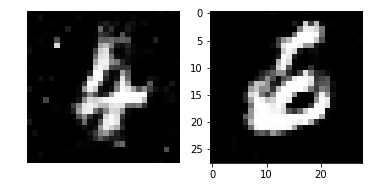

In [162]:
z_opposites = random_sample_z_space(2)
fake_img = generator(z_opposites)

plt.subplot(121); tc_imshow(img=fake_img[0].cpu().detach() /2+0.5  )
plt.subplot(122); tc_imshow(img=fake_img[1].cpu().detach() /2+0.5  )

plt.savefig('../result/GAN/1-GAN/5-side-images.png', dpi=300)

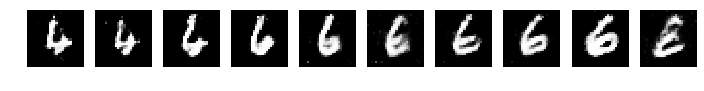

In [163]:
num_interpolation = 10

z_interpolation = Variable(Tensor(np.linspace(z_opposites[0].cpu(), z_opposites[1].cpu(), num_interpolation)))
fake_img = generator(z_interpolation)

plt.figure(figsize=(12,2))
for i in range(num_interpolation):
    plt.subplot(1,num_interpolation,i+1)
    tc_imshow(img=fake_img[i].cpu().detach() /2+0.5 )
    
plt.savefig('../result/GAN/1-GAN/6-interpolation.png', dpi=300)